In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MultipleLocator
from matplotlib.transforms import ScaledTranslation
from statannotations.Annotator import Annotator
import scipy
from matplotlib.ticker import FuncFormatter
from copy import deepcopy
from string import ascii_lowercase as lowercase#, ascii_uppercase as uppercase
from upsetplot import UpSet
import itertools

intermediate_data_folder='intermediate_data_fullgenome'
if os.getcwd()!='phasing_T2T_project':
    os.chdir('..') # Change to the parent directory

## Nature figure requirements
1 col fig = 3.46" wide
2 col fig = 7.08" wide

300dpi

font: Sans serif (Helvetica, Arial)
font size: 5-7 pt

Save as AI, EPS, or PDF.

Max 50MB size per fig.

All text needs to be in editable vector format

Legend: brief figure title, short description for each panel


In [ ]:
#### Display config settings

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 6

one_col=3.34
oneandahalf_col=4.49
two_col=7.08


## Padding (in inches) around axes; defaults to 3/72 inches, i.e. 3 points.
#figure.constrained_layout.h_pad:  0.04167
#figure.constrained_layout.w_pad:  0.04167

plt.rcParams['axes.linewidth'] = 0.75
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'white'

plt.rcParams['figure.figsize'] = (two_col,two_col)
plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams["errorbar.capsize"] = 0.3
plt.rcParams["savefig.dpi"] = 300


def add_letter_to_ax(ax: mpl.axes, label: str | int, points_offset=(-25, 7),
                         va='bottom', fontsize=10, weight='bold', fontfamily='sans', alphabet=lowercase, **kwargs) -> mpl.axes:
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    if type(label) == int:
        label=alphabet[label]
    ax.text(
        0.0, 1.0, label, transform=(
            ax.transAxes + ScaledTranslation(points_offset[0]/72, points_offset[1]/72, ax.get_figure().dpi_scale_trans)),
            va=va, fontsize=fontsize, weight=weight, fontfamily=fontfamily, **kwargs)
    return ax

def add_letter_to_subfig(subfig, label, points_offset=(-25, 7),
                         va='bottom', fontsize=10, weight='bold', fontfamily='sans', alphabet=lowercase, **kwargs):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    if type(label) == int:
        label=alphabet[label]
    subfig.text(
        0.0, 1.0, label, transform=(
            subfig.transSubfigure + ScaledTranslation(points_offset[0]/72, points_offset[1]/72, subfig.get_figure().dpi_scale_trans)),
            va=va, fontsize=fontsize, weight=weight, fontfamily=fontfamily, **kwargs)
    return subfig


def percent_formatter(x, pos, max_decimals=4):
    x = str(x)
    if '.' in x:
        x = '.'.join([x.split('.')[0], x.split('.')[1][:max_decimals]])
    while x[-1] == '0':
        x = x[:-1]
    if x[-1] == '.':
        x = x[:-1]
    return x+'%'

def axis_has_legend(ax) -> bool:
    return ax.get_legend() is not None  # or: getattr(ax, "legend_", None) is not None

def figure_has_legend(ax) -> bool:
    return axis_has_legend(ax) or bool(ax.figure.legends)

perc_formatter = FuncFormatter(percent_formatter)
MAF_xticks = [0.01, 0.1, 1, 10, 50]
SER_xticks = [0.1, 1, 10, 50]

genome_palette=[(0.4,0.4,0.4)] + sns.color_palette()[4:5]
type_markers = {'SNPs + Indels':',', 'SNP':'o', 'Indel':'o'}
type_dashes = {'SNPs + Indels':'', 'SNP':(1,1), 'Indel':(3,0.5)}
syntenic_markers = {'Syntenic':'o', 'Nonsyntenic':'o'}
syntenic_dashes = {'Syntenic':'', 'Nonsyntenic':(1,1)}
update_legend_values={'genome':'Genome',
                      'SNPs + Indels': 'All Variants',
                      'type': 'Variant Type',
                      'syntenic':'Genomic Region',
                      'Nonsyntenic':'CHM13v2.0\n(Newly Resolved)',
                      'CHM13v2.0':'CHM13v2.0',
                      'GRCh38':'GRCh38',
                      'not_in_STRs':'Not in GIAB STR region',
                      'in_STRs':'In GIAB STR region',
                      'in_segdups':'In Segmental Duplication',
                      'not_in_segdups':'Not in Segmental Duplication',
                      'biallelic':'Isolated, biallelic variant',
                      'multiallelic':'Variant overlaps another variant',
                      'not_in_platinum_STRs':'Not in Platinum Genomes STR region',
                      'in_platinum_STRs':'In Platinum Genomes STR region'}



genome_order = ['GRCh38','CHM13v2.0']
type_order = ['SNPs + Indels', 'SNP', 'Indel']
syntenic_order = ['Syntenic', 'Nonsyntenic']
chrom_order = ['Whole\nGenome'] + ['chr'+str(i) for i in range(1,23)] + ['PAR1','PAR2','chrX']


default_style = {
    'errorbar': None,
    'palette':genome_palette,
    'markers':type_markers,
    'dashes':type_dashes,
    'markersize':3,
    'markeredgewidth':0.2,
    'markeredgecolor': 'white',
    'linewidth':1
}

formatted_ancestry_names = {'all':'All\npopulations','WestEurasia':'West\nEurasia','SouthAsia':"South\nAsia",
                            'EastAsia':'East\nAsia','Africa':'Africa', 'America':'Americas','Oceania':'Oceania',
                            'CentralAsiaSiberia':'Central Asia\n& Siberia'}

def add_grid(ax, **kwargs):
    return ax.grid(alpha=0.5, **kwargs)

syntenic_style = deepcopy(default_style)
syntenic_style['markers'] = syntenic_markers
syntenic_style['dashes'] = syntenic_dashes


figures_folder='figures'
supplemental_figures_folder = f'{figures_folder}/supplemental'

if not os.path.exists(figures_folder):
    os.mkdir(figures_folder)
if not os.path.exists(supplemental_figures_folder):
    os.mkdir(supplemental_figures_folder)

In [3]:
binned_maf_data = pd.read_parquet(f"{intermediate_data_folder}/binned_maf_data.parquet")
all_chroms = pd.read_parquet(f'{intermediate_data_folder}/chroms.parquet')
all_samples = pd.read_parquet(f'{intermediate_data_folder}/samples.parquet')
all_ancestries = pd.read_parquet(f'{intermediate_data_folder}/ancestries.parquet')
all_methods = pd.read_parquet(f'{intermediate_data_folder}/methods.parquet')

per_variant_category_imputation_performance = pd.read_parquet(f'{intermediate_data_folder}/per_variant_category_imputation_performance.parquet')
per_sample_imputation_performance = pd.read_parquet(f'{intermediate_data_folder}/per_sample_imputation_performance.parquet')

sum_stats_var_filters = pd.read_parquet(f"{intermediate_data_folder}/filter_summary_stats.parquet")

In [4]:
#Post hoc fixes - one off events that are tricky to deal with when compiling stats

# there is one variant (I have not investigated, but likely a denovo SNP) that is a singleton variant in the HPRC dataset. 
# That variant passed all filters, but makes for a very odd figure (correctly phased: 0% error rate, incorrect: 100% error rate)
# We will trim it here
binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HPRC_samples')&
                    (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')&
                    (binned_maf_data.rounded_MAF == 'singleton'), 
                    ['n_switch_errors','n_checked','switch_error_rate']] = np.nan

binned_maf_data_regions = binned_maf_data.loc[~binned_maf_data.region.str.contains('teni')]
binned_maf_data = binned_maf_data.loc[binned_maf_data.region.str.contains('teni')|(binned_maf_data.region == 'All')].rename(columns={'region':'syntenic'})

# I never converted syntenic representation from true/false to something named. Let's do that.
binned_maf_data = binned_maf_data.assign(syntenic=binned_maf_data.syntenic
                                                                 .astype(str)
                                                                 .fillna('All')
                                                                 .replace(True,'Syntenic')
                                                                 .replace(False,'Nonsyntenic')
                                                                 )



# Nonsyntenic GRCh38 regions are mostly GRCh38 errors, and we are not interested in the performance in these regions
binned_maf_data = binned_maf_data.loc[~((binned_maf_data.genome=='GRCh38')&(binned_maf_data.syntenic=='Nonsyntenic'))]

# NA20355 is a duo member, and as such was not part of duohmm trio correction for the GRCh38 2022 effort.
all_chroms.loc[(all_chroms.genome=='GRCh38')&(all_chroms['sample_id']=='NA20355'), 'trio_phased'] = False
all_samples.loc[(all_samples.genome=='GRCh38')&(all_samples['sample_id']=='NA20355'), 'trio_phased'] = False
all_chroms = all_chroms.loc[~((all_chroms.genome=='GRCh38')&(all_chroms['sample_id']=='NA20355')&(all_chroms.ground_truth_data_source.isin(['HPRC_HGSVC_probands','HGSVC_probands'])))]
all_samples = all_samples.loc[~((all_samples.genome=='GRCh38')&(all_samples['sample_id']=='NA20355')&
                                (all_samples.ground_truth_data_source.isin(['HPRC_HGSVC_probands','HGSVC_probands'])))]

# very high variance stats when n_checked is less than 10. Replace switch error rate at these sites with np.nan
binned_maf_data.loc[(binned_maf_data.n_checked>10), 'switch_error_rate'] = binned_maf_data.loc[(binned_maf_data.n_checked>10), 'switch_error_rate'].replace(0, np.nan)

# bins with a switch error rate of 0 make for insane figures when plotted on a log scale. Replace with np.nan, and maybe note
binned_maf_data['switch_error_rate'] = binned_maf_data['switch_error_rate'].replace(0, np.nan)

# A reviewer suggests combining chrX, PAR1, and PAR2 statistics. I will do that, and set male chrX switch error rates to np.nan.
# Calculate percent discordance in imputation performance
if 'perc_discordance' not in per_variant_category_imputation_performance.columns:
    per_variant_category_imputation_performance = per_variant_category_imputation_performance.loc[per_variant_category_imputation_performance.num_AA > 0]
    if max(per_variant_category_imputation_performance.mean_AF) < 1:
        per_variant_category_imputation_performance.mean_AF *= 100
    per_variant_category_imputation_performance['num_alt_mismatches'] = per_variant_category_imputation_performance.num_Aa_mismatches + per_variant_category_imputation_performance.num_aa_mismatches
    per_variant_category_imputation_performance['num_alt_variants'] = per_variant_category_imputation_performance.num_Aa + per_variant_category_imputation_performance.num_aa
    per_variant_category_imputation_performance['perc_discordance'] = per_variant_category_imputation_performance['num_alt_mismatches']/per_variant_category_imputation_performance['num_alt_variants']*100
    per_variant_category_imputation_performance['perc_concordance'] = 100-per_variant_category_imputation_performance['perc_discordance']

# imputed df needs to have CHM13v2.0 as genome name instead of T2T
per_variant_category_imputation_performance = per_variant_category_imputation_performance.replace('T2T','CHM13v2.0')
per_sample_imputation_performance = per_sample_imputation_performance.replace('T2T','CHM13v2.0')

# A supplemental calculates SER by % of chromosome that is new. we calc that here.
if 'percent_new' not in all_chroms.columns:
    syntenic_bed = pd.read_csv('resources/hg38.GCA_009914755.4.synNet.summary.bed.gz', sep='\t', header=None)
    syntenic_bed.columns = ['chrom','start','end','status']
    starts = syntenic_bed.groupby('chrom').first().reset_index()
    syntenic_bed['length'] = syntenic_bed.end-syntenic_bed.start
    syntenic_bed['dif'] = syntenic_bed.end.diff()
    syntenic_bed['nonsyn_len'] = syntenic_bed.dif - syntenic_bed.length
    syntenic_bed.loc[syntenic_bed.nonsyn_len < 0, 'nonsyn_len'] = syntenic_bed.loc[syntenic_bed.nonsyn_len < 0, 'start']
    syntenic_bed.loc[syntenic_bed.nonsyn_len.isna(), 'nonsyn_len'] = syntenic_bed.loc[syntenic_bed.nonsyn_len.isna(), 'start']
    rough_length = syntenic_bed.groupby('chrom').end.max().reset_index()
    chr_nonsyn_lengths = syntenic_bed.groupby('chrom').sum(numeric_only=True).reset_index()[['chrom','nonsyn_len']]
    chr_nonsyn_lengths = chr_nonsyn_lengths.merge(rough_length, on='chrom')
    chr_nonsyn_lengths['percent_new'] = chr_nonsyn_lengths.nonsyn_len/chr_nonsyn_lengths.end * 100
    all_chroms = all_chroms.merge(chr_nonsyn_lengths[['chrom', 'percent_new']], on=['chrom'],how='left')

all_chroms_chrX = all_chroms.loc[all_chroms.chrom.isin(('chrX','PAR1','PAR2'))].assign(chrom='chrX')
all_chroms_chrX = all_chroms_chrX.groupby(['chrom','genome','sample_id','method_of_phasing','ground_truth_data_source','population', 'superpopulation', 'sex', 'trio_phased'],observed=True).sum(numeric_only=True).reset_index()
all_chroms_chrX.loc[all_chroms_chrX.sex=='Male', ['n_switch_errors','n_total_switch_errors','n_flips','n_consecutive_flips','n_true_switch_errors','num_correct_phased_hets',
                                                  'n_total_hets','flip_and_switches_SER', 'flip_error_rate', 'true_switch_error_rate','accurately_phased_rate']] = np.nan

all_chroms_chrX['switch_error_rate'] = all_chroms_chrX.n_switch_errors/all_chroms_chrX.n_checked * 100
all_chroms_chrX['gt_error_rate'] = all_chroms_chrX.n_gt_errors/all_chroms_chrX.n_gt_checked * 100
all_chroms_chrX['flip_and_switches_SER'] = all_chroms_chrX.n_total_switch_errors/all_chroms_chrX.n_total_hets * 100
all_chroms_chrX['flip_error_rate'] = all_chroms_chrX.n_flips/all_chroms_chrX.n_total_hets * 100
all_chroms_chrX['true_switch_error_rate'] = all_chroms_chrX.n_true_switch_errors/all_chroms_chrX.n_total_hets * 100

all_chroms_chrX = pd.concat((all_chroms_chrX, all_chroms.loc[~all_chroms.chrom.isin(('chrX','PAR1','PAR2'))])).drop(columns=['L50','N50','percent_new'])


binned_maf_data = binned_maf_data.sort_values('type', key=lambda col: col.apply(lambda x: {'Indel':0, 'SNP':1, 'SNPs + Indels':2}.get(x,x)))
binned_maf_data = binned_maf_data.sort_values('genome', key=lambda col: col.apply(lambda x: {'GRCh38':0, 'CHM13v2.0':1}.get(x,x)))

if binned_maf_data['switch_error_rate'].max() < 1:
    binned_maf_data['switch_error_rate'] *= 100
if binned_maf_data['gt_error_rate'].max() < 1:
    binned_maf_data['gt_error_rate'] *= 100
if binned_maf_data['MAF'].max() < 1:
    binned_maf_data['MAF'] *= 100

# a handful of variants are miscategorized as singletons. There are no true GRCh38 singletons. We can fix this.
binned_maf_data = binned_maf_data.loc[~((binned_maf_data.rounded_MAF=='singleton')&(binned_maf_data.genome=='GRCh38')&(binned_maf_data.method_of_phasing=='phased_with_parents_and_pedigree')&(binned_maf_data.ground_truth_data_source!='trios'))]

binned_maf_data.to_parquet(f'{intermediate_data_folder}/per_MAF_bin.parquet')

# Calculate weighted "overall" error rates
cat_data = binned_maf_data.loc[binned_maf_data.ground_truth_data_source.isin(('HPRC_samples', 'HGSVC_parents', 'HGSVC_parents', 'HGSVC_samples_nontrios_only')) &
                               (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')].copy()
cat_data.loc[cat_data.n_switch_errors == 0, 'switch_error_rate'] = np.nan
cat_data['support'] = cat_data.ground_truth_data_source.map({'HPRC_samples':'proband', 'HGSVC_probands':'proband','HGSVC_parents':'parent', 'HGSVC_samples_nontrios_only':'nontrio'})

num_probands_in_dataset = 68
num_parents_in_dataset =  13
num_nontrios_in_dataset = 19
num_probands_in_1kgp = 608
num_parents_in_1kgp  = 1199
num_nontrios_in_1kgp = 1399

cat_data.loc[(cat_data.support=='proband') & (cat_data.genome=='GRCh38'), ['n_switch_errors','n_checked', 'n_gt_errors','n_gt_checked','MAC','AN']] = (((num_probands_in_1kgp-1)/num_probands_in_dataset-1) * cat_data.loc[(cat_data.support=='proband') & (cat_data.genome=='GRCh38'), ['n_switch_errors','n_checked', 'n_gt_errors','n_gt_checked','MAC','AN']]).fillna(0).astype(int)
cat_data.loc[(cat_data.support=='proband') & (cat_data.genome=='CHM13v2.0'), ['n_switch_errors','n_checked', 'n_gt_errors','n_gt_checked','MAC','AN']] = ((num_probands_in_1kgp/num_probands_in_dataset) * cat_data.loc[(cat_data.support=='proband') & (cat_data.genome=='CHM13v2.0'), ['n_switch_errors','n_checked', 'n_gt_errors','n_gt_checked','MAC','AN']]).fillna(0).astype(int)
cat_data.loc[cat_data.support=='parent', ['n_switch_errors','n_checked', 'n_gt_errors','n_gt_checked','MAC','AN']] = ((num_parents_in_1kgp/num_parents_in_dataset) * cat_data.loc[cat_data.support=='parent', ['n_switch_errors','n_checked', 'n_gt_errors','n_gt_checked','MAC','AN']]).fillna(0).astype(int)
cat_data.loc[cat_data.support=='nontrio', ['n_switch_errors','n_checked', 'n_gt_errors','n_gt_checked','MAC','AN']] = ((num_nontrios_in_1kgp/num_nontrios_in_dataset) * cat_data.loc[cat_data.support=='nontrio', ['n_switch_errors','n_checked', 'n_gt_errors','n_gt_checked','MAC','AN']]).fillna(0).astype(int)
cat_data.loc[(cat_data.n_switch_errors == 0), 'switch_error_rate'] = np.nan
cat_data = cat_data.groupby(['genome','type','rounded_MAF','syntenic'], observed=True).sum(numeric_only=True)
cat_data['gt_error_rate'] = cat_data.n_switch_errors/cat_data.n_checked * 100
cat_data['gt_error_rate'] = cat_data.n_gt_errors/cat_data.n_gt_checked * 100
cat_data['MAF'] = cat_data.MAC/cat_data.AN * 100
cat_data = cat_data.reset_index()
cat_data['switch_error_rate'] = cat_data['switch_error_rate'].replace(0, np.nan)
binned_maf_data = pd.concat([binned_maf_data, cat_data.assign(ground_truth_data_source='estimated', method_of_phasing='phased_with_parents_and_pedigree')])


### Define line graph styling

In [5]:
def highlight_value(df, var, val):
    df['highlight'] = False
    df.loc[df[var] == val, 'highlight'] = True
    return df

highlight_style = {'size':'highlight', 'size_order':[True, False], 'sizes':(1.5,3)}

def add_highlights_legend(ax, var, val, sizes=highlight_style['sizes']):

    def is_variable_title(handle):
        return handle.get_color()=='w'

    new_handles = list()
    new_labels = list()
    handles, labels = ax.get_legend_handles_labels()
    in_higlight_var_section=False
    for handle, label in zip(handles, labels):
        if is_variable_title(handle):
            in_higlight_var_section = label == var

        if label not in ['highlight','True','False']:
            if in_higlight_var_section:
                if label == val:
                    handle.set_linewidth(sizes[1])
                else:
                    handle.set_linewidth(sizes[0])
            new_labels.append(update_legend_values.get(label,label))
            new_handles.append(handle)
        else:
            print(label)
    ax.legend(handles=new_handles, labels=new_labels)
    return ax


# Figures

### Figure 1: Recombination maps

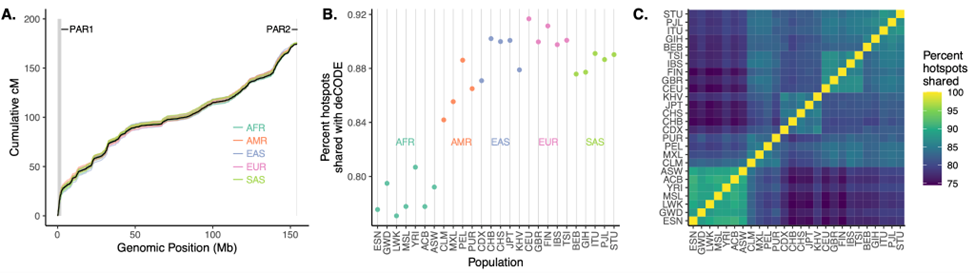

## Fig 2
### Introduction to the phased panels, basic performance statistics
 - 2x2 figure: Panel accuracy, split by SNPs, indels, mendelian- and statistically phased samples (4 figure panels)

 - Supplemental: Swarm plots of error rates by probands, parents, stat-phased can go in supplement
   - Genotyping error rates, same 2x2 as figure 2

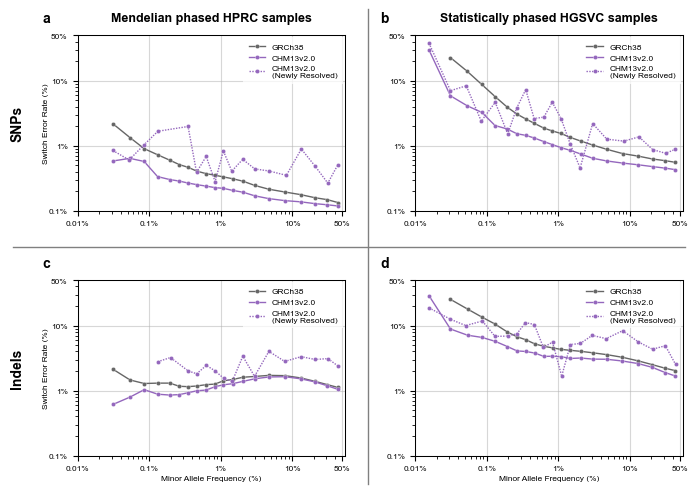

In [6]:
# Figure 2

fig, ((axA, axB),(axC, axD)) = plt.subplots(2,2, figsize=(two_col, 5))
fig.set_layout_engine(layout='constrained', h_pad=0.15, w_pad=0.15)
sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', #hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'SNP')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axA, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'SNP')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axB, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'Indel')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axC, **syntenic_style)


sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'Indel')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axD, **syntenic_style)


for i, ax in enumerate([axA, axB, axC, axD]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-1, 50)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks)
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (2,3):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2):
        ax.set_ylabel('Switch Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)

axA.text(-.2,0.5, 'SNPs', fontsize=10, transform=axA.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axC.text(-.2,0.5, 'Indels', fontsize=10, transform=axC.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axA.set_title('Mendelian phased HPRC samples', fontsize=9, weight='bold', pad=10)
axB.set_title('Statistically phased HGSVC samples', fontsize=9, weight='bold', pad=10)


for i, ax in enumerate([axA, axB, axC, axD]): # legend axes
    if i == 0:
        loc='upper right'
    else:
        loc='upper right'
    handles, labels = ax.get_legend_handles_labels()
    for handle in handles:
        handle.set_marker('o')
    handles = handles[1:3] + handles[5:6]
    labels = labels[1:3] + labels[5:6]
    handles[-1].set_color(handles[1].get_color())
    legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    legend.set_title(None)
    legend.get_frame().set(
        alpha=0.75, boxstyle='square', edgecolor='grey', linewidth=0)
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)

x_pos = 0.5275
y_pos = 0.5
perc_of_figure=0.95
fig.add_artist(mpl.lines.Line2D([(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], [y_pos, y_pos], color='grey', alpha=1, linewidth=1))
fig.add_artist(mpl.lines.Line2D([x_pos, x_pos], [(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], color='grey', alpha=1, linewidth=1))

add_letter_to_ax(axA, 'a')
add_letter_to_ax(axB, 'b')
add_letter_to_ax(axC, 'c')
add_letter_to_ax(axD, 'd')

plt.savefig('figures/Figure 2.png', facecolor='white')
plt.savefig('figures/Figure 2.svg', facecolor='white')

Fig 2. Phased panel switch error rates binned by minor allele frequency. Of the 3202 participants in the 1KGP, 39 had their genomes assembled by the HPRC. An additional 61 had their genomes assembled by the HGSVC. a) The switch error rate of haplotype panel SNPs from 39 indiviudals, using their HPRC-assembled genomes as ground truth. Variants located in regions of CHM13v2.0 that are non-syntenic with GRCh38 are included in overall variant bin error rates, but are also plotted separately as CHM13v2.0 (Novel) variants. b) SER of haplotype panel SNPs from 19 individuals, using their HGSVC-assembled genomes as ground truth. Unlike the 39 HPRC samples, these 19 individuals are not part of a 1KGP trio, and therefore were phased without any mendelian-based error correction. c) Indel SER from the mendelian-phased HPRC samples. d) Indel SER from the 19 individuals phased without mendelian error correction. Switch error rates and average minor allele frequency per bin are displayed on a log scale.

Using upsetplot version /home/lalli/.linuxbrew/opt/python@3.11/lib/python3.11/site-packages/upsetplot/__init__.py
['AC <= 1', 'Mend. Error Rate > 5%', 'Low population HWE', '>5% missing', 'Variant over 50bp', 'ALT allele is star ('\*')', 'PASS Filter']
['AC <= 1', 'Mend. Error Rate > 5%', 'Low population HWE', '>5% missing', 'Variant over 50bp', 'ALT allele is star ('\*')', 'PASS Filter']
['VQSLOD < 0', 'MAC == 0', 'Mend. Error Rate > 5%', 'Low population HWE', '>5% missing', 'Variant over 50bp', 'ALT allele is star ('\*')', 'PASS Filter']


/tmp/ipykernel_2892998/4020693012.py:48: DeprecationWarning: element_size parameter is deprecated and will be removed in a future version. Use element_size_fraction instead for fractional sizing relative to figure dimensions.
  upset = UpSet(
/tmp/ipykernel_2892998/4020693012.py:48: DeprecationWarning: element_size parameter is deprecated and will be removed in a future version. Use element_size_fraction instead for fractional sizing relative to figure dimensions.
  upset = UpSet(
/tmp/ipykernel_2892998/4020693012.py:48: DeprecationWarning: element_size parameter is deprecated and will be removed in a future version. Use element_size_fraction instead for fractional sizing relative to figure dimensions.
  upset = UpSet(
/tmp/ipykernel_2892998/4020693012.py:48: DeprecationWarning: element_size parameter is deprecated and will be removed in a future version. Use element_size_fraction instead for fractional sizing relative to figure dimensions.
  upset = UpSet(


['VQSLOD < 0', 'MAC == 0', 'Mend. Error Rate > 5%', 'Low population HWE', '>5% missing', 'Variant over 50bp', 'ALT allele is star ('\*')', 'PASS Filter']
14 = 7 + (7 or 0)
Max grid height: 225.0 pixels
Figure height: 450.0 pixels
16.071428571428573 = 225.0 / 14
14 = 7 + (7 or 0)
Max grid height: 225.0 pixels
Figure height: 450.0 pixels
16.071428571428573 = 225.0 / 14
16 = 8 + (8 or 0)
Max grid height: 225.0 pixels
Figure height: 450.0 pixels
14.0625 = 225.0 / 16
16 = 8 + (8 or 0)
Max grid height: 225.0 pixels
Figure height: 450.0 pixels
14.0625 = 225.0 / 16


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


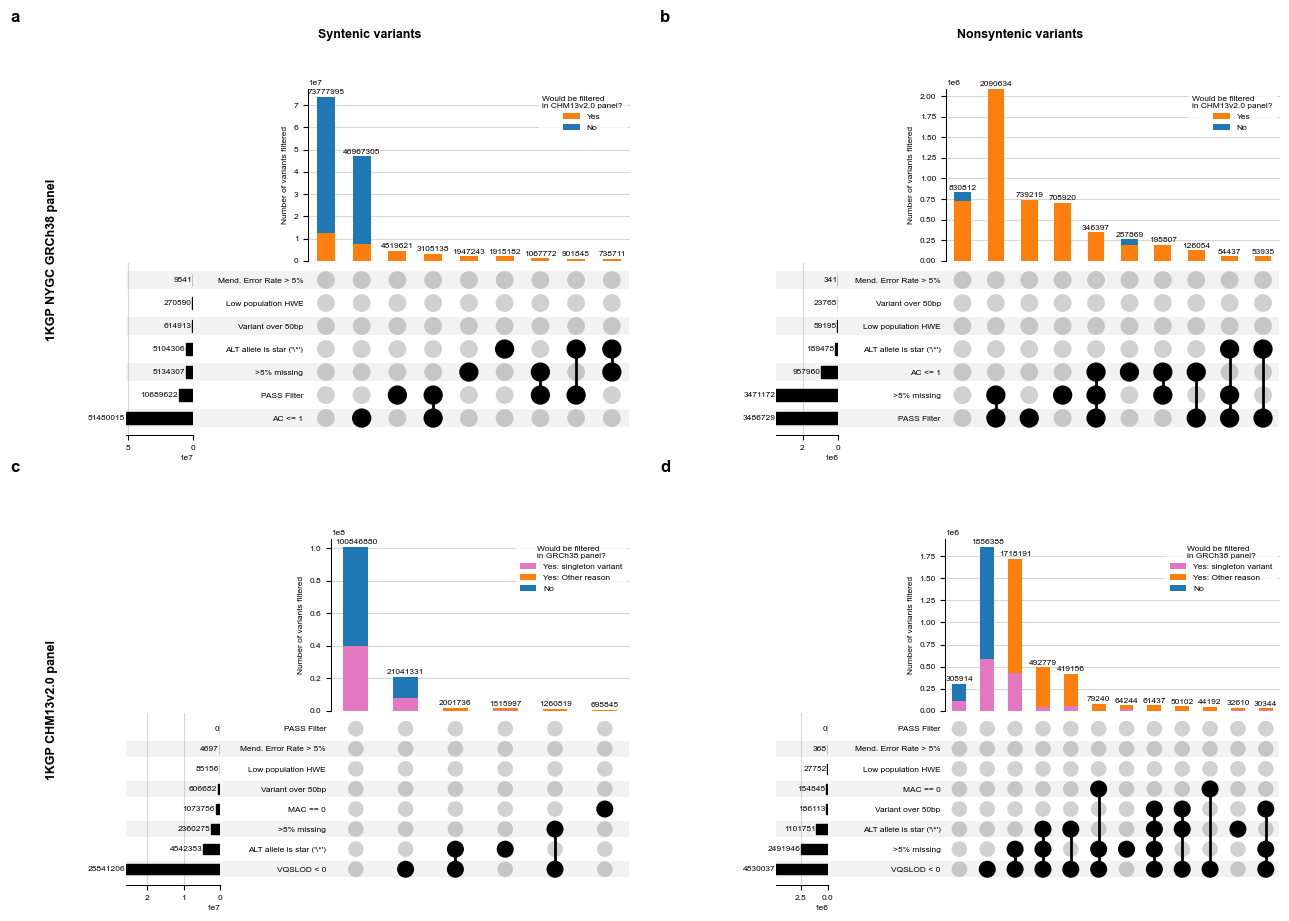

In [7]:
# Figure 2 supplementals
# Supplemental 1: effects of variant filtering
import importlib
import upsetplot
importlib.reload(upsetplot)
from upsetplot import UpSet
print (f'Using upsetplot version {upsetplot.__file__}')

def move_all_passing_to_front(df):
    passing=(False,)*len(df.index[0])
    new_index = df.groupby(df.index).sum().sort_values('num_variants', ascending=False).index.drop(passing)
    new_index = new_index.insert(0, passing)
    return df.loc[new_index,:]

def reshape_data_for_upsetplot(data, genome_name, filter_columns, color_scheme):
    """Process genome-specific data for UpSet plots"""
    genome_data = data.loc[data.genome==genome_name].rename(columns={'len':'num_variants','CHM13_criteria_fail':'other_criteria_fail'} if genome_name == 'GRCh38' else {'len':'num_variants','GRCh38_criteria_fail':'other_criteria_fail'})
    
    if genome_name == 'CHM13v2.0':
        genome_data['grch38_fail_besides_singleton'] = genome_data[data[[x for x in ['MERR_filter', 'HWE_pop_filter','AC_filter', 'f_missing_filter', 'var_len_filter', 'alt_star_filter', 'pass_filter'] if x != 'AC_filter'] + ['MAC_filter']].columns].any(axis=1)
    
    genome_data['other_criteria_fail'] = genome_data['other_criteria_fail'].astype(str)
    
    if genome_name == 'GRCh38':
        genome_data.loc[genome_data.other_criteria_fail=='False', 'other_criteria_fail'] = 'No'
        genome_data.loc[genome_data.other_criteria_fail=='True', 'other_criteria_fail'] = 'Yes'
    else:  # CHM13v2.0
        genome_data.loc[genome_data.singleton & (genome_data.grch38_fail_besides_singleton != 'True'), 'other_criteria_fail'] = 'Yes: singleton variant'
        genome_data.loc[genome_data.other_criteria_fail=='False', 'other_criteria_fail'] = 'No'
        genome_data.loc[genome_data.other_criteria_fail=='True', 'other_criteria_fail'] = 'Yes: Other reason'
    
    filters = genome_data.groupby(['other_criteria_fail']+filter_columns).sum(numeric_only=True).reset_index().set_index(filter_columns)
    syntenic_annotated = genome_data.groupby(['other_criteria_fail','Syntenic']+filter_columns).sum(numeric_only=True).reset_index().set_index(filter_columns)
    syntenic_only_fail = genome_data.loc[genome_data[filter_columns].sum(axis=1)>0].groupby(['other_criteria_fail','Syntenic']+filter_columns).sum(numeric_only=True).reset_index().set_index(filter_columns)

    return {
        'filters': filters,
        'syntenic_annotated': syntenic_annotated,
        'syntenic_only_fail': syntenic_only_fail,
        'color_scheme': color_scheme
    }

def create_upset_plot(data, is_syntenic, genome_name, cutoff_perc, element_size, top_x_categories, colors, filter_column_rename):
    """Create an UpSet plot for the given data"""
    subset_data = move_all_passing_to_front(data.loc[(data.Syntenic==is_syntenic)].rename_axis(index=filter_column_rename))
    cutoff = subset_data.num_variants.sum().item() * cutoff_perc
    
    upset = UpSet(
        subset_data[['other_criteria_fail','num_variants']], 
        show_counts=True, 
        sum_over='num_variants', 
        sort_by='input',
        orientation="horizontal", 
        min_subset_size=cutoff,
        intersection_plot_elements=0,
        element_size=element_size
    )
    print(subset_data.index.names)
    upset.add_stacked_bars(
        by="other_criteria_fail", 
        title="Number of variants filtered", 
        sum_over='num_variants', 
        elements=len(subset_data.index.names),
        colors=colors
    )
    
    return upset

def create_upset_figure_layout(upset_plots_config):
    """Create the main figure with 2x2 subplot layout and labels"""
    fig = plt.figure(figsize=(13,9), layout='constrained')
    ((subA, subB), (subC, subD)) = fig.subfigures(2, 2, wspace=-0.5, hspace=-0.5)

    # Plot each UpSet plot in its designated subfigure
    subplots = [subA, subB, subC, subD]
    configs = upset_plots_config
    
    for i, (subplot, config) in enumerate(zip(subplots, configs)):
        axes = config['upset'].plot(fig=subplot)
        axes['extra0'].legend().set_title(config['legend_title'])
        add_letter_to_subfig(subplot, chr(ord('a') + i), fontsize=12)
    
    # Add main labels
    fig.text(.01,0.25, '1KGP CHM13v2.0 panel', fontsize=9, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
    fig.text(.01,0.75, '1KGP NYGC GRCh38 panel', fontsize=9, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
    fig.text(.25,1, 'Syntenic variants', fontsize=9, weight='bold', rotation='horizontal', horizontalalignment='center', verticalalignment='center')
    fig.text(.75,1, 'Nonsyntenic variants', fontsize=9, weight='bold', rotation='horizontal', horizontalalignment='center', verticalalignment='center')
    
    return fig

# Load and prepare data
grch38_filter_columns=['AC_filter',
                       'MERR_filter', 'HWE_pop_filter', 'f_missing_filter', 
                       'var_len_filter', 'alt_star_filter', 'pass_filter']
chm13_filter_columns=['VQSLOD_filter', 'MAC_filter',
                      'MERR_filter', 'HWE_pop_filter', 'f_missing_filter', 
                      'var_len_filter', 'alt_star_filter', 'pass_filter']

filter_column_rename = {'HWE_pop_filter':'Low population HWE',
                        'AC_filter': 'AC <= 1',
                        'MAC_filter': 'MAC == 0',
                        'f_missing_filter':">5% missing",
                        'var_len_filter':'Variant over 50bp',
                        'alt_star_filter':'ALT allele is star (\'\*\')',
                        'pass_filter': 'PASS Filter',
                        'MERR_filter': 'Mend. Error Rate > 5%',
                        'VQSLOD_filter':'VQSLOD < 0'}

sum_stats_var_filters['only_filtered_from_grch38_because_singleton'] = sum_stats_var_filters[[x for x in grch38_filter_columns if x != 'AC_filter'] + ['MAC_filter']].any(axis=1)

# Define color schemes
grch38_color_scheme={'No: Singleton variant': sns.color_palette()[6],
                     'Yes':sns.color_palette()[1],
                     'No': sns.color_palette()[0]}
chm13_color_scheme={'Yes: singleton variant': sns.color_palette()[6],
                    'Yes: Other reason':sns.color_palette()[1],
                    'No': sns.color_palette()[0]}

# Process data for both genomes
grch38_processed = reshape_data_for_upsetplot(sum_stats_var_filters, 'GRCh38', grch38_filter_columns, grch38_color_scheme)
chm13_processed = reshape_data_for_upsetplot(sum_stats_var_filters, 'CHM13v2.0', chm13_filter_columns, chm13_color_scheme)

# Configuration
element_size = 30
top_x_categories = 12
cutoff_perc = 0.005

# Create UpSet plots
upset_syn_grch38 = create_upset_plot(grch38_processed['syntenic_annotated'], True, 'GRCh38', cutoff_perc, element_size, 16, grch38_color_scheme, filter_column_rename)
upset_nonsyn_grch38 = create_upset_plot(grch38_processed['syntenic_annotated'], False, 'GRCh38', cutoff_perc, element_size, top_x_categories, grch38_color_scheme, filter_column_rename)
upset_syn_chm13 = create_upset_plot(chm13_processed['syntenic_annotated'], True, 'CHM13v2.0', cutoff_perc, element_size, top_x_categories, chm13_color_scheme, filter_column_rename)
upset_nonsyn_chm13 = create_upset_plot(chm13_processed['syntenic_annotated'], False, 'CHM13v2.0', cutoff_perc, element_size, top_x_categories, chm13_color_scheme, filter_column_rename)

# Configure plots for figure layout
upset_plots_config = [
    {'upset': upset_syn_grch38, 'legend_title': 'Would be filtered\nin CHM13v2.0 panel?'},
    {'upset': upset_nonsyn_grch38, 'legend_title': 'Would be filtered\nin CHM13v2.0 panel?'},
    {'upset': upset_syn_chm13, 'legend_title': 'Would be filtered\nin GRCh38 panel?'},
    {'upset': upset_nonsyn_chm13, 'legend_title': 'Would be filtered\nin GRCh38 panel?'}
]

# Create and save figure
fig = create_upset_figure_layout(upset_plots_config)

fig.savefig('figures/supplemental/Supplemental 1.png',pad_inches=.5)
fig.savefig('figures/supplemental/Supplemental 1.svg',bbox_inches='tight')
fig.savefig('figures/supplemental/Supplemental 1.eps',pad_inches=0.5)
fig.savefig('figures/supplemental/Supplemental 1.pdf',pad_inches=0.5)

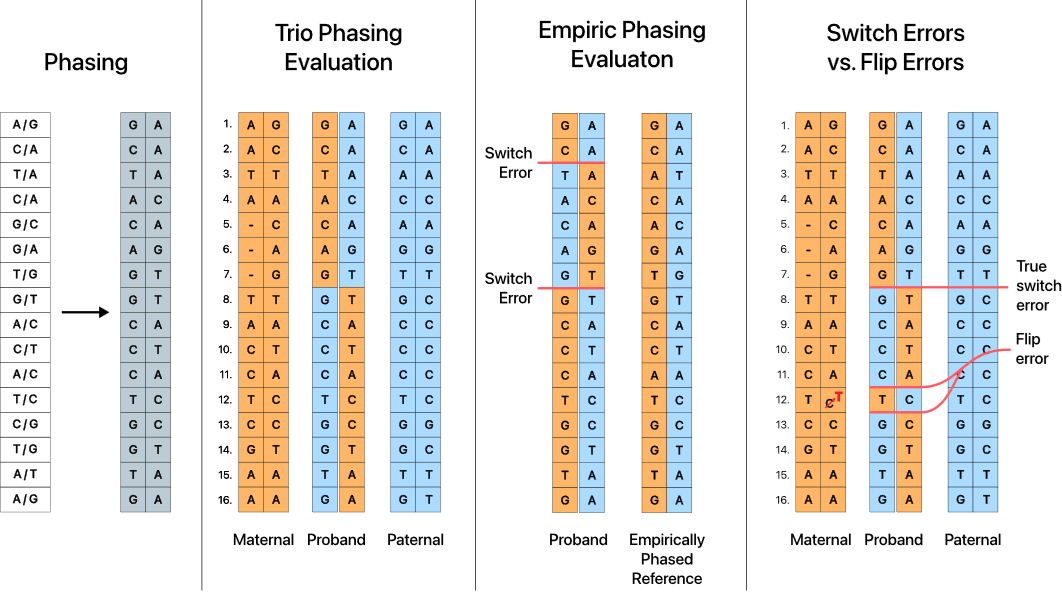

Supplemental Figure 2. Illustration describing different methods of evaluating phasing quality.
Phasing is the process of assigning heterozygous variant calls to one of two haplotypes (in the case of diploid organisms.) One of the challenges of assessing the accuracy of statistically phased haplotypes is identifying a ground truth to compare to. In the case of trio-based phasing evaluation, the ground truth is parental genomes. While not every heterozygous site can be assigned to a haplotype of paternal or maternal origin, most can confidently be assigned to one or the other. Alternately, one can use an empirically phased reference assembly as a source of ground truth.
When a callset’s phasing describes a variant that is from a different parent of origin than the preceeding variant, that is called a switch error. Genotyping errors, as illustrated in the fourth panel, can force statistical phasing software to assign a variant to a haplotype that is different than nearby heterozygous sites. When two switch errors occur back-to-back, that is described as a flip error. Importantly, flip errors do not affect the phasing of surrounding heterozygous sites. Discerning flip errors from true switch errors is important when evaluating phasing methods, as the majority of switch errors can frequently be found in flip errors. Counting these switches as “true” switch errors inflates switch error rates by including sites that do not affect regional phasing.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


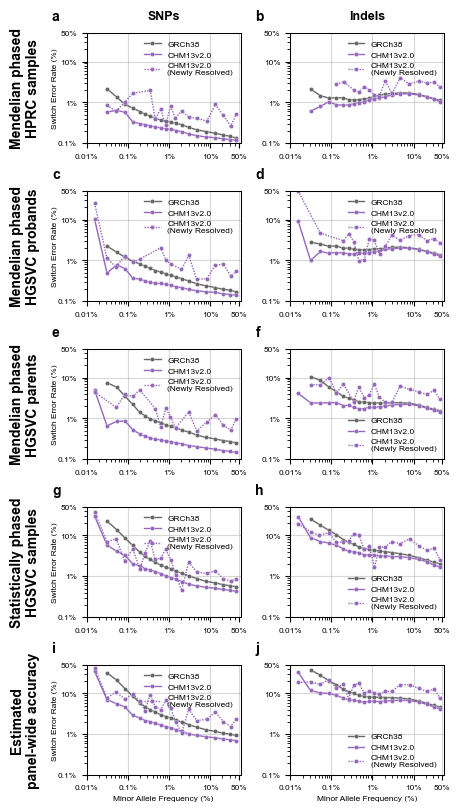

In [8]:
# Figure 2 supplementals
# Figure 2

## Figure 2 with parents and estimated overall
fig, ((axA, axB), (axC, axD), (axE, axF), (axG, axH), (axI, axJ)) = plt.subplots(5,2, figsize=(oneandahalf_col,8))

# fig.set_layout_engine(layout='constrained', h_pad=0.15, w_pad=0.15)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'SNP')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axA, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_probands') #trios only
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'SNP')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axC, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_parents') #trios only
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'SNP')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axE, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'SNP')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axG, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=cat_data.loc[(cat_data.type == 'SNP')
                                      & (cat_data.syntenic != 'All')],
             legend=True, ax=axI, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'Indel')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axB, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_probands')
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'Indel')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axD, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_parents')
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'Indel')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axF, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'Indel')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axH, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=cat_data.loc[(cat_data.type == 'Indel')
                                      & (cat_data.syntenic != 'All')],
             legend=True, ax=axJ, **syntenic_style)

for i, ax in enumerate([axA, axB, axC, axD, axE, axF, axG, axH, axI, axJ]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-1, 50)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks)
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (8,9):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2,4,6,8):
        ax.set_ylabel('Switch Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)
    add_letter_to_ax(ax, i)

x_offset = -0.4
axA.text(x_offset, 0.5, 'Mendelian phased\nHPRC samples', fontsize=10, transform=axA.transAxes, weight='bold', rotation='vertical', horizontalalignment='center', verticalalignment='center')
axC.text(x_offset, 0.5, 'Mendelian phased\nHGSVC probands', fontsize=10, transform=axC.transAxes, weight='bold', rotation='vertical', horizontalalignment='center', verticalalignment='center')
axE.text(x_offset, 0.5, 'Mendelian phased\nHGSVC parents', fontsize=10, transform=axE.transAxes, weight='bold', rotation='vertical', horizontalalignment='center', verticalalignment='center')
axG.text(x_offset, 0.5, 'Statistically phased\nHGSVC samples', fontsize=10, transform=axG.transAxes, weight='bold', rotation='vertical', horizontalalignment='center', verticalalignment='center')
axI.text(x_offset, 0.5, 'Estimated\npanel-wide accuracy', fontsize=10, transform=axI.transAxes, weight='bold', rotation='vertical', horizontalalignment='center', verticalalignment='center')

axA.set_title('SNPs', fontsize=9, weight='bold', pad=10)
axB.set_title('Indels', fontsize=9, weight='bold', pad=10)

for i, ax in enumerate([axA, axB, axC, axD, axE, axF, axG, axH, axI, axJ]): # legend axes
    if i in (5,7,9):
        loc='lower right'
    else:
        loc='upper right'
    handles, labels = ax.get_legend_handles_labels()
    for handle in handles:
        handle.set_marker('o')
    handles = handles[1:3] + handles[5:6]
    labels = labels[1:3] + labels[5:6]
    handles[-1].set_color(handles[1].get_color())
    legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    legend.set_title(None)
    legend.get_frame().set(
        alpha=0, boxstyle='square', edgecolor='grey', linewidth=0)
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)


plt.savefig('figures/supplemental/Supplemental 4.png', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 4.svg', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 4.eps', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 4.pdf', facecolor='white')


Supplemental Figure 3. 
SNP (L column) and Indel (R column) switch error rates for 1KGP phased haplotype panel variation, binned by minor allele frequency.
Switch error rates were determined by comparing estimated phasing to ground-truth assemblies for the following subsets of samples: a) Mendelian-corrected trio probands with ground truth assemblies present in the HPRC human pangenome; b) Mendelian-corrected trio probands with ground truth assemblies produced by the HGSVC; c) Mendelian-corrected trio parents with ground truth assemblies produced by the HGSVC; d) Uncorrected samples which are not part of a 1KGP trio with ground truth assemblies produced by the HGSVC. e) The switch error rates of trio probands, trio parents, and non-trio samples were weighted by each category's prevelance in the 1000 Genomes Project to produce estimated panel-wide average switch error rates. Switch error rates and average minor allele frequency per bin are displayed on a log scale.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


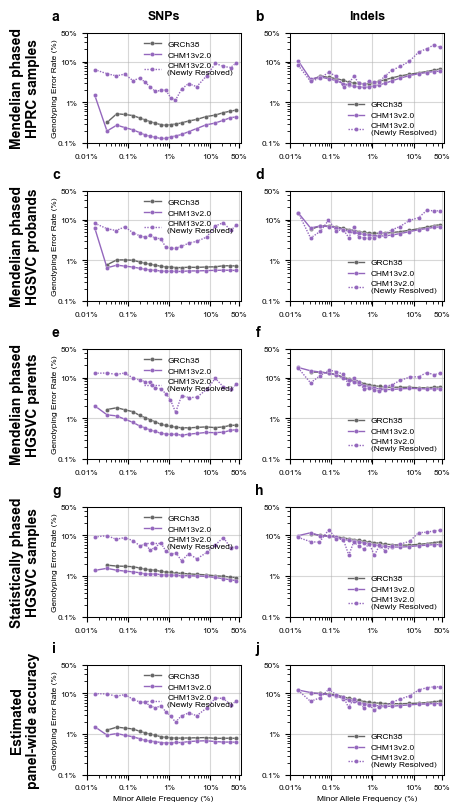

In [9]:
# Figure 2 supplementals
# Figure 2

## Figure 2 with parents and estimated overall
fig, ((axA, axB), (axC, axD), (axE, axF), (axG, axH), (axI, axJ)) = plt.subplots(5,2, figsize=(oneandahalf_col,8))

# fig.set_layout_engine(layout='constrained', h_pad=0.15, w_pad=0.15)

sns.lineplot(x='MAF',y='gt_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'SNP')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axA, **syntenic_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_probands') #trios only
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'SNP')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axC, **syntenic_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_parents') #trios only
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'SNP')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axE, **syntenic_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'SNP')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axG, **syntenic_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=cat_data.loc[(cat_data.type == 'SNP')
                                      & (cat_data.syntenic != 'All')],
             legend=True, ax=axI, **syntenic_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'Indel')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axB, **syntenic_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_probands')
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'Indel')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axD, **syntenic_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_parents')
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'Indel')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axF, **syntenic_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data.type == 'Indel')
                                      & (binned_maf_data.syntenic != 'All')],
             legend=True, ax=axH, **syntenic_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=cat_data.loc[(cat_data.type == 'Indel')
                                      & (cat_data.syntenic != 'All')],
             legend=True, ax=axJ, **syntenic_style)

for i, ax in enumerate([axA, axB, axC, axD, axE, axF, axG, axH, axI, axJ]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-1, 50)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks)
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (8,9):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2,4,6,8):
        ax.set_ylabel('Genotyping Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)
    add_letter_to_ax(ax, i)


x_offset = -0.4
axA.text(x_offset, 0.5, 'Mendelian phased\nHPRC samples', fontsize=10, transform=axA.transAxes, weight='bold', rotation='vertical', horizontalalignment='center', verticalalignment='center')
axC.text(x_offset, 0.5, 'Mendelian phased\nHGSVC probands', fontsize=10, transform=axC.transAxes, weight='bold', rotation='vertical', horizontalalignment='center', verticalalignment='center')
axE.text(x_offset, 0.5, 'Mendelian phased\nHGSVC parents', fontsize=10, transform=axE.transAxes, weight='bold', rotation='vertical', horizontalalignment='center', verticalalignment='center')
axG.text(x_offset, 0.5, 'Statistically phased\nHGSVC samples', fontsize=10, transform=axG.transAxes, weight='bold', rotation='vertical', horizontalalignment='center', verticalalignment='center')
axI.text(x_offset, 0.5, 'Estimated\npanel-wide accuracy', fontsize=10, transform=axI.transAxes, weight='bold', rotation='vertical', horizontalalignment='center', verticalalignment='center')

axA.set_title('SNPs', fontsize=9, weight='bold', pad=10)
axB.set_title('Indels', fontsize=9, weight='bold', pad=10)

for i, ax in enumerate([axA, axB, axC, axD, axE, axF, axG, axH, axI, axJ]): # legend axes
    if i in (1,3,5,7,9):
        loc='lower right'
    else:
        loc='upper right'
    handles, labels = ax.get_legend_handles_labels()
    for handle in handles:
        handle.set_marker('o')
    handles = handles[1:3] + handles[5:6]
    labels = labels[1:3] + labels[5:6]
    handles[-1].set_color(handles[1].get_color())
    legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    legend.set_title(None)
    legend.get_frame().set(
        alpha=0, boxstyle='square', edgecolor='grey', linewidth=0)
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)


plt.savefig('figures/supplemental/Supplemental 3.png', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 3.svg', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 3.eps', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 3.pdf', facecolor='white')



Supplemental figure 3:
SNP (L column) and Indel (R column) genotyping error rates for 1KGP phased haplotype panel variation, binned by minor allele frequency. Genotyping error rates were defined as the number of inaccurate heterozygous or homozygous alternative genotypes (both alleles must be called correctly; there was no partial credit for correctly calling one allele) divided by the number of heterozygous or homozygous alternative genotypes. Correct and incorrect variant calls were determined via comparison to ground-truth assemblies for the following subsets of samples: a) Mendelian-corrected trio probands with ground truth assemblies present in the HPRC human pangenome; b) Mendelian-corrected trio probands with ground truth assemblies produced by the HGSVC; c) Mendelian-corrected trio parents with ground truth assemblies produced by the HGSVC; d) Uncorrected samples which are not part of a 1KGP trio with ground truth assemblies produced by the HGSVC. e) The genotype error rates of trio probands, trio parents, and non-trio samples were weighted by each category's prevelance in the 1000 Genomes Project to produce estimated panel-wide average genotype error rates. Genotype error rates and average minor allele frequency per bin are displayed on a log scale.

## Figure 3
### Per-chromosome error rate performance in CHM13 vs GRCh38, including chrX
 - supplemental separating out PAR regions

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


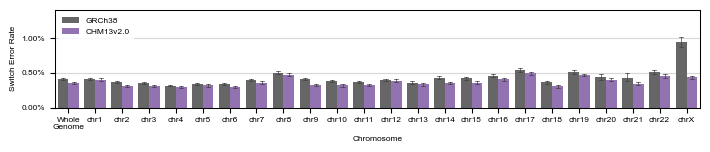

In [10]:
# Figure 3: Per-chromosome error rate performance in CHM13 vs GRCh38, including chrX

all_chroms_plus_chrX = pd.concat((all_chroms_chrX, all_samples.assign(chrom = 'chr1-22+X'))).reset_index(drop=True)

full_panel_HPRC_compared = all_chroms_plus_chrX.loc[ (all_chroms_plus_chrX.method_of_phasing=='phased_with_parents_and_pedigree') &
                                                (all_chroms_plus_chrX.ground_truth_data_source.isin(('HPRC_samples','HGSVC_probands', 'HGSVC_parents', 'HGSVC_samples_nontrios_only')))].replace('chr1-22+X', 'Whole\nGenome')

fig, ax = plt.subplots(1,1,figsize=(two_col,1.5), layout='tight')
sns.barplot(x='chrom', y='switch_error_rate', hue='genome', ax=ax,
            order=[x for x in chrom_order if 'PAR' not in x],
            hue_order=genome_order, palette=genome_palette,
            err_kws={'linewidth':0.5}, capsize=0.3,
            # split=True, inner=None, linewidth=0.5, cut=0, density_norm='area',
            data=full_panel_HPRC_compared.loc[(full_panel_HPRC_compared.ground_truth_data_source=='HPRC_samples')])

ax.set_ylabel('Switch Error Rate')
ax.set_xlabel('Chromosome')
ax.set_ylim(0,full_panel_HPRC_compared.loc[(full_panel_HPRC_compared.ground_truth_data_source=='HPRC_samples')].switch_error_rate.max()*1.08)
legend = ax.legend()
for text in legend.get_texts():
    t = text.get_text()
    new_t = update_legend_values.get(t,t)
    text.set_text(new_t)

sns.move_legend(ax, "upper left")
ax.yaxis.set_major_formatter(PercentFormatter(decimals=2))
ax.grid(axis='y', alpha=0.5)
ax.set_axisbelow(True)
legend.set_title('Genome')
plt.savefig('figures/Figure 3.png', facecolor='white')
plt.savefig('figures/Figure 3.svg', facecolor='white')
plt.savefig('figures/Figure 3.eps', facecolor='white')
plt.savefig('figures/Figure 3.pdf', facecolor='white')

Figure 3: Whole genome and per-chromosome switch error rates from all 100 samples with HPRC or HGSVC assemblies. Error bars show +/- 95% ci.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


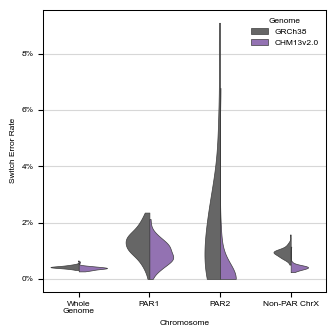

In [11]:
# fig, ax = plt.subplots(1,1,figsize=(one_col,one_col), layout='tight')
fig, ax = plt.subplots(1,1,figsize=(one_col,one_col), layout='tight')
## Supplemental: PAR1, PAR2, chrX
all_chroms_plus = pd.concat((all_chroms, all_samples.assign(chrom = 'chr1-22+X'))).reset_index(drop=True)
all_chroms_plus['chrom'] = all_chroms_plus.chrom.map(lambda x: {'chrX':'Non-PAR ChrX'}.get(x,x))

### PAR is full of outlier samples (think HG01175, with 1 switch error and 2 checked)
all_chroms_plus = all_chroms_plus.loc[all_chroms_plus.n_checked>5]

full_panel_HPRC_compared_sep_chr_X = all_chroms_plus.loc[ (all_chroms_plus.method_of_phasing=='phased_with_parents_and_pedigree') &
                                                (all_chroms_plus.ground_truth_data_source.isin(('HPRC_samples','HGSVC_probands')))].replace('chr1-22+X', 'Whole\nGenome').rename(columns={'genome':"Genome"})

ax = sns.violinplot(x='chrom', y='switch_error_rate', hue='Genome', ax=ax,
            hue_order=genome_order, palette=genome_palette, order=['Whole\nGenome','PAR1','PAR2','Non-PAR ChrX'],
            # err_kws={'linewidth':1}, capsize=0.3,
            split=True, inner=None, linewidth=0.5, cut=0, density_norm='count',
            data=full_panel_HPRC_compared_sep_chr_X.loc[full_panel_HPRC_compared_sep_chr_X.chrom.isin(('PAR1','PAR2','Non-PAR ChrX', 'Whole\nGenome'))],
            legend=True)
# ax.set_ylim(0,2)
ax.set_ylabel('Switch Error Rate')
ax.set_xlabel('Chromosome')
ax.yaxis.set_major_formatter(perc_formatter)
ax.grid(axis='y', alpha=0.5)
ax.set_axisbelow(True)
plt.savefig('figures/supplemental/Supplemental 5.png', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 5.eps', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 5.svg', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 5.pdf', facecolor='white')

Supplemental Figure 5. Whole genome, pseudoautosomal region 1 (PAR1), PAR2, and non-PAR chromosome X switch error rates. 
Switch error rates for trio probands with HPRC or HGSVC assemblies from either the GRCh38 or CHM13v2.0 1KGP reference haplotype panels, with each sample's assembly used as ground truth. PAR switch error rates are calculated seperately from the non-PAR region of chromosome X. Non-PAR chromosome X switch error rates are  only calculated from female samples.

/tmp/ipykernel_2892998/991315246.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_title('Superpopulation')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


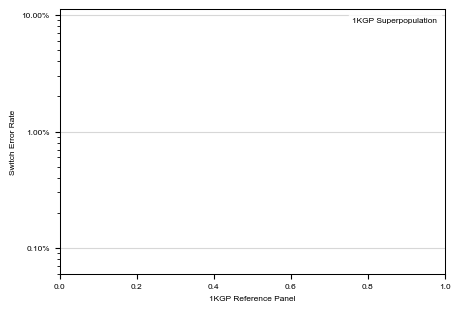

In [12]:
# Supplemental 6: 
superpop_order = ['AFR','EUR','AMR','SAS','EAS']
fig, ax = plt.subplots(1,1,figsize=(oneandahalf_col, 3))
superpop_data = all_samples.loc[(all_samples.method_of_phasing=='phased_with_parents_and_pedigree') &
                                (all_samples.ground_truth_data_source=='trios')].copy()


superpop_data['switch_error_rate'] = superpop_data.n_switch_errors/superpop_data.n_checked * 100
ax.set_yscale('log')
ax = sns.swarmplot(y='switch_error_rate', x='genome', hue='superpopulation', ax=ax,
            data=superpop_data,
            order=genome_order, hue_order=superpop_order, s=1)#             err_kws={'linewidth':0.75}, capsize=0.3)


ax.set_ylabel('Switch Error Rate')
ax.set_xlabel('1KGP Reference Panel')
ax.legend().set_title('Superpopulation')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.grid(axis='y', alpha=0.5)
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(PercentFormatter(decimals=2))
ax.set_ylim(bottom=0.06) # drop three samples in CHM13v2.0 this way.



handles, labels =ax.get_legend_handles_labels()
new_handles=list()
for i, (handle, label) in enumerate(zip(handles, labels)):
    handle.set_alpha(1)
    handle.set_markersize(5)
    new_handles.append(handle)

ax.legend(new_handles, labels, title="1KGP Superpopulation")


plt.savefig('figures/supplemental/Supplemental 6.png', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 6.svg', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 6.eps', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 6.pdf', facecolor='white')
# 22% and 27.3% of points cannot be plotted, always, since they are off the log axis at 0

Supplemental Figure 6. Per sample switch error rates of 1698 samples which are members of family trios. 
Unlike most other measures of switch error rate used in this paper, switch error rate here was measured by mendelian consistency. Each point is the genome-wide switch error rate of one sample from either the GRCh38 or CHM13v2.0 panels. Points are colored by their 1KGP-defined superpopulation membership. The bimodal distribution of the GRCh38 error rates is due to the difference in phasing error between trio parents and probands – the GRCh38 1KGP panel underwent post-HMM error correction in probands only, while the CHM13v2.0 panel underwent pre-HMM trio-based phasing of both parents and probands.


## Figure 4: Switch error rate vs true switch error rate
 - graphic a la slide 12 from ASHG describing the difference between switch errors and flip errors, and why we only really care about true switch errors
 - That graphic will fill the space between the first and second parts of this figure
 - figure outlining per-sample switch error rate, flip rate, and true switch error rate
 - Per-contig true switch error rate
 - Supplementals:
   - Figures describing the relationship between true switch error rate and % of chromosome that is novel
   - Figures describing the relationship between true switch error rate and genotyping error rate (to show that flip errors are more closely tied to switch errors)

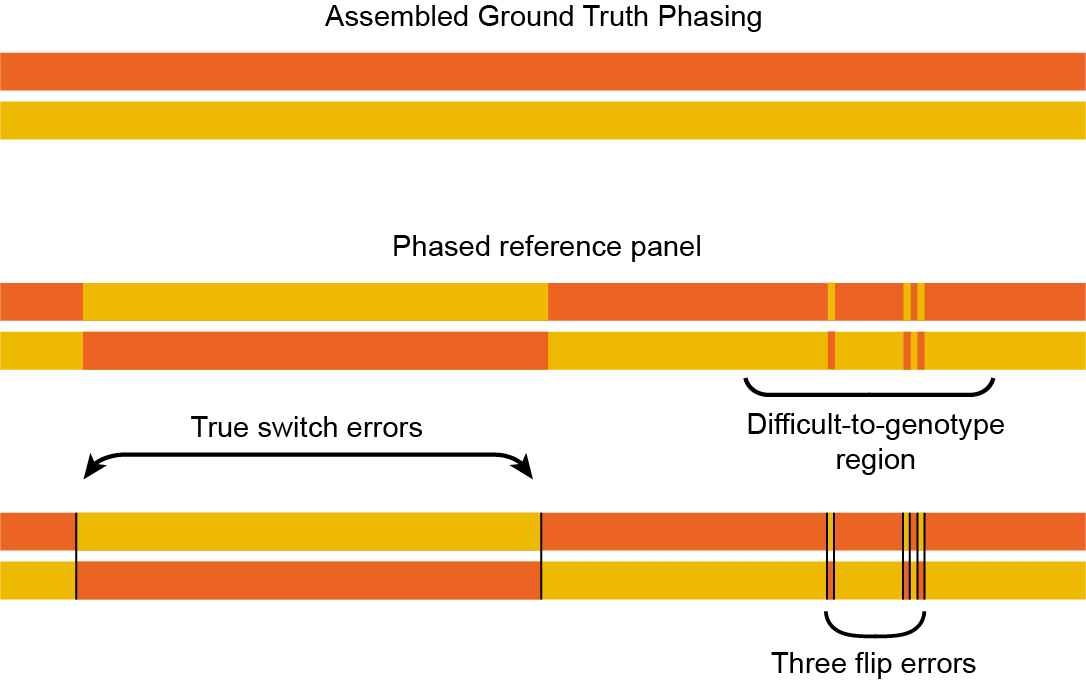

In [14]:
### Figure 4a illustrator image

from IPython.display import Image
Image(filename='figures/Fig 4a.png', width=500)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


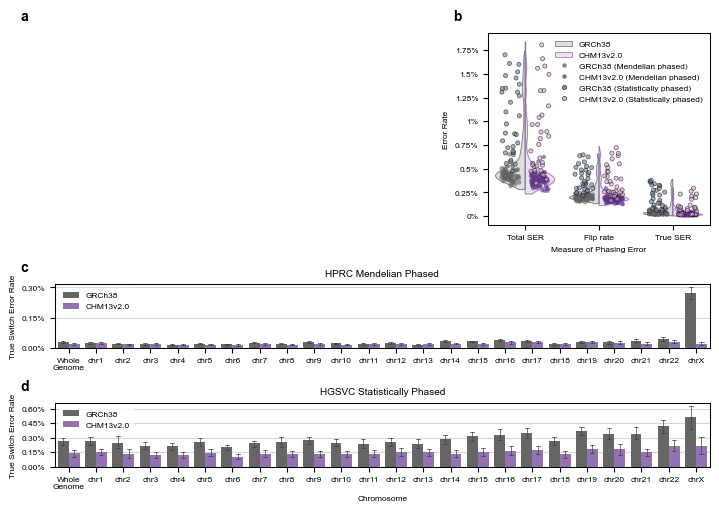

In [15]:
## Figure 4
figure_layout="""
AAABB
AAABB
AAABB
CCCCC
DDDDD
"""
fig, axes = plt.subplot_mosaic(figure_layout, figsize=(two_col, 5))#layout='tight')
axA = axes['A']
axB = axes['B']
axC = axes['C']
axD = axes['D']


## Fig 4b

error_order = ['Total SER', 'Flip rate','True SER']

compare_stats = all_samples.loc[all_samples.ground_truth_data_source.isin(('HPRC_samples','HGSVC_probands','HGSVC_parents','HGSVC_samples_nontrios_only')) &
                                (all_samples.method_of_phasing=='phased_with_parents_and_pedigree')
                               ].rename(columns={'true_switch_error_rate':'True SER', 'flip_error_rate':'Flip rate', 'flip_and_switches_SER':'Total SER', 'genome':'Genome'}
                               ).melt(value_vars=['True SER','Flip rate','Total SER'],
                                       id_vars=['sample_id', 'Genome', 'population', 'superpopulation', 'sex','trio_phased', 'method_of_phasing', 'ground_truth_data_source'],
                                      var_name='Measure of Phasing Error',
                                      value_name='Error Rate')

dot_size=3

sns.violinplot(x='Measure of Phasing Error', y='Error Rate', hue='Genome',
               order = error_order, hue_order=genome_order, palette=genome_palette, linewidth=0.5,
               dodge=True, split=True, cut=0.5, inner=None, density_norm='count', fill=True, alpha=0.2, bw_adjust=.5,
               data = compare_stats, ax=axB, legend=True)
sns.violinplot(x='Measure of Phasing Error', y='Error Rate', hue='Genome',
               order = error_order, hue_order=genome_order, palette=genome_palette, linewidth=0.5,
               dodge=True, split=True, cut=0.5, inner=None, density_norm='count', fill=False, bw_adjust=.5,
               data = compare_stats, ax=axB, legend=False)
sns.stripplot(x='Measure of Phasing Error', y='Error Rate', hue='Genome',
               order = error_order, jitter=0.25, s=dot_size,
               dodge=True, alpha=0.6, linewidth=0.1, palette={'GRCh38':'dimgrey', 'CHM13v2.0':'rebeccapurple'},
               data = compare_stats.loc[compare_stats.trio_phased==True], ax=axB, legend=True)
sns.stripplot(x='Measure of Phasing Error', y='Error Rate', hue='Genome',
               order = error_order, jitter=0.25, s=dot_size,
               dodge=True, alpha=0.6, linewidth=0.5, palette={'GRCh38':'slategrey', 'CHM13v2.0':'plum'},
               data = compare_stats.loc[compare_stats.trio_phased==False], ax=axB, legend=True, edgecolor='black')
axB.yaxis.set_major_formatter(perc_formatter)


#Fig 4c
sns.barplot(x='chrom', y='true_switch_error_rate', hue='genome', ax=axC,
            order=[x for x in chrom_order if 'PAR' not in x],
            hue_order=genome_order, palette=genome_palette,
            err_kws={'linewidth':0.5}, capsize=0.3,
            data=full_panel_HPRC_compared.loc[(full_panel_HPRC_compared.ground_truth_data_source=='HPRC_samples')])

sns.barplot(x='chrom', y='true_switch_error_rate', hue='genome', ax=axD,
            order=[x for x in chrom_order if 'PAR' not in x],
            hue_order=genome_order, palette=genome_palette,
            err_kws={'linewidth':0.5}, capsize=0.3,
            data=full_panel_HPRC_compared.loc[(full_panel_HPRC_compared.ground_truth_data_source=='HGSVC_samples_nontrios_only')])

axC.yaxis.set_major_locator(MultipleLocator(0.15))
axD.yaxis.set_major_locator(MultipleLocator(0.15))

axC.set_xlabel(None)
axD.set_xlabel('Chromosome')
axC.set_title('HPRC Mendelian Phased', pad=6)
axD.set_title('HGSVC Statistically Phased', pad=6)

handles, labels =axB.get_legend_handles_labels()
new_handles=list()
for i, (handle, label) in enumerate(zip(handles, labels)):
    handle.set_alpha(.8)
    if i == 0:
        handle.set_facecolor('#E0E0E0')
        handle.set_edgecolor('#666666')
        handle.set_alpha(1)
    elif i == 1:
        handle.set_facecolor('#E9E3F0')
        handle.set_edgecolor('#9467BD')
        handle.set_alpha(1)
    new_handles.append(handle)

labels = labels[:2] + [l + ' (Mendelian phased)' for l in labels[2:4]] + [l+ ' (Statistically phased)' for l in labels[4:6]]
axB.legend(new_handles,labels)

for ax in [axC, axD]:
    ax.set_ylabel('True Switch Error Rate')
    legend = ax.legend()
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)

    sns.move_legend(ax, "upper left")
    ax.yaxis.set_major_formatter(PercentFormatter(decimals=2))
    ax.grid(axis='y', alpha=0.5)
    ax.set_axisbelow(True)
    legend.set_title('Genome')

for i, ax in enumerate(axes.values()):
    add_letter_to_ax(ax, i)


## Fig 4a - graphic
sns.despine(ax=axA, top=True, right=True, left=True, bottom=True)
axA.set_yticks([])
axA.set_xticks([])
fig
plt.savefig('figures/Figure 4.png', facecolor='white')
plt.savefig('figures/Figure 4.svg', facecolor='white')
plt.savefig('figures/Figure 4.eps', facecolor='white')
plt.savefig('figures/Figure 4.pdf', facecolor='white')


Figure 4: Flip error rates and true switch error rates. a) Throughout this study, we have compared our panel's phasing with ground truth reference assemblies to identify switch errors, defined as sites at which the maternal and paternal haplotypes switch strands. However, regions which are difficult to sequence can often have genotyping errors that result in flip errors, defined as two consecutive switch errors. Unlike true switch errors, flip errors do not impact the phasing accuracy of nearby variants. Eight switch errors are in the illustrated haplotypes, but only two of these are true switch errors - the other six switch errors are part of three flip errors. b) The switch error rate, flip error rate, and true switch error rate of all 100 samples with assembly-based ground truths. Data from the 19 HGSVC individuals that were phased without mendelian error correction are highlighted. Data points are plotted on top of a violin plot showing the overall distribution of error rates. c) Whole genome and per-chromosome true switch error rates from 39 HPRC-assembled samples. d) Whole genome and per-chromosome true switch error rates from 19 HGSVC-assembled samples phased without mendelian error correction.

/home/lalli/.linuxbrew/opt/python@3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/lalli/.linuxbrew/opt/python@3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


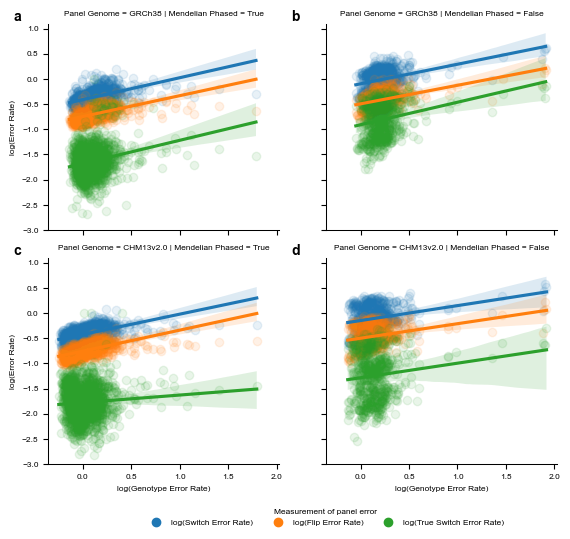

In [16]:
## Supplementals:
## Supplemental 6 - association btwn genotype accuracy and various switch error rates
hprc_evaluated_no_PAR = full_panel_HPRC_compared.loc[full_panel_HPRC_compared.chrom.str.contains('chr') & ~full_panel_HPRC_compared.chrom.str.contains('Whole')].dropna(subset=['true_switch_error_rate'])
hprc_evaluated_no_PAR[['log_switch_error_rate','log_flip_error_rate','log_true_switch_error_rate','log_gt_error_rate']] = np.log10(hprc_evaluated_no_PAR[['switch_error_rate','flip_error_rate','true_switch_error_rate','gt_error_rate']])
hprc_evaluated_no_PAR.loc[hprc_evaluated_no_PAR.log_true_switch_error_rate == -np.inf,'log_true_switch_error_rate'] = 0

def normalize_df(df):
    return ((df-df.min())/(df.max()-df.min())).values

tmp=hprc_evaluated_no_PAR.melt(id_vars=['sample_id','log_gt_error_rate','trio_phased', 'genome'], value_vars=['log_switch_error_rate','log_flip_error_rate','log_true_switch_error_rate'],var_name='error_kind',value_name='log_error_rate')
tmp = tmp.rename(columns={'genome':'Panel Genome', 'trio_phased':'Mendelian Phased','log_gt_error_rate':'log(Genotype Error Rate)', 'error_kind':'Measurement of panel error', 'log_error_rate':'log(Error Rate)'})
tmp = tmp.replace('log_switch_error_rate', 'log(Switch Error Rate)').replace('log_flip_error_rate', 'log(Flip Error Rate)').replace('log_true_switch_error_rate', 'log(True Switch Error Rate)')
height_width_ratio = 0.5; aspect_ratio = 1.15 #(produces a two_col by 5 inch figure, found through trial and error)
g = sns.lmplot(data=tmp, col='Mendelian Phased', row='Panel Genome', col_order=[True, False],
           x='log(Genotype Error Rate)',y='log(Error Rate)',hue='Measurement of panel error', scatter_kws={'alpha':0.1}, units='sample_id', height=5*height_width_ratio, aspect=aspect_ratio)

sns.move_legend(g, loc='upper center', ncols=3, bbox_to_anchor=(.46, 0))


for i, ax in enumerate(list(itertools.chain.from_iterable(g.axes))):
    add_letter_to_ax(ax, i, points_offset=(-25, 0))

g.tight_layout()
for lh in g._legend.legend_handles:
    lh.set_alpha(1)

g.savefig('figures/supplemental/Supplemental 7.svg', facecolor='white')
g.savefig('figures/supplemental/Supplemental 7.png', facecolor='white')
g.savefig('figures/supplemental/Supplemental 7.svg', facecolor='white')
g.savefig('figures/supplemental/Supplemental 7.png', facecolor='white')


Supplemental Figure 7. Association between flip error rate, switch error rate, true switch error rate, and genotyping error rate.
The flip error rate, switch error rate, and true switch error rate was calculated for all chromosomes and all samples for which assembly-based ground truths existed. Genotype error rates were calculated for each chromosome in each sample. Log10 values of each error rate were taken to transform each rate to a gaussian distribution. Linear regression was sequentially performed with the formula log10(Error_Rate) ~ log10(genotype_error_rate), and r2 correlation values were calculated. a) Per chromosome per sample error rates in the GRCh38 haplotype panel for Mendelian error-corrected samples assemblies generated by the HPRC or the HGSVC. b) Per chromosome per sample error rates in the GRCh38 haplotype panel for non-trio samples with HGSVC assemblies that did not undergo mendelian error correction. c) Per chromosome per sample error rates in the CHM13v2.0 haplotype panel for Mendelian error-corrected samples assemblies generated by the HPRC or the HGSVC. d) Per chromosome per sample error rates in the CHM13v2.0 haplotype panel for non-trio samples with HGSVC assemblies that did not undergo mendelian error correction. All regression lines are plotted with a +/- 95% confidence interval. 


In [17]:
grch38_trio_phased_corr = (hprc_evaluated_no_PAR.loc[(hprc_evaluated_no_PAR.trio_phased)&(hprc_evaluated_no_PAR.genome=='GRCh38'),['log_switch_error_rate','log_flip_error_rate','log_true_switch_error_rate','log_gt_error_rate']].corr(method='pearson')**2)[['log_gt_error_rate']].assign(genome='GRCh38', mendelian_phased=True).iloc[:-1]
grch38_stat_phased_corr = (hprc_evaluated_no_PAR.loc[(~hprc_evaluated_no_PAR.trio_phased)&(hprc_evaluated_no_PAR.genome=='GRCh38'),['log_switch_error_rate','log_flip_error_rate','log_true_switch_error_rate','log_gt_error_rate']].corr(method='pearson')**2)[['log_gt_error_rate']].assign(genome='GRCh38', mendelian_phased=False).iloc[:-1]
chm13_trio_phased_corr = (hprc_evaluated_no_PAR.loc[(hprc_evaluated_no_PAR.trio_phased)&(hprc_evaluated_no_PAR.genome=='CHM13v2.0'),['log_switch_error_rate','log_flip_error_rate','log_true_switch_error_rate','log_gt_error_rate']].corr(method='pearson')**2)[['log_gt_error_rate']].assign(genome='CHM13v2.0', mendelian_phased=True).iloc[:-1]
chm13_stat_phased_corr = (hprc_evaluated_no_PAR.loc[(~hprc_evaluated_no_PAR.trio_phased)&(hprc_evaluated_no_PAR.genome=='CHM13v2.0'),['log_switch_error_rate','log_flip_error_rate','log_true_switch_error_rate','log_gt_error_rate']].corr(method='pearson')**2)[['log_gt_error_rate']].assign(genome='CHM13v2.0', mendelian_phased=False).iloc[:-1]

chm13_phased_corr = pd.concat((chm13_stat_phased_corr, chm13_trio_phased_corr)).drop(columns='genome').reset_index().rename(columns={'index':'error_rate'}).set_index(['error_rate','mendelian_phased'])
grch38_phased_corr = pd.concat((grch38_stat_phased_corr, grch38_trio_phased_corr)).drop(columns='genome').reset_index().rename(columns={'index':'error_rate'}).set_index(['error_rate','mendelian_phased'])
error_rate_corr=chm13_phased_corr.join(grch38_phased_corr, lsuffix="_chm13", rsuffix='_grch38').reset_index().rename(columns={'error_rate':'Log error rate','mendelian_phased':'Mendelian-based error correction','log_gt_error_rate_chm13':'CHM13v2.0','log_gt_error_rate_grch38':'GRCh38'})
error_rate_corr = error_rate_corr.replace('log_switch_error_rate','Log(Switch Error Rate)').replace('log_flip_error_rate','Log(Flip Error Rate)').replace('log_true_switch_error_rate','Log(True Switch Error Rate)').set_index(["Log error rate",'Mendelian-based error correction'])

error_rate_corr.reset_index().to_csv('figures/correlation_error_rates_and_gt_error_rate.csv', index=False)

/home/lalli/.linuxbrew/opt/python@3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


GRCh38: $\mathregular{r^2}$=0.32, p=1.9e-22, slope=7.0e-04
CHM13v2.0: $\mathregular{r^2}$=0.14, p=5e-05, slope=3.1e-04
CHM13v2.0 - GRCh38: $\mathregular{r^2}$=0.20, p=4.5e-09, slope=3.9e-04


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


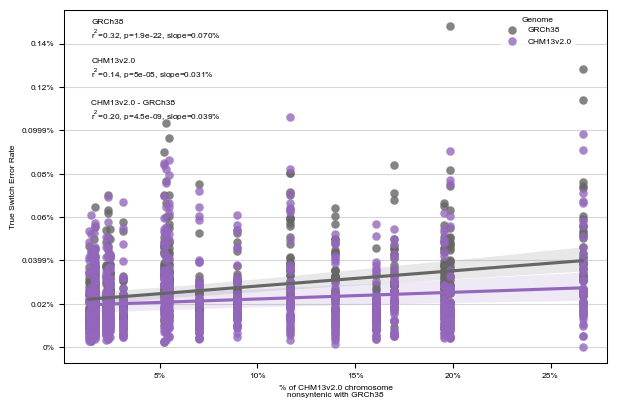

In [18]:
## Supplemental 7: Association with true switch error rate and % of chromosome that's novel
def plot_regression(x, y, hue, data, **kws):
    fig = sns.lmplot(x=x,y=y, hue='genome', data = data, robust=False, palette=default_style['palette'], aspect=1.5, height=4,
                     facet_kws={'legend_out':False}, units='sample_id', **kws)#, x_jitter=0.1)
    ax = fig.ax
    grch = data.loc[data.genome=='GRCh38']
    t2t = data.loc[data.genome=='CHM13v2.0']
    s1, i1, r1, p1, err1 = scipy.stats.linregress(grch[x], grch[y])
    s2, i2, r2, p2, err2 = scipy.stats.linregress(t2t[x], t2t[y])
    s3, i3, r3, p3, err3 = scipy.stats.linregress(grch[x], grch[y].values-t2t[y].values)
    # r2, p2 = stats.pearsonr(t2t[x], t2t[y])
    # r3, p3 = stats.pearsonr(grch[x], grch[y].values-t2t[y].values)
    print ('GRCh38: ' + "$\mathregular{r^2}$" + f"={r1:.2f}, p={p1:.2g}, slope={s1:.1e}")
    print ('CHM13v2.0: ' + "$\mathregular{r^2}$" + f"={r2:.2f}, p={p2:.2g}, slope={s2:.1e}")
    print ('CHM13v2.0 - GRCh38: ' + "$\mathregular{r^2}$" + f"={r3:.2f}, p={p3:.2g}, slope={s3:.1e}")
    ax.text(.05, .96, 'GRCh38',
            transform=ax.transAxes)
    ax.text(.05, .92, "$\mathregular{r^2}$" + f"={r1:.2f}, p={p1:.2g}, slope={s1*100:.3f}%",
            transform=ax.transAxes)
    ax.text(.05, .85, 'CHM13v2.0',
            transform=ax.transAxes)
    ax.text(.05, .81, "$\mathregular{r^2}$" + f"={r2:.2f}, p={p2:.2g}, slope={s2*100:.3f}%",
            transform=ax.transAxes)
    ax.text(.05, .73, 'CHM13v2.0 - GRCh38',
            transform=ax.transAxes)
    ax.text(.05, .69, "$\mathregular{r^2}$" + f"={r3:.2f}, p={p3:.2g}, slope={s3*100:.3f}%",
            transform=ax.transAxes)

    return fig, ax

fg, ax = plot_regression(x='percent_new',y='true_switch_error_rate', hue='genome', data = all_chroms.loc[(all_chroms.method_of_phasing=='phased_with_parents_and_pedigree')
                                                                                                    &(all_chroms.ground_truth_data_source == 'HPRC_samples') &
                                                                                                    ~(all_chroms.chrom.isin(('chrX','PAR1','PAR2')))],
                          scatter_kws={'linewidths':0.1})
# ax.set_ylim(0, .16)
ax.set_ylabel('True Switch Error Rate')
ax.set_xlabel('% of CHM13v2.0 chromosome\nnonsyntenic with GRCh38')
ax.xaxis.set_major_formatter(perc_formatter)
ax.yaxis.set_major_formatter(perc_formatter)
ax.grid(axis='y', alpha=.5)
fg.legend.set_title('Genome')
ax.set_axisbelow(True)
sns.despine(ax=ax, top=False, right=False, left=False, bottom=False)
sns.move_legend(fg, "upper left", bbox_to_anchor=(.8,0.98))

plt.savefig('figures/supplemental/Supplemental 8.svg', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 8.png', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 8.eps', facecolor='white')
plt.savefig('figures/supplemental/Supplemental 8.pdf', facecolor='white')

Supplemental Figure 8: True switch error rate as a function of GRCh38 chromosomal completeness. Scatterplot of all chromosome-wide switch error rate in the GRCh38 and CHM13v2.0 1KGP panels for all chromosomes from HPRC-assembled samples by the percentage of each chromosome that is newly resolved in CHM13v2.0. A linear regression (true_switch_error_rate ~ %_chrom_novel), run separately for each 1KGP panel, is also plotted. Shaded areas indicate 95% ci of the regression slope. A linear regression was also performed of ΔSER% ~ %_chrom_novel. Summary statistics of all three regressions are presented in the upper left corner of the plot.

## Figure 5
### Phasing performance as reference dataset
 - Out of sample confirmations, show 2 figure panels: 
 - (A) most likely use case of Illumina parent data
 - (B) without genotyping error, i.e. pangenome data from parents as ground truth

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


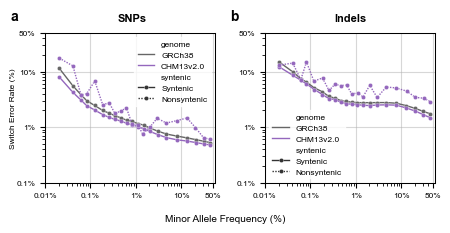

In [19]:
# Figure 5
fig, (axA, axB) = plt.subplots(1,2,figsize=(oneandahalf_col,2.25), layout='tight')
sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HPRC_samples')
                                    & (binned_maf_data.method_of_phasing == '1kgp_variation_phased_with_reference_panel')
                                    & (binned_maf_data.syntenic!='All')
                                    & (binned_maf_data.type=='SNP')],
             legend=True, ax=axA, **syntenic_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='syntenic', hue='genome', hue_order = genome_order, style_order = syntenic_order,
             data=binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HPRC_samples')
                                    & (binned_maf_data.method_of_phasing == '1kgp_variation_phased_with_reference_panel')
                                    & (binned_maf_data.syntenic!='All')
                                    & (binned_maf_data.type=='Indel')],
             legend=True, ax=axB, **syntenic_style)

axA.text(0.6,1.1, 'SNPs', fontsize=8, transform=axA.transAxes, weight='bold', horizontalalignment='right', verticalalignment='center')
axB.text(0.6,1.1, 'Indels', fontsize=8, transform=axB.transAxes, weight='bold', horizontalalignment='right', verticalalignment='center')

for i, ax in enumerate([axA, axB]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-1, 50)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks)
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (2,3):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2):
        ax.set_ylabel('Switch Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)
fig.supxlabel('Minor Allele Frequency (%)')#, labelpad=3)


for i, ax in enumerate([axA, axB]): # legend axes
    if i == 0:
        loc='upper right'
    else:
        loc='upper right'
    # handles, labels = ax.get_legend_handles_labels()
    # for handle in handles:
    #     handle.set_marker('o')
    # handles = handles[1:3] + handles[5:6]
    # labels = labels[1:3] + labels[5:6]
    # try:
    #     handles[-1].set_color(handles[1].get_color())
    # except:
    #     print (handles)
    # legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    # legend.set_title(None)
    # legend.get_frame().set(
    #     alpha=0.9, boxstyle='square', edgecolor='grey', linewidth=0)
    # for text in legend.get_texts():
    #     t = text.get_text()
    #     new_t = update_legend_values.get(t,t)
    #     text.set_text(new_t)
    add_letter_to_ax(ax, i, points_offset=(-25, 7))



plt.savefig('figures/Figure 5.svg', facecolor='white')
plt.savefig('figures/Figure 5.png', facecolor='white')
plt.savefig('figures/Figure 5.pdf', facecolor='white')
plt.savefig('figures/Figure 5.eps', facecolor='white')

Figure 5: Switch error rates of SNPs from samples statistically phased with the 1KGP haplotype panel used as a reference. All HPRC-assembled samples and their relatives were removed from the GRCh38 1KGP and the CHM13v2.0 1KGP panels of 2504 unrelated samples, yielding 'non-HPRC' panels containing data from 2426 individuals. a) Filtered short read derived SNPs from 39 HPRC-assembled individuals were phased, using either the GRCh38 or CHM13v2.0 non-HPRC reference haplotype panel. Switch error rates were measured by mendelian concordance with parental genomes derived from short read variant calls. b) SNPs present in the HPRC human pangenome were unphased, then statistically phased with either the GRCh38 or CHM13v2.0 non-HPRC reference haplotype panel. Switch error rates were measured using the pangenome haplotypes as ground truth. Switch error rates and average minor allele frequency per bin are displayed on a log scale.

# Figure 6
Ideograms
see R script

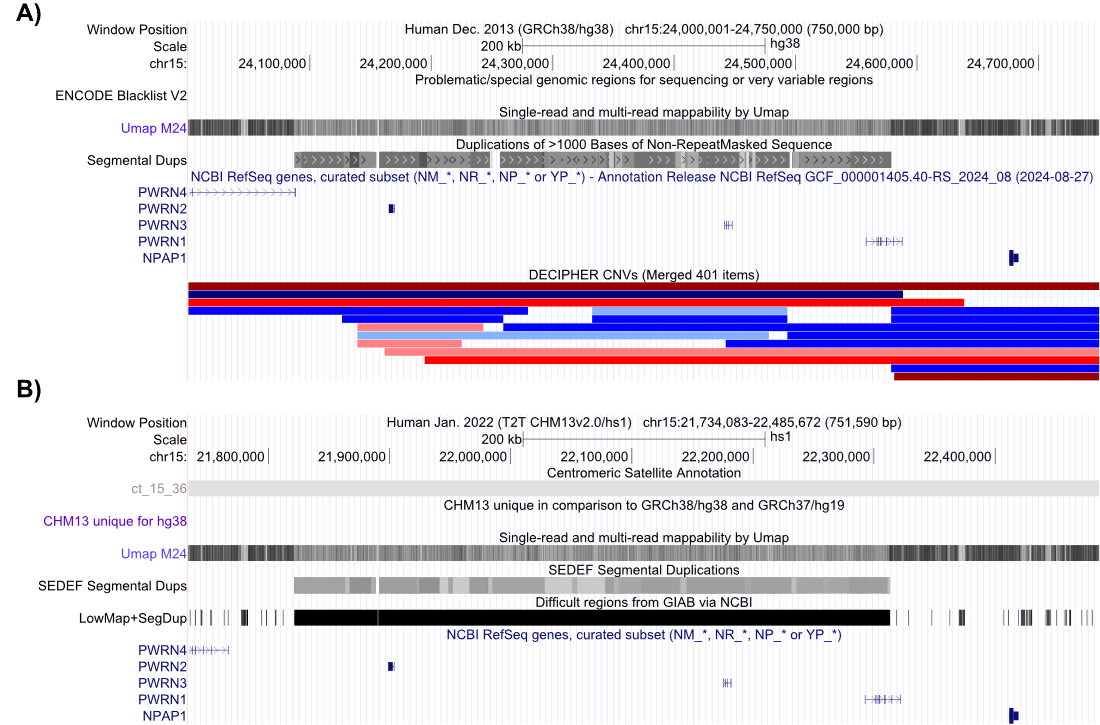

Supplemental Figure 9. UCSC Genome Browser information on mappability of a region near the Prader-Willi breakpoint 2 (roughly chr15:24100000-24600000) that is enriched for genetic variants in the GRCh38 phased genomic panel. a) Mappability, blacklist status, location of segmental duplications, and genic regions in GRCh38. b) Mappability, location of segmental duplications, “difficult region” status from GIAB, and genic regions in CHM13v2.0.

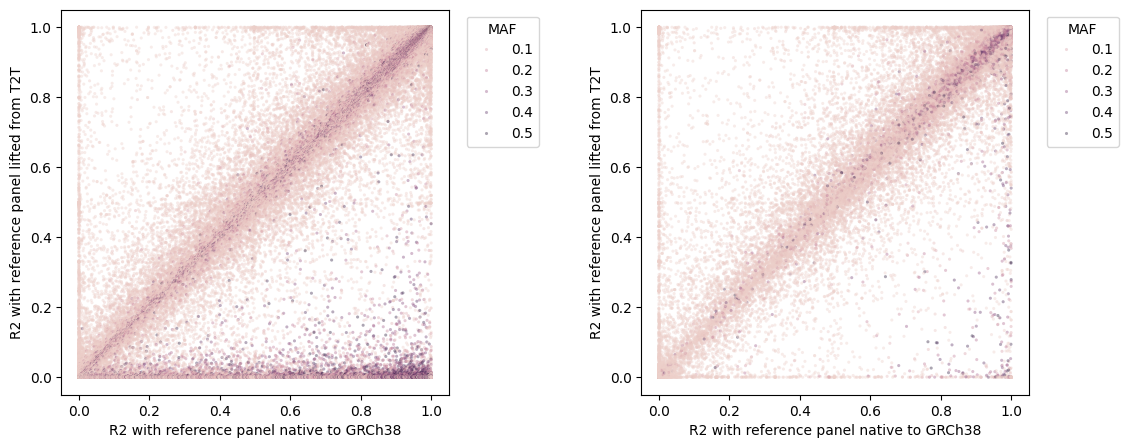

Supplemental Figure 10. Improved liftover algorithm results in better imputation of common indel variants. a) Scatter plot of the r2 value of imputed indel variants when using a GRCh38 1KGP reference panel (x-axis) or the CHM13v2.0 panel lifted to GRCh38 coordinates using either a) GATK LiftoverVCF or b) the modified liftover algorithm implemented in this paper. Manual inspection of the high MAF variants that were poorly called by the lifted-over CHM13v2.0 panel showed that the majority of these variants are short tandem repeats that are lifted to a site that is several bases away from the same variant in the 1KGP GRCh38-native variant callset. Each dot represents one biallelic indel. The panel minor allele frequency (defined as 1-AF) is colored by 1KGP GRCh38 MAF.

## Figure 7
### Imputation performance as reference dataset
 - plots as I currently have them
 - Supplement: Breakdown of performance by population

/home/lalli/.linuxbrew/opt/python@3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


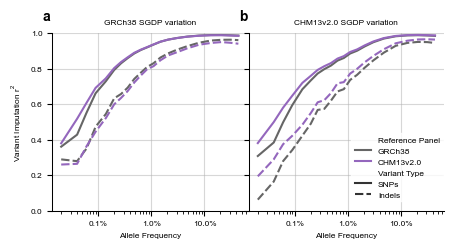

In [20]:
# Figure 7
genome_order = ['GRCh38','CHM13v2.0']
panel_order=['native_panel.common_variants','lifted_panel.common_variants']
separate_panel_and_subset=pd.concat(((per_variant_category_imputation_performance.loc[per_variant_category_imputation_performance.panel.str.contains('common')]
                                     											.assign(var_subset='Common variants')
                                                                                .replace('native_panel.common_variants', 'Native')
                                                                                .replace('lifted_panel.common_variants', 'Lifted')),
                                    (per_variant_category_imputation_performance.loc[~per_variant_category_imputation_performance.panel.str.contains('common')]
                                     											.assign(var_subset='All panel variants')
                                                                                .replace('native_panel','Native')
                                                                                .replace('lifted_panel','Lifted'))))

separate_panel_and_subset = separate_panel_and_subset.rename(columns={'var_category_id':'Variant Type'}).replace('CHM13','CHM13v2.0')
separate_panel_and_subset['Reference Panel'] = 'GRCh38'
separate_panel_and_subset.loc[((separate_panel_and_subset.genome=='GRCh38') & (separate_panel_and_subset.panel=='Lifted')) |
                              ((separate_panel_and_subset.genome=='CHM13v2.0') & (separate_panel_and_subset.panel=='Native')), 'Reference Panel'] = 'CHM13v2.0'
# fig=sns.relplot(kind='line', data = separate_panel_and_subset.loc[(separate_panel_and_subset.Synteny == 'All')#|(per_variant_category_imputation_performance.genome=='CHM13v2.0'))
#                                                                 #  & (separate_panel_and_subset['var_subset']=='Common variants')
#                                                                   & (separate_panel_and_subset.ancestry=='all')
#                                                                   &  (separate_panel_and_subset.dataset=='SGDP')],
#                 x='mean_AF',y='imputed_ds_rsquared', hue='Reference Panel', style='Variant Type', hue_order=['GRCh38','CHM13v2.0'], style_order=['SNPs','Indels'],#style_order=['All variants','Indels','SNPs'],
#                 palette=default_style['palette'], col='var_subset', row='genome', height=4, aspect=1, row_order=['GRCh38','CHM13v2.0']), #, col_wrap=4)#, , height=3, aspect=1, palette=None, row_order=None, col_order=None, hue_order=None, hue_kws=None, dropna=False, legend_out=True, despine=True, margin_titles=False, xlim=None, ylim=None, subplot_kws=None, gridspec_kws=None)

fig=sns.relplot(kind='line', data = separate_panel_and_subset.loc[(separate_panel_and_subset.Synteny == 'All')#|(per_variant_category_imputation_performance.genome=='CHM13v2.0'))
                                                                 & (separate_panel_and_subset['var_subset']=='Common variants')
                                                                  & (separate_panel_and_subset.ancestry=='all')
                                                                  &  (separate_panel_and_subset.dataset=='SGDP')],
                x='mean_AF',y='imputed_ds_rsquared', hue='Reference Panel', style='Variant Type', hue_order=['GRCh38','CHM13v2.0'], style_order=['SNPs','Indels'],#style_order=['All variants','Indels','SNPs'],
                palette=default_style['palette'], col='genome', height=6, aspect=1, col_order=['GRCh38','CHM13v2.0']), #, col_wrap=4)#, , height=3, aspect=1, palette=None, row_order=None, col_order=None, hue_order=None, hue_kws=None, dropna=False, legend_out=True, despine=True, margin_titles=False, xlim=None, ylim=None, subplot_kws=None, gridspec_kws=None)
fig = (fig[0].set(xscale='log', ylim=(0,1))
  .set_axis_labels("Allele Frequency", "Variant Imputation $\mathregular{r^2}$")
  .set_titles(template="{col_name} SGDP variation")
  .tight_layout(w_pad=0)
  )
fig.legend.set_frame_on(True)
fig.figure.set_size_inches((oneandahalf_col,2))

for col_val, ax in fig.axes_dict.items():
    ax.xaxis.set_major_formatter(PercentFormatter(decimals=1))
    ax.grid(alpha=0.5)
sns.move_legend(fig.figure, "lower right", bbox_to_anchor=(.92, .1))

for i, ax in enumerate(list(itertools.chain.from_iterable(fig.axes))):
    add_letter_to_ax(ax, i, points_offset=(-7, 7))


plt.savefig('figures/Figure 7.png', facecolor='white', bbox_inches='tight')
plt.savefig('figures/Figure 7.svg', facecolor='white', bbox_inches='tight')
plt.savefig('figures/Figure 7.eps', facecolor='white', bbox_inches='tight')
plt.savefig('figures/Figure 7.pdf', facecolor='white', bbox_inches='tight')



Figure 6: Imputation of genomic variation in 256 non-1KGP Human Genome Diversity Project (HGDP) samples, using 1KGP haplotype panels as references. a) Genotyping array data was simulated by downsampling variation derived from short reads aligned to GRCh38 were downsampled to those variants present in the Infinium Omni2.5 genotyping array. We then phased this 'array' variation and imputed missing variants. At both steps, we provided a set of reference haplotypes to guide phasing and imputation - either the GRCh38 haplotype panel, or the CHM13v2.0 panel lifted to GRCh38 coordinates. R2 values were calculated using variants that were imputed by both the GRCh38 and the CHM13 panels. b) We downsampled variation by intersecting the Infinium Omni2.5 genotyping array variation (this time in CHM13v2.0 coordinates) with HGDP variation called form short reads aligned to CHM13v2.0. We then phased and imputed these samples using either the 1KGP CHM13v2.0 reference haplotype panel, or the 1KGP GRCh38 reference panel lifted to GRCh38 coordinates. All imputed variants were binned by the minor allele frequency of the variant in the reference panel used during imputation. R2 values were then calculated per bin. For both panels, R2 values were calculated using variants that were present in both the GRCh38-informed imputed variant data and the CHM13v2.0-informed imputed variant data. R2 statistics are stratified by SNPs and Indels. Average minor allele frequency per bin is displayed on a log scale.

/tmp/ipykernel_2892998/3955385878.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


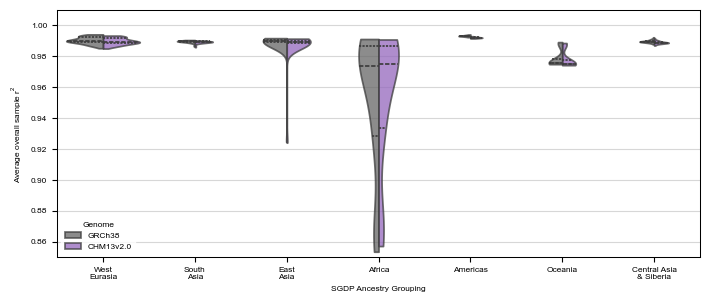

In [21]:
# Figure 8 supplements
fig, ax = plt.subplots(1,1,figsize=(two_col,3), layout='tight')


separate_sample_panel_and_subset=pd.concat(((per_sample_imputation_performance.loc[per_sample_imputation_performance.panel.str.contains('common')]
                                     											.assign(var_subset='Common variants')
                                                                                .replace('native_panel.common_variants', 'Native')
                                                                                .replace('lifted_panel.common_variants', 'Lifted')),
                                    (per_sample_imputation_performance.loc[~per_sample_imputation_performance.panel.str.contains('common')]
                                     											.assign(var_subset='All panel variants')
                                                                                .replace('native_panel','Native')
                                                                                .replace('lifted_panel','Lifted'))))

separate_sample_panel_and_subset = separate_sample_panel_and_subset.rename(columns={'var_category_id':'Variant Type'}).replace('CHM13','CHM13v2.0')
separate_sample_panel_and_subset['Reference Panel'] = 'GRCh38'
separate_sample_panel_and_subset.loc[((separate_sample_panel_and_subset.genome=='GRCh38') & (separate_sample_panel_and_subset.panel=='Lifted')) |
                              ((separate_sample_panel_and_subset.genome=='CHM13v2.0') & (separate_sample_panel_and_subset.panel=='Native')), 'Reference Panel'] = 'CHM13v2.0'


ax = sns.violinplot(x='ancestry', y='imputed_ds_rsquared', hue='Reference Panel', ax=ax,
                 hue_order=genome_order, palette=genome_palette, #s=4,
                 data=separate_sample_panel_and_subset.loc[(separate_sample_panel_and_subset.dataset=='SGDP')
                                      &(separate_sample_panel_and_subset.var_subset=='Common variants')
                                      & (separate_sample_panel_and_subset['Variant Type']=='SNPs')
                                      & (separate_sample_panel_and_subset.genome=='GRCh38')
                                      & (separate_sample_panel_and_subset.ancestry != 'all')],
                 legend=True, alpha=0.75, split=True, density_norm='count', cut=0, gap=0, inner='quart', saturation=1)


formatted_ancestry_names = {'all':'All\npopulations','WestEurasia':'West\nEurasia','SouthAsia':"South\nAsia",
                            'EastAsia':'East\nAsia','Africa':'Africa', 'America':'Americas','Oceania':'Oceania',
                            'CentralAsiaSiberia':'Central Asia\n& Siberia'}

xticks = list(ax.get_xticklabels())
for tick in xticks:
    t = tick.get_text()
    tick.set_text(formatted_ancestry_names.get(t, t))
ax.set_xticklabels(xticks)

ax.set_ylim(0.85,1.01)

legend = ax.legend()
for text in legend.get_texts():
    t = text.get_text()
    new_t = update_legend_values.get(t,t)
    text.set_text(new_t)
legend.set_title('Genome') # This shouldn't be necessary, but it is and I don't really care to dig into why
sns.move_legend(ax, "lower left")#, bbox_to_anchor=(1, 0))

ax.set_ylabel('Average overall sample $\mathregular{r^2}$')
ax.set_xlabel('SGDP Ancestry Grouping')
ax.grid(axis='y', alpha=.5)
ax.set_axisbelow(True)
# sns.despine()
plt.savefig('figures/supplemental/supplemental 11.png', facecolor='white')
plt.savefig('figures/supplemental/supplemental 11.svg', facecolor='white')
plt.savefig('figures/supplemental/supplemental 11.eps', facecolor='white')
plt.savefig('figures/supplemental/supplemental 11.pdf', facecolor='white')

Supplemental Figure 10: A violin plot displaying the distribution of overall per-sample r2 values when imputing GRCh38 SGDP variation, stratified by SGDP-defined sample ancestry. Distributions are split by reference panel used during imputation: either the Byrska-Bishop 2022 GRCh38 reference haplotype panel, or the CHM13v2.0 panel lifted over to GRCh38 coordinates.

/tmp/ipykernel_2892998/854782898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_pop_data['ancestry'] = per_pop_data.ancestry.map(lambda x: formatted_ancestry_names.get(x,x).replace('\n',' '))
/home/lalli/.linuxbrew/opt/python@3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


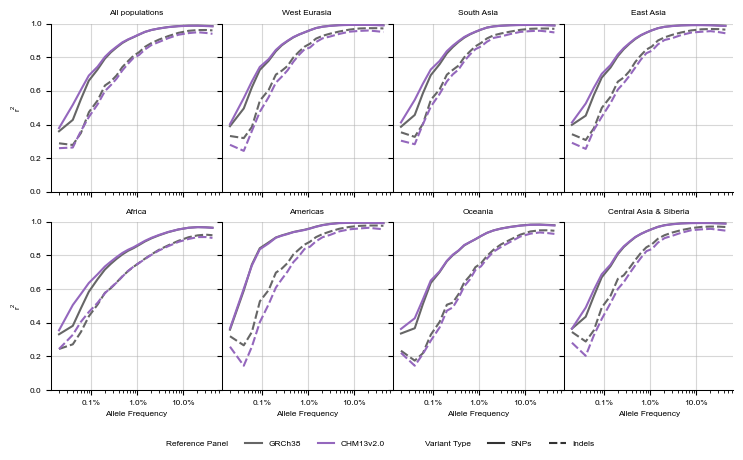

In [22]:
per_pop_data = separate_panel_and_subset.loc[(separate_panel_and_subset.Synteny == 'All')#|(per_variant_category_imputation_performance.genome=='CHM13v2.0'))
                                                                 & (separate_panel_and_subset['var_subset']=='Common variants')
                                                                  &  (separate_panel_and_subset.dataset=='SGDP')
                                                                  & (separate_panel_and_subset.genome=='GRCh38')]
per_pop_data['ancestry'] = per_pop_data.ancestry.map(lambda x: formatted_ancestry_names.get(x,x).replace('\n',' '))
panel_order=['native.common_variants','lifted.common_variants']
fig=sns.relplot(kind='line', data = per_pop_data,
                x='mean_AF',y='imputed_ds_rsquared', hue='Reference Panel', style='Variant Type', hue_order=['GRCh38','CHM13v2.0'], style_order=['SNPs','Indels'],#style_order=['All variants','Indels','SNPs'],
                errorbar=None, palette=default_style['palette'], col='ancestry', height=4, aspect=1, col_wrap=4,facet_kws=dict(legend_out=False))
#, sharex=True, sharey=True, height=3, aspect=1, palette=None, row_order=None, col_order=None, hue_order=None, hue_kws=None, dropna=False, legend_out=True, despine=True, margin_titles=False, xlim=None, ylim=None, subplot_kws=None, gridspec_kws=None)
  # .set_ylabel('Average overall sample $\mathregular{r^2}$')
fig.figure.set_tight_layout(True)

(fig.set(xscale='log')
  .set_axis_labels("Allele Frequency", "$\mathregular{r^2}$")
  .set_titles("{col_name}")
  .tight_layout(w_pad=0,h_pad=5))
fig.figure.set_size_inches((two_col,4))

for col_val, ax in fig.axes_dict.items():
    ax.xaxis.set_major_formatter(PercentFormatter(decimals=1))
    ax.grid(alpha=0.5)
    ax.set_ylim(0,1)

sns.move_legend(
    fig, "upper center",
    bbox_to_anchor=(.48, -0.05), ncol=6, title=None, frameon=False
)

fig.savefig('figures/supplemental/Supplemental 12.svg', facecolor='white',bbox_inches='tight')
fig.savefig('figures/supplemental/Supplemental 12.png', facecolor='white',bbox_inches='tight')
fig.savefig('figures/supplemental/Supplemental 12.eps', facecolor='white',bbox_inches='tight')
fig.savefig('figures/supplemental/Supplemental 12.pdf', facecolor='white',bbox_inches='tight')


Supplemental Figure 9:  Imputation of 256 non-1KGP HGDP genetic variation using 1KGP haplotype panels as references, stratified by SGDP population of origin. As previously presented, genotyping array data was simulated by downsampling variation derived from short reads aligned to GRCh38 were downsampled to those variants present in the Infinium Omni2.5 genotyping array. Variants present in our callset and in the genotyping array were then phased and imputed using either the GRCh38 1KGP haplotype panel, or the CHM13v2.0 1KGP panel lifted to GRCh38 coordinates. R2 values were calculated from the intersection of variants that were in both callsets. R2 statistics were calculated from imputed variants in samples assigned by the SGDP to the indicated ancestry group. R2 values were separately calculated in SNP variation and Indel variation. Average minor allele frequency per bin is displayed on a log scale.

## Table 2
 - top 15 most different cytobands from GRCh38 to CHM13
 - Per band stats to present:
   - GRCh38 switch errors, n_checked, and SER
   - T2T switch errors, n_checked, and SER
   - absolute reduction in SER
 - Export as csv, copy/paste into work

In [23]:
cyto = pd.read_parquet(f"{intermediate_data_folder}/per_cytoband_variant_data.parquet")
cnv = pd.read_parquet(f"{intermediate_data_folder}/per_genome_cnv_regions.parquet")
cnvslop = pd.read_parquet(f"{intermediate_data_folder}/per_genome_cnv_regions_with_slop.parquet")

def concat_overlapping_sydromes(df):
    df['Syndrome'] = df['Syndrome'] + '/'
    df = df.groupby(['n_switch_errors', 'n_checked', 'n_gt_errors', 'n_gt_checked', 'method_of_phasing', 'ground_truth_data_source', 'genome', 'MAC', 'AN', 'start', 'end', 'switch_error_rate']).sum()
    df['Syndrome'] = df['Syndrome'].str[:-1]
    return df.reset_index()

cnv = concat_overlapping_sydromes(cnv)
cnvslop = concat_overlapping_sydromes(cnvslop)

decipher_cnvs = pd.read_csv('resources/decipher_syndromes.txt', sep='\t')
decipher_cnvs.loc[decipher_cnvs.end_grch38 < decipher_cnvs.start_grch38, ['start_grch38','end_grch38']] = decipher_cnvs.loc[decipher_cnvs.end_grch38 < decipher_cnvs.start_grch38, ['end_grch38','start_grch38']].values
decipher_cnvs.loc[decipher_cnvs.end_chm13 < decipher_cnvs.start_chm13, ['start_chm13','end_chm13']] = decipher_cnvs.loc[decipher_cnvs.end_chm13 < decipher_cnvs.start_chm13, ['end_chm13','start_chm13']].values
decipher_band_annotation = decipher_cnvs.drop(columns=[x for x in decipher_cnvs.columns if 'start' in x or 'end' in x])
decipher_band_annotation['cytoband'] = decipher_band_annotation.cytoband.str.split(',')
decipher_band_annotation = decipher_band_annotation.explode('cytoband').reset_index(drop=True)

cyto['interval'] = cyto.chrom.str.replace('chr','') + cyto['interval'].astype(str)
cyto['decipher'] = cyto.interval.isin(decipher_band_annotation.cytoband)

cyto['switch_error_rate'] = cyto.n_switch_errors/cyto.n_checked * 100
cyto['genotype_error_rate'] = cyto.n_gt_errors/cyto.n_gt_checked * 100

cnv['switch_error_rate'] = cnv.n_switch_errors/cnv.n_checked * 100
cnv['genotype_error_rate'] = cnv.n_gt_errors/cnv.n_gt_checked* 100

cnvslop['switch_error_rate'] = cnvslop.n_switch_errors/cnvslop.n_checked * 100
cnvslop['genotype_error_rate'] = cnvslop.n_gt_errors/cnvslop.n_gt_checked * 100

merge_columns=['method_of_phasing','ground_truth_data_source','chrom','interval']

cyto_grch38 = cyto.loc[cyto.genome=='GRCh38']
cyto_chm13 = cyto.loc[cyto.genome=='CHM13v2.0']
cnv_grch38 = cnv.loc[cnv.genome=='GRCh38']
cnv_chm13 = cnv.loc[cnv.genome=='CHM13v2.0']
cnvslop_grch38 = cnvslop.loc[cnvslop.genome=='GRCh38']
cnvslop_chm13 = cnvslop.loc[cnvslop.genome=='CHM13v2.0']

cyto = cyto_grch38.merge(cyto_chm13, on=['method_of_phasing','ground_truth_data_source','chrom','interval','decipher'], suffixes=['_grch38','_chm13'])
cnv = cnv_grch38.merge(cnv_chm13, on=['method_of_phasing','ground_truth_data_source','Syndrome'], how='outer', suffixes=('_grch38', '_chm13'))
cnvslop = cnvslop_grch38.merge(cnvslop_chm13, on=['method_of_phasing','ground_truth_data_source','Syndrome'], how='outer', suffixes=('_grch38', '_chm13'))

cyto['abs_diff_SER'] = cyto.switch_error_rate_grch38.fillna(0) - cyto.switch_error_rate_chm13.fillna(0)
cnv['abs_diff_SER'] = cnv.switch_error_rate_grch38.fillna(0) - cnv.switch_error_rate_chm13.fillna(0)
cnvslop['abs_diff_SER'] = cnvslop.switch_error_rate_grch38.fillna(0) - cnvslop.switch_error_rate_chm13.fillna(0)

cyto['rel_drop_SER'] = (1- (cyto.switch_error_rate_chm13.fillna(0) / cyto.switch_error_rate_grch38.fillna(0))) * 100
cnv['rel_drop_SER'] = (1- (cnv.switch_error_rate_chm13.fillna(0) / cnv.switch_error_rate_grch38.fillna(0))) * 100
cnvslop['rel_drop_SER'] = (1- (cnvslop.switch_error_rate_chm13.fillna(0) / cnvslop.switch_error_rate_grch38.fillna(0))) * 100

cyto['abs_diff_GER'] = cyto.genotype_error_rate_grch38.fillna(0) - cyto.genotype_error_rate_chm13.fillna(0)
cnv['abs_diff_GER'] = cnv.genotype_error_rate_grch38.fillna(0) - cnv.genotype_error_rate_chm13.fillna(0)
cnvslop['abs_diff_GER'] = cnvslop.genotype_error_rate_grch38.fillna(0) - cnvslop.genotype_error_rate_chm13.fillna(0)

cyto['rel_drop_GER'] = (1- (cyto.genotype_error_rate_chm13.fillna(0) / cyto.genotype_error_rate_grch38.fillna(0))) * 100
cnv['rel_drop_GER'] = (1- (cnv.genotype_error_rate_chm13.fillna(0) / cnv.genotype_error_rate_grch38.fillna(0))) * 100
cnvslop['rel_drop_GER'] = (1- (cnvslop.genotype_error_rate_chm13.fillna(0) / cnvslop.genotype_error_rate_grch38.fillna(0))) * 100

In [24]:
filtered_cyto = cyto.loc[(cyto.method_of_phasing=='1kgp_variation_phased_with_reference_panel')&(cyto.ground_truth_data_source=='HPRC_samples')&(cyto.n_checked_grch38 > 50)&(cyto.n_checked_chm13 > 50),
        ['interval','n_switch_errors_grch38','n_switch_errors_chm13','n_checked_grch38','n_checked_chm13','switch_error_rate_grch38','switch_error_rate_chm13',
         'n_gt_checked_grch38','n_gt_checked_chm13','genotype_error_rate_grch38','genotype_error_rate_chm13',
         'abs_diff_GER','rel_drop_GER','abs_diff_SER','rel_drop_SER', 'decipher']
         ].sort_values('rel_drop_SER',ascending=False).reset_index(drop=True)
filtered_cyto.to_csv('tables/1kgp_variation_HPRC_ground_truth_summarized.tsv', sep='\t', index=False)


cyto.loc[(cyto.method_of_phasing=='1kgp_variation_phased_with_reference_panel')&(cyto.ground_truth_data_source=='HPRC_samples')
         ].sort_values('rel_drop_SER',ascending=False).reset_index(drop=True).to_csv('tables/1kgp_variation_HPRC_ground_truth.tsv', sep='\t', index=False)
cyto.loc[(cyto.method_of_phasing=='1kgp_variation_phased_with_reference_panel')&(cyto.ground_truth_data_source=='trios')
         ].sort_values('rel_drop_SER',ascending=False).reset_index(drop=True).to_csv('tables/1kgp_variation_parental_haplotypes_ground_truth.tsv', sep='\t', index=False)



In [25]:
from tqdm import trange
def calculate_es(gene_list, ranked_genes, gene_set, weights):
    """
    Calculates the enrichment score (ES) for a gene set within a ranked list of genes.

    Args:
        gene_list (list): A list of all genes considered in the analysis.
        ranked_genes (list): A ranked list of genes, e.g., by differential expression.
        gene_set (list): A list of genes belonging to the gene set of interest.

    Returns:
        float: The enrichment score (ES).
    """
    N = len(gene_list)
    Nh = len(gene_set)
    ES = 0
    running_sum = 0
    tag_indicator = np.isin(ranked_genes, gene_set)
    rank_list_indicator = ~tag_indicator
    
    for i, tag in enumerate(tag_indicator):
      if tag:
        running_sum += np.sqrt((N - Nh)/Nh) * weights[i]
      else:
        running_sum -= np.sqrt(Nh/(N - Nh)) * weights[i]
      
      if running_sum > ES:
        ES = running_sum
    
    return ES


filtered_cyto = filtered_cyto.sort_values('rel_drop_SER', ascending=False)
gene_list = filtered_cyto.interval.to_list()
weights = filtered_cyto.rel_drop_SER.to_list()
true_gene_set = filtered_cyto.loc[filtered_cyto.decipher].interval.to_list()
true_es = calculate_es(gene_list, gene_list, true_gene_set, weights=weights)
permuted_es = list()

for i in trange(100000):
    gene_set = filtered_cyto.interval.sample(len(true_gene_set), replace=False, random_state=np.random.seed(42*i))
    permuted_es.append(calculate_es(gene_list, gene_list, gene_set, weights=weights))

permuted_es = np.array(permuted_es)
print(f"Weighted enrichment score of {true_es} (pval < {np.mean(permuted_es>true_es)})")

# weighted enrichment score w/ permutation


100%|██████████| 100000/100000 [08:15<00:00, 201.93it/s]


Weighted enrichment score of 858.9571296115195 (pval < 0.00452)


In [26]:
from tqdm import trange
def calculate_es(gene_list, ranked_genes, gene_set):
    """
    Calculates the enrichment score (ES) for a gene set within a ranked list of genes.

    Args:
        gene_list (list): A list of all genes considered in the analysis.
        ranked_genes (list): A ranked list of genes, e.g., by differential expression.
        gene_set (list): A list of genes belonging to the gene set of interest.

    Returns:
        float: The enrichment score (ES).
    """
    N = len(gene_list)
    Nh = len(gene_set)
    ES = 0
    running_sum = 0
    tag_indicator = np.isin(ranked_genes, gene_set)
    
    for tag in tag_indicator:
      if tag:
        running_sum += np.sqrt((N - Nh)/Nh)
      else:
        running_sum -= np.sqrt(Nh/(N - Nh))
      
      if abs(running_sum) > abs(ES):
        ES = running_sum
    
    return ES


filtered_cyto = filtered_cyto.sort_values('rel_drop_SER', ascending=False)
gene_list = filtered_cyto.interval.drop_duplicates().to_list()
true_gene_set = filtered_cyto.loc[filtered_cyto.decipher].interval.drop_duplicates().to_list()
true_es = calculate_es(gene_list, gene_list, true_gene_set)
permuted_es = list()

for i in trange(100000):
    gene_set = filtered_cyto.interval.sample(len(true_gene_set), replace=False, random_state=42)
    permuted_es.append(calculate_es(gene_list, gene_list, gene_set))

permuted_es = np.array(permuted_es)
np.mean(permuted_es>true_es)
print(f"Unweighted enrichment score of {true_es} (pval < {np.mean(permuted_es>true_es)})")


100%|██████████| 100000/100000 [10:04<00:00, 165.36it/s]

Unweighted enrichment score of 31.754264805429546 (pval < 0.0)


/tmp/ipykernel_2892998/1003454266.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=filtered_cyto.loc[filtered_cyto.abs_diff_SER<1], x='decipher', y='abs_diff_SER', ax=ax, fill=False, flierprops={"marker": "None"}, linewidth=0.5, palette=['black'], legend=True)
/tmp/ipykernel_2892998/1003454266.py:3: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(data=filtered_cyto.loc[filtered_cyto.abs_diff_SER<1], x='decipher', y='abs_diff_SER', ax=ax, fill=False, flierprops={"marker": "None"}, linewidth=0.5, palette=['black'], legend=True)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.445e-01 U_stat=1.425e+04


Text(0.5, 10.166999999999996, 'Cytology band does/does not contain\na Decipher common CNV syndrome')

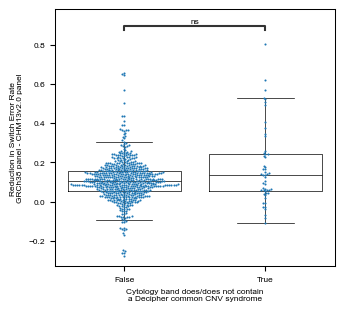

In [27]:
fig, ax = plt.subplots(1,1,figsize=(3.33,3))
ax = sns.swarmplot(data=filtered_cyto.loc[filtered_cyto.abs_diff_SER<1], x='decipher', y='abs_diff_SER',dodge=True, s=1.5, legend=False)
ax = sns.boxplot(data=filtered_cyto.loc[filtered_cyto.abs_diff_SER<1], x='decipher', y='abs_diff_SER', ax=ax, fill=False, flierprops={"marker": "None"}, linewidth=0.5, palette=['black'], legend=True)

from statannotations.stats.StatTest import StatTest
def kstest(x, y):
    return stats.kstest(x, y)
custom_test = StatTest(kstest, 'Kolmogorov-Smirnov (KS) non-parametric test', 'kstest')

annotator = Annotator(ax, [(False, True)], data=filtered_cyto, x='decipher', order=(False,True), y='abs_diff_SER')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

ax.set_ylabel('Reduction in Switch Error Rate\nGRCh38 panel - CHM13v2.0 panel')
ax.set_xlabel('Cytology band does/does not contain\na Decipher common CNV syndrome')

^Bootstrap: how ofted do you see diff_SER in randomly selected 63 regions (w/ replacement) vs decipher regions

In [28]:
cnv_clean = cnv.loc[(cnv.method_of_phasing=='1kgp_variation_phased_with_reference_panel')&(cnv.ground_truth_data_source=='HPRC_samples'),
                            ['Syndrome','n_switch_errors_grch38','n_switch_errors_chm13','n_checked_grch38','n_checked_chm13','switch_error_rate_grch38','switch_error_rate_chm13',
                            'n_gt_checked_grch38','n_gt_checked_chm13','genotype_error_rate_grch38','genotype_error_rate_chm13',
                            'abs_diff_GER','rel_drop_GER','abs_diff_SER','rel_drop_SER']
                    ].sort_values('rel_drop_SER',ascending=False).reset_index(drop=True)
cnv_clean.to_csv('tables/decipher_cnv_region_performances_rephased_1KGP_variants_HPRC_ground_truth.tsv', sep='\t', index=False)

In [29]:
cnv_slop_clean = cnvslop.loc[(cnvslop.method_of_phasing=='1kgp_variation_phased_with_reference_panel')&(cnvslop.ground_truth_data_source=='HPRC_samples')&(cnvslop.n_checked_grch38 > 50)&(cnvslop.n_checked_chm13 > 50),
                                ['Syndrome','n_switch_errors_grch38','n_switch_errors_chm13','n_checked_grch38','n_checked_chm13','switch_error_rate_grch38','switch_error_rate_chm13',
                                            'n_gt_checked_grch38','n_gt_checked_chm13','genotype_error_rate_grch38','genotype_error_rate_chm13',
                                            'abs_diff_GER','rel_drop_GER', 'abs_diff_SER','rel_drop_SER']
                            ].sort_values('rel_drop_SER',ascending=False).reset_index(drop=True)
cnv_slop_clean.to_csv('tables/decipher_cnv_region_performances_rephased_1KGP_variants_HPRC_ground_truth_plusminus_1mb.tsv', sep='\t', index=False)

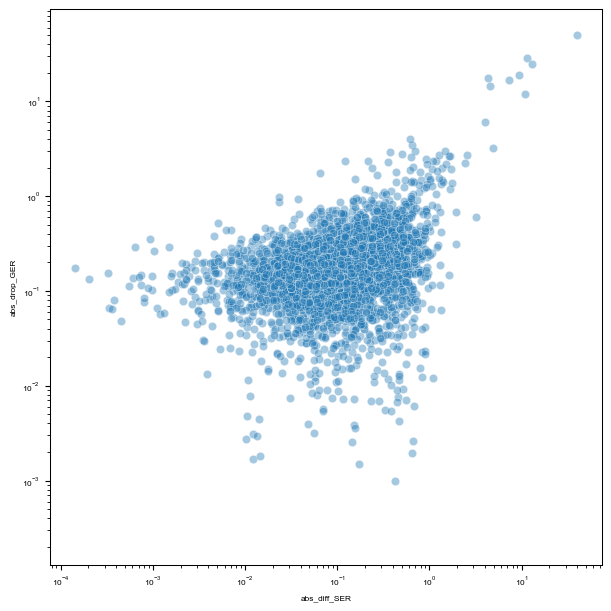

In [30]:
## Bonus easter egg - not sure what to do with this result, but I want to keep it
## Most cytobands show a very, very weak correlation between an improvement in genotyping and an improvement in switch error rate
## A second cluster of cytobands show an improvement in switch error rate > 0.1% that is uncorrleated with the genotyping improvement (which was basically nil)

fig,ax = plt.subplots(1,1,figsize=(6,6))
q = cyto.loc[(cyto.method_of_phasing=='HPRC_variation_phased_with_reference_panel')&(cyto.ground_truth_data_source=='HPRC_samples')&(cyto.n_checked_grch38 > 50)&(cyto.n_checked_chm13 > 50)].sort_values(['method_of_phasing','ground_truth_data_source'])[
['interval','n_switch_errors_grch38','n_switch_errors_chm13','n_checked_grch38','n_checked_chm13','switch_error_rate_grch38','switch_error_rate_chm13','genotype_error_rate_grch38','genotype_error_rate_chm13','abs_diff_SER','rel_drop_SER', 'decipher']].sort_values('rel_drop_SER',ascending=False).reset_index(drop=True)
cyto['abs_drop_GER'] = cyto.genotype_error_rate_grch38-cyto.genotype_error_rate_chm13
cyto['rel_drop_GER'] = 1-(cyto.genotype_error_rate_chm13/cyto.genotype_error_rate_grch38)

ax = sns.scatterplot(x='abs_diff_SER', y='abs_drop_GER', data=cyto, ax=ax,alpha=0.4)
ax.set_yscale('log')
ax.set_xscale('log')

# Additional regions

Reviewers brought up reasonable curiosity about the performance of our data in different regions of the genome. This was especially fair in light of our claims that indel performance was hampered by inadequate genotyping and phasing accuracy in complex STR loci.<br>
<br>
These cells plot out some of the same performance metrics seen above, but broken out by variant membership in either:
  - GIAB's T2T/GRCh38 STR region annotation
  - GIAB's T2T/GRCh38 Segmental Duplication annotations
  - Platinum Pedigree Project's STR annotations (https://pubmed.ncbi.nlm.nih.gov/39149261/, https://github.com/dashnowlab/PlatinumTRs)

In [31]:
region_style = {k:v for k,v in syntenic_style.items()}
region_style['markers'] = True
del region_style['dashes']

In [32]:
number_of_variants_by_region = binned_maf_data_regions.groupby(['genome','region'], observed=True).sum(numeric_only=True)['n_checked'].reset_index().pivot(index='region', columns='genome', values='n_checked').fillna(0)
number_of_variants_by_region

genome                      GRCh38     CHM13v2.0
region                                          
All                   2.120897e+09  4.601699e+09
in_STRs               1.286402e+08  3.343351e+08
in_segdups            7.460767e+07  9.723856e+07
in_platinum_STRs      3.984057e+08  9.087063e+08
not_in_STRs           1.992256e+09  4.267364e+09
not_in_segdups        2.046289e+09  4.504460e+09
not_in_platinum_STRs  1.722491e+09  3.692993e+09
multiallelic          3.676842e+08  8.839478e+08
biallelic             1.753212e+09  3.717751e+09

In [33]:
binned_maf_data_regions['switch_error_rate'] = binned_maf_data_regions['switch_error_rate'].replace(0,np.nan)
binned_maf_data_regions['gt_error_rate'] = binned_maf_data_regions['gt_error_rate'].replace(0,np.nan)


In [34]:
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.dpi"] = 300

### Figure 2-style plots of switch error rate and genotyping error rate by region of interest

<Axes: xlabel='Minor Allele Frequency (%)'>

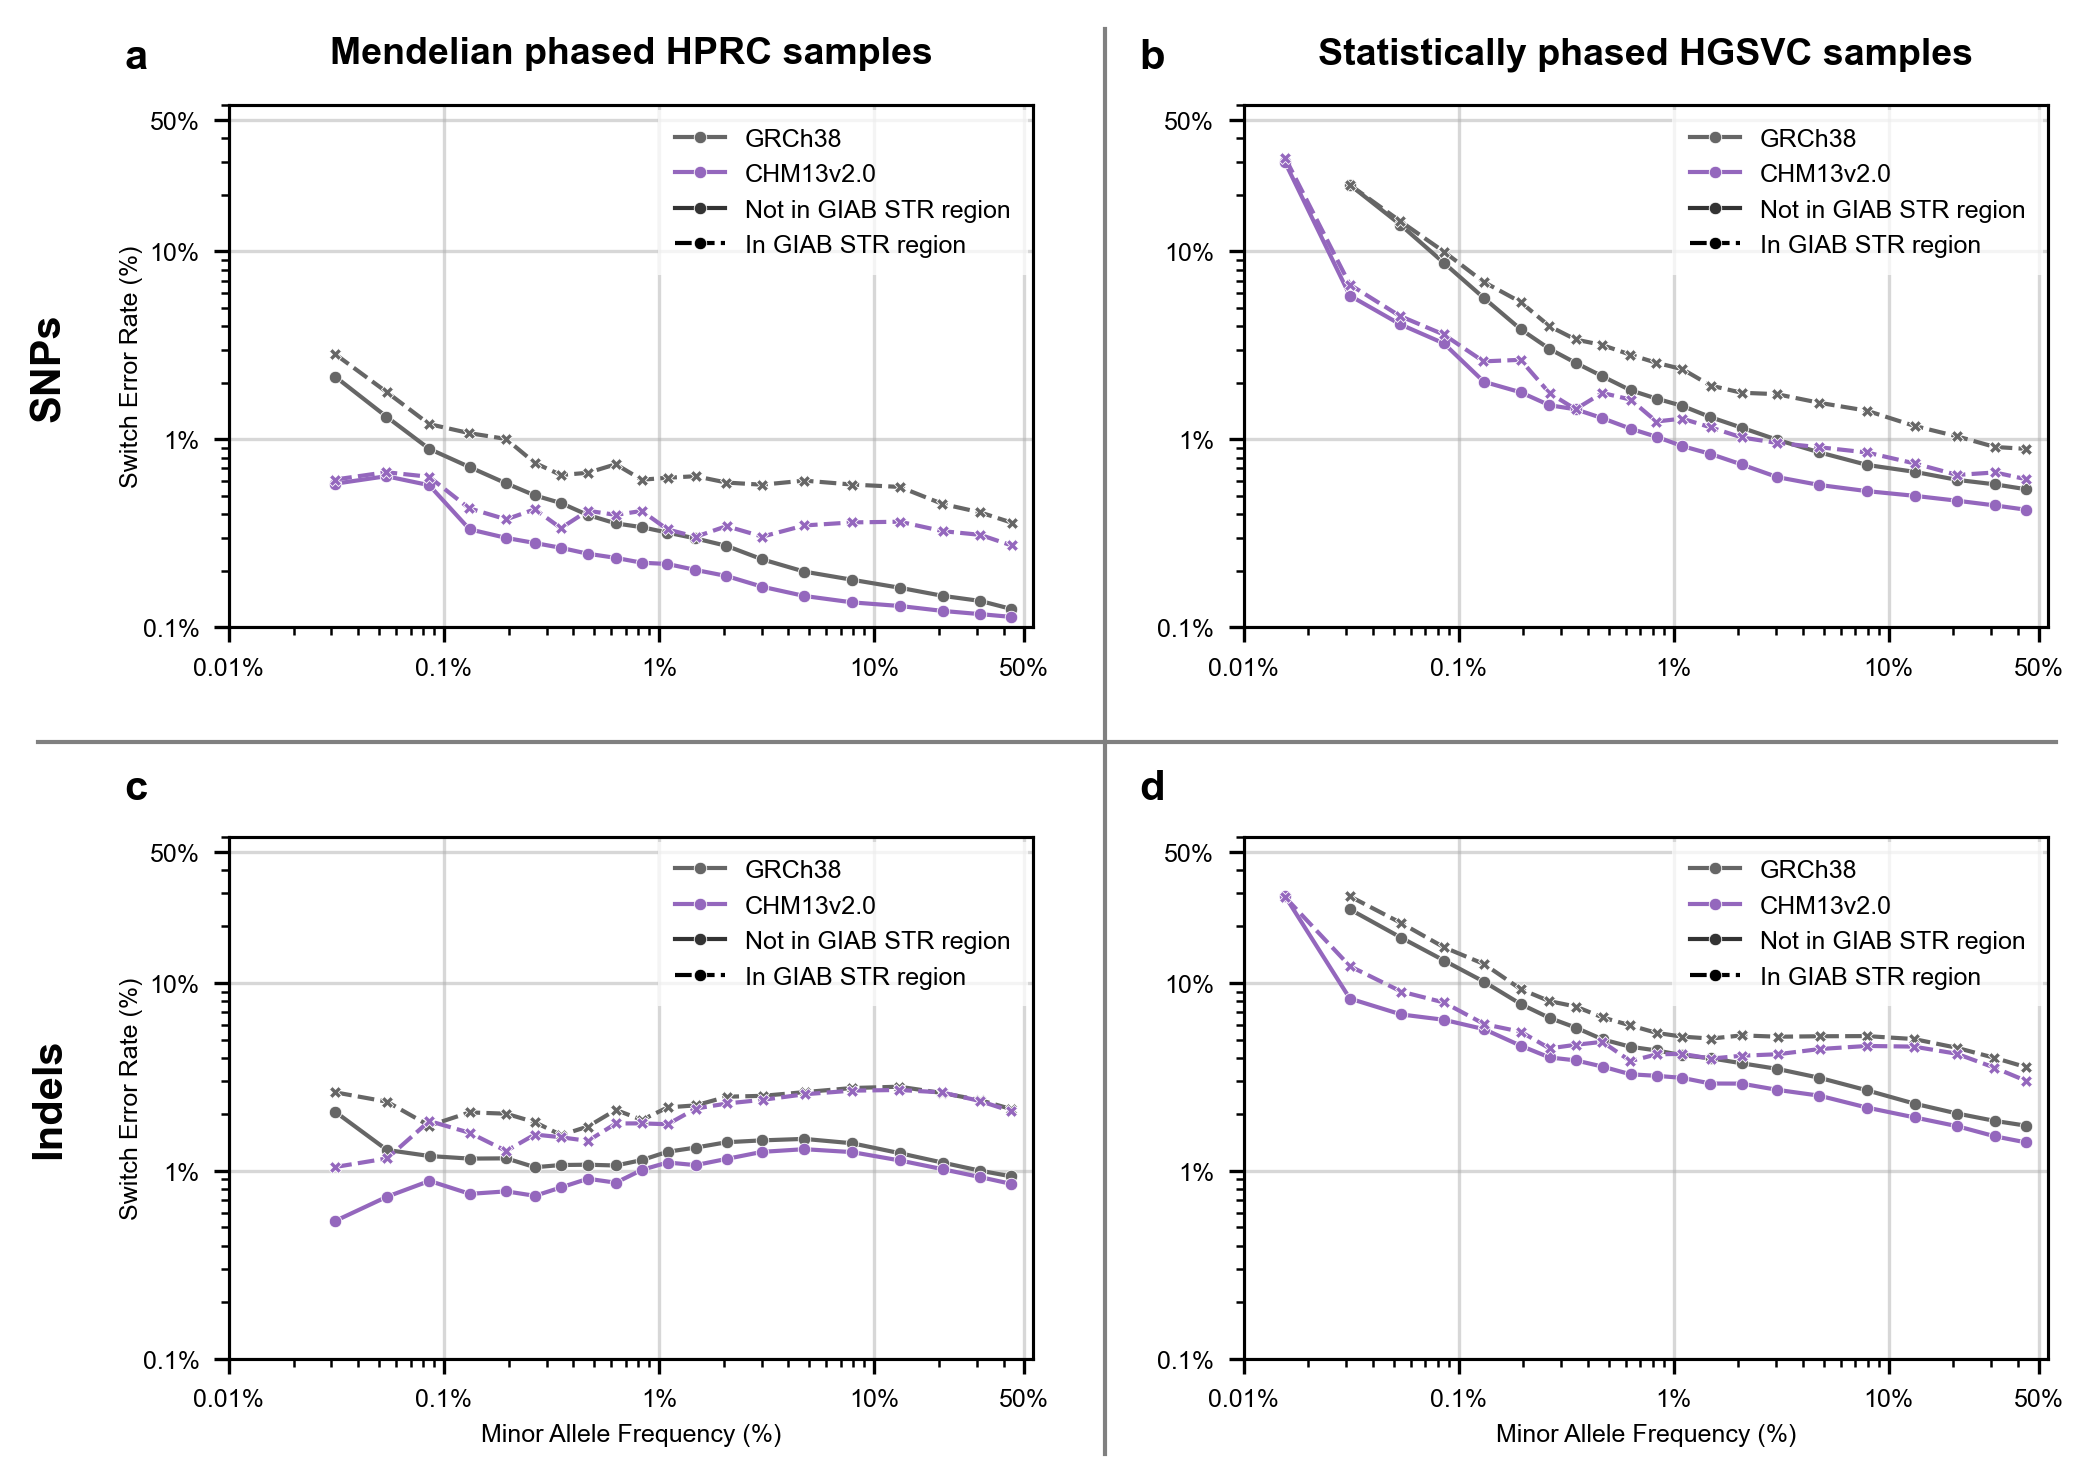

In [35]:
region_order=['not_in_STRs','in_STRs']

fig, ((axA, axB),(axC, axD)) = plt.subplots(2,2, figsize=(two_col, 5))
fig.set_layout_engine(layout='constrained', h_pad=0.15, w_pad=0.15)
sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
             legend=True, ax=axA, **region_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
             legend=True, ax=axB, **region_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
             legend=True, ax=axC, **region_style)


sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
             legend=True, ax=axD, **region_style)


for i, ax in enumerate([axA, axB, axC, axD]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-1, 60)#50)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks)
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (2,3):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2):
        ax.set_ylabel('Switch Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)

axA.text(-.2,0.5, 'SNPs', fontsize=10, transform=axA.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axC.text(-.2,0.5, 'Indels', fontsize=10, transform=axC.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axA.set_title('Mendelian phased HPRC samples', fontsize=9, weight='bold', pad=10)
axB.set_title('Statistically phased HGSVC samples', fontsize=9, weight='bold', pad=10)


legend_locs=dict()
for i, ax in enumerate([axA, axB, axC, axD]):
    if not axis_has_legend(ax):
        continue
    loc = legend_locs.get(i, 'best')
    handles, labels = ax.get_legend_handles_labels()
    for h_idx, handle in enumerate(handles):
        handle.set_marker('o')
        if h_idx >=5:
            handle.set_color('black')
    handles = handles[1:3] + handles[4:6]
    labels = labels[1:3] + labels[4:6]
    legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    legend.set_title(None)
    legend.get_frame().set(
        alpha=0.75, boxstyle='square', edgecolor='grey', linewidth=0)
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)

x_pos = 0.5275
y_pos = 0.5
perc_of_figure=0.95
fig.add_artist(mpl.lines.Line2D([(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], [y_pos, y_pos], color='grey', alpha=1, linewidth=1))
fig.add_artist(mpl.lines.Line2D([x_pos, x_pos], [(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], color='grey', alpha=1, linewidth=1))

add_letter_to_ax(axA, 'a')
add_letter_to_ax(axB, 'b')
add_letter_to_ax(axC, 'c')
add_letter_to_ax(axD, 'd')

# plt.savefig('figures/Figure 2.png', facecolor='white')
# plt.savefig('figures/Figure 2.svg', facecolor='white')

<Axes: xlabel='Minor Allele Frequency (%)'>

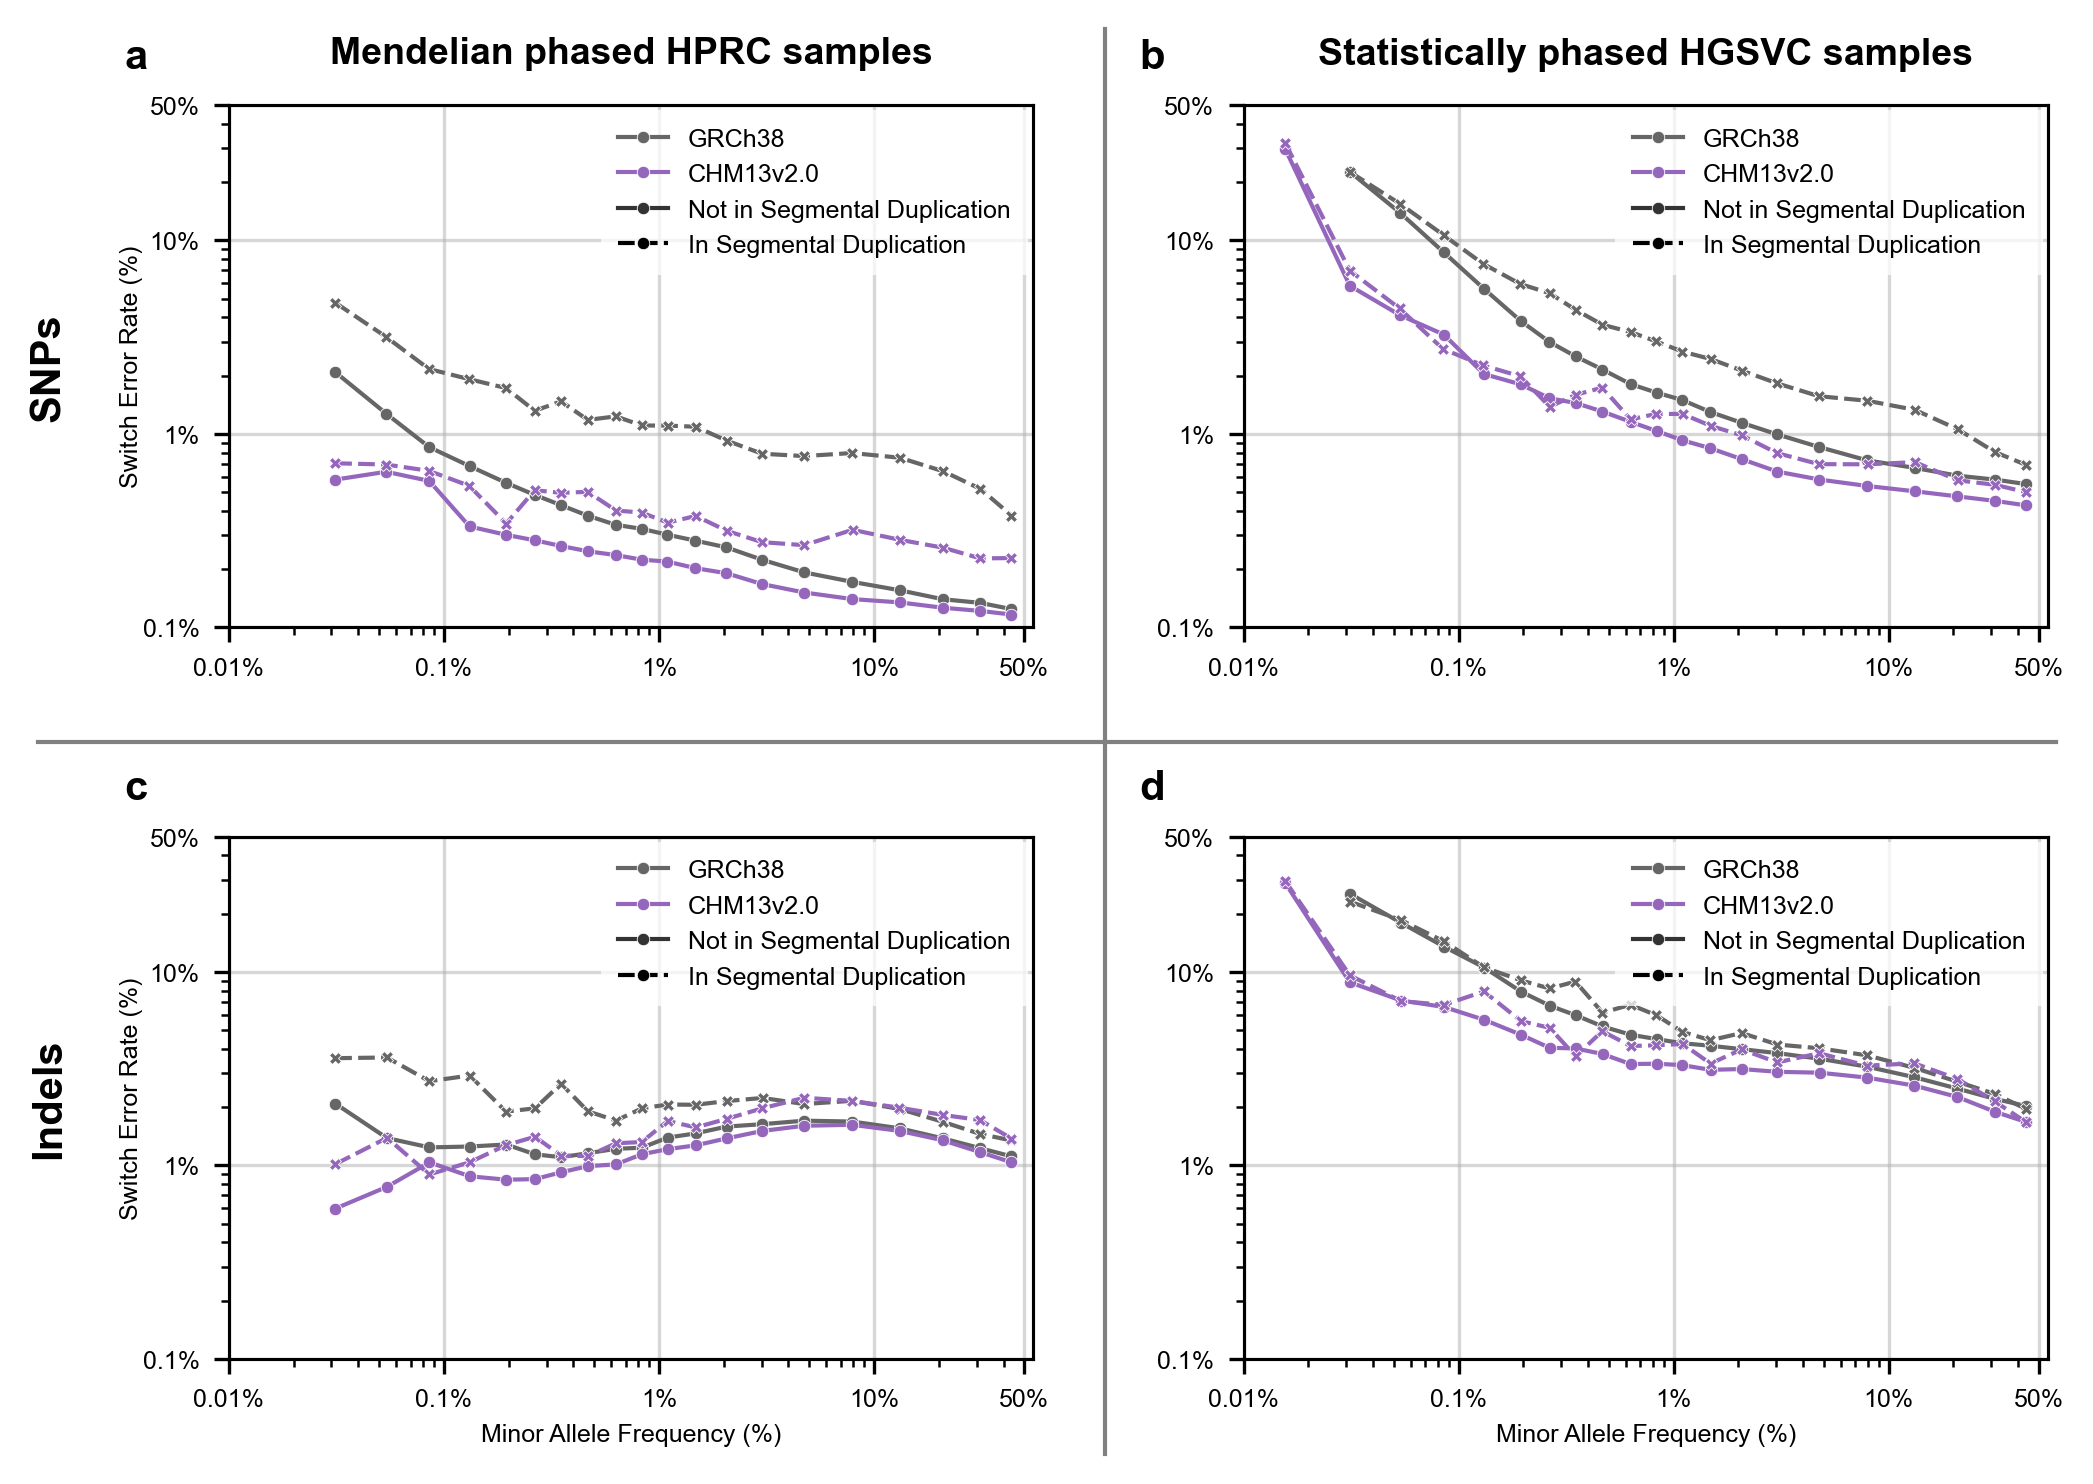

In [36]:
region_order=['not_in_segdups','in_segdups']

# Figure 2
fig, ((axA, axB),(axC, axD)) = plt.subplots(2,2, figsize=(two_col, 5))
fig.set_layout_engine(layout='constrained', h_pad=0.15, w_pad=0.15)
sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axA, **region_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axB, **region_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axC, **region_style)


sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axD, **region_style)


for i, ax in enumerate([axA, axB, axC, axD]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-1, 50)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks)
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (2,3):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2):
        ax.set_ylabel('Switch Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)

axA.text(-.2,0.5, 'SNPs', fontsize=10, transform=axA.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axC.text(-.2,0.5, 'Indels', fontsize=10, transform=axC.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axA.set_title('Mendelian phased HPRC samples', fontsize=9, weight='bold', pad=10)
axB.set_title('Statistically phased HGSVC samples', fontsize=9, weight='bold', pad=10)


legend_locs=dict()
for i, ax in enumerate([axA, axB, axC, axD]):
    if not axis_has_legend(ax):
        continue
    loc = legend_locs.get(i, 'best')
    handles, labels = ax.get_legend_handles_labels()
    for h_idx, handle in enumerate(handles):
        handle.set_marker('o')
        if h_idx >=5:
            handle.set_color('black')

    handles = handles[1:3] + handles[4:6]
    labels = labels[1:3] + labels[4:6]
    legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    legend.set_title(None)
    legend.get_frame().set(
        alpha=0.75, boxstyle='square', edgecolor='grey', linewidth=0)
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)

x_pos = 0.5275
y_pos = 0.5
perc_of_figure=0.95
fig.add_artist(mpl.lines.Line2D([(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], [y_pos, y_pos], color='grey', alpha=1, linewidth=1))
fig.add_artist(mpl.lines.Line2D([x_pos, x_pos], [(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], color='grey', alpha=1, linewidth=1))

add_letter_to_ax(axA, 'a')
add_letter_to_ax(axB, 'b')
add_letter_to_ax(axC, 'c')
add_letter_to_ax(axD, 'd')

# plt.savefig('figures/Figure 2.png', facecolor='white')
# plt.savefig('figures/Figure 2.svg', facecolor='white')

<Axes: xlabel='Minor Allele Frequency (%)'>

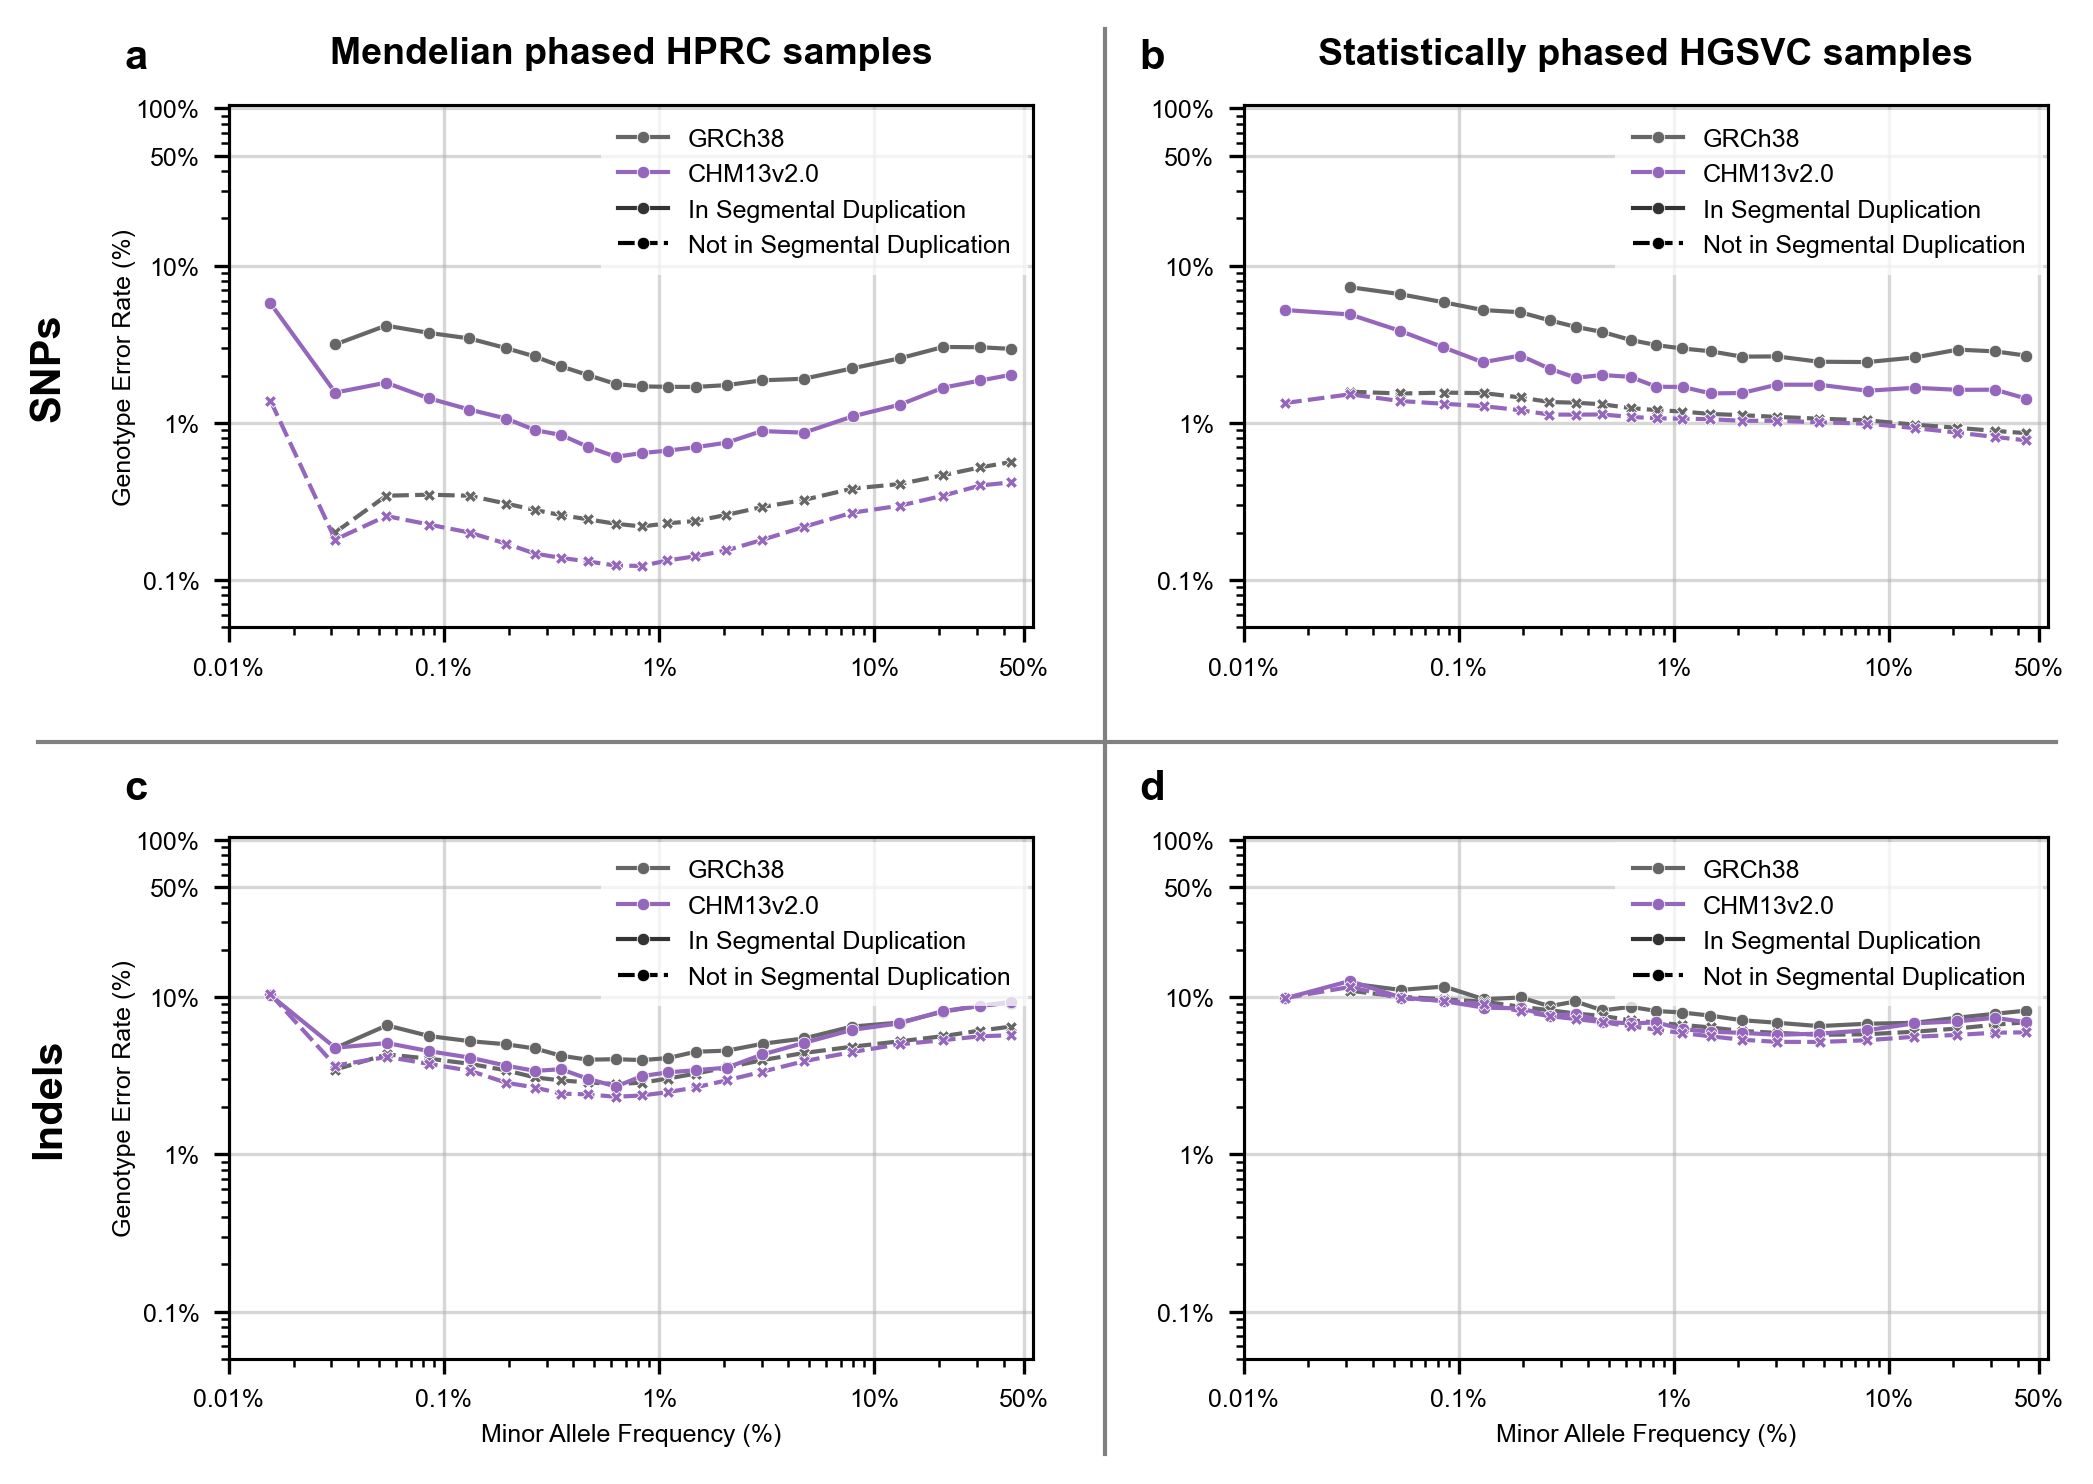

In [37]:
region_order=['in_segdups','not_in_segdups']

# Figure 2
fig, ((axA, axB),(axC, axD)) = plt.subplots(2,2, figsize=(two_col, 5))
fig.set_layout_engine(layout='constrained', h_pad=0.15, w_pad=0.15)
sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axA, **region_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axB, **region_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axC, **region_style)


sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axD, **region_style)


for i, ax in enumerate([axA, axB, axC, axD]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(5e-2, 105)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks+[100])
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (2,3):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2):
        ax.set_ylabel('Genotype Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)

axA.text(-.2,0.5, 'SNPs', fontsize=10, transform=axA.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axC.text(-.2,0.5, 'Indels', fontsize=10, transform=axC.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axA.set_title('Mendelian phased HPRC samples', fontsize=9, weight='bold', pad=10)
axB.set_title('Statistically phased HGSVC samples', fontsize=9, weight='bold', pad=10)


legend_locs=dict()
for i, ax in enumerate([axA, axB, axC, axD]):
    if not axis_has_legend(ax):
        continue
    loc = legend_locs.get(i, 'best')
    handles, labels = ax.get_legend_handles_labels()
    for h_idx, handle in enumerate(handles):
        handle.set_marker('o')
        if h_idx >=5:
            handle.set_color('black')

    handles = handles[1:3] + handles[4:6]
    labels = labels[1:3] + labels[4:6]
    legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    legend.set_title(None)
    legend.get_frame().set(
        alpha=0.75, boxstyle='square', edgecolor='grey', linewidth=0)
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)

x_pos = 0.5275
y_pos = 0.5
perc_of_figure=0.95
fig.add_artist(mpl.lines.Line2D([(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], [y_pos, y_pos], color='grey', alpha=1, linewidth=1))
fig.add_artist(mpl.lines.Line2D([x_pos, x_pos], [(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], color='grey', alpha=1, linewidth=1))

add_letter_to_ax(axA, 'a')
add_letter_to_ax(axB, 'b')
add_letter_to_ax(axC, 'c')
add_letter_to_ax(axD, 'd')

# plt.savefig('figures/Figure 2.png', facecolor='white')
# plt.savefig('figures/Figure 2.svg', facecolor='white')

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ssd/lalli/phasing_T2T/phasing_T2T_project/figures/supplemental/tmp/supplemental_xxx_fig2butSwitch_BivsMulti.png'

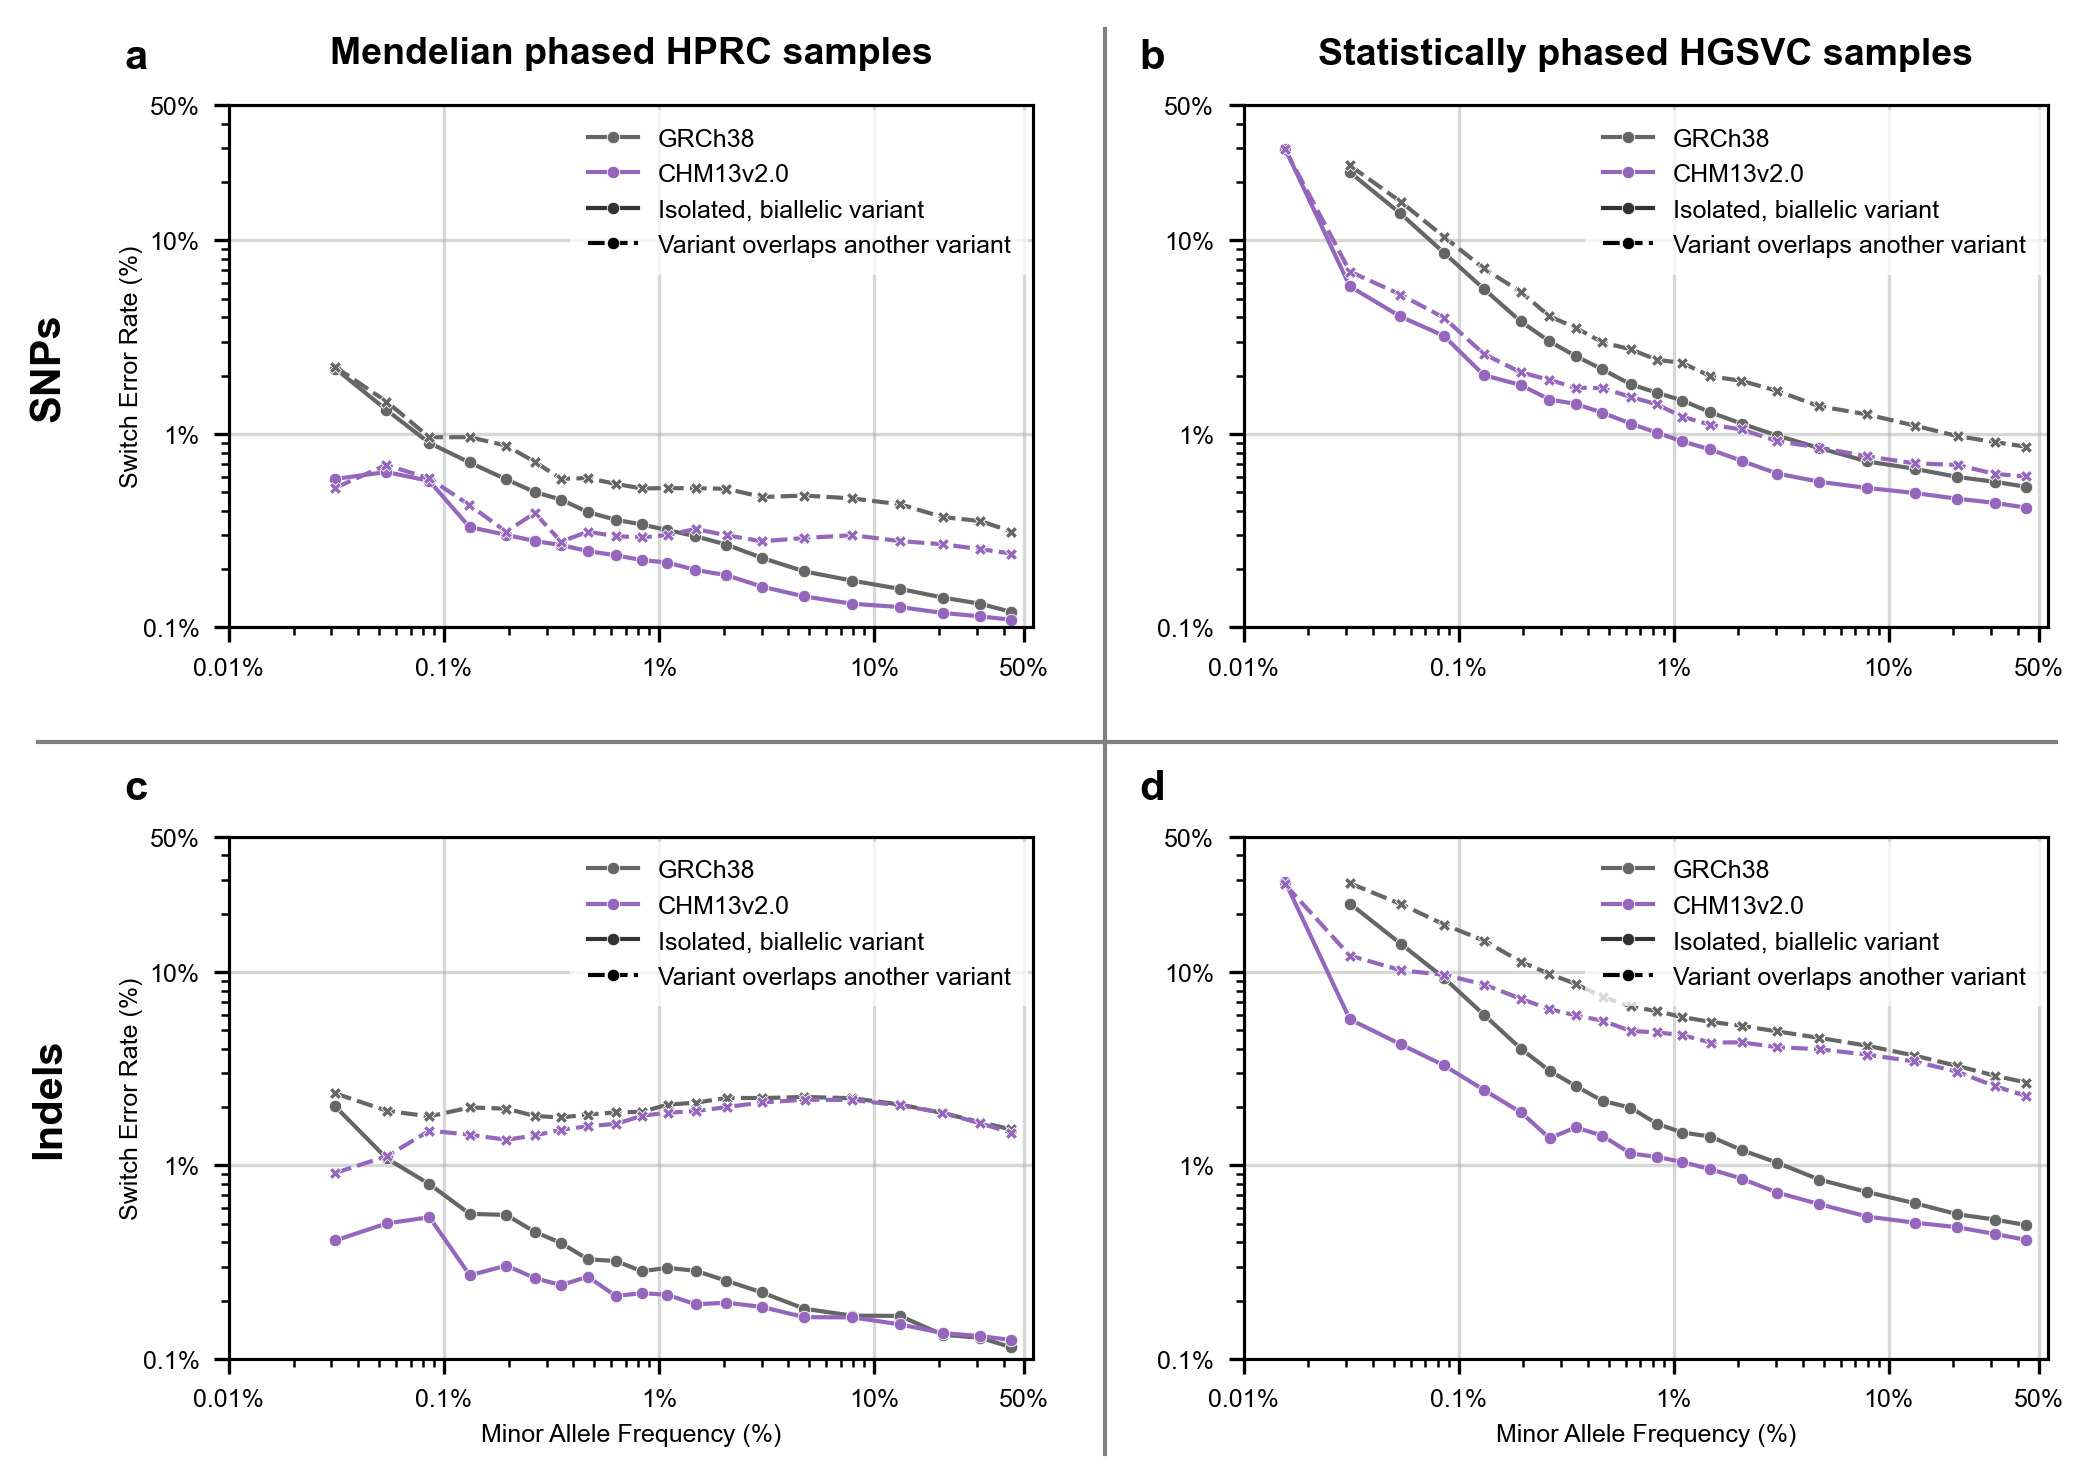

In [38]:
region_order=['biallelic','multiallelic']
# Figure 2
fig, ((axA, axB),(axC, axD)) = plt.subplots(2,2, figsize=(two_col, 5))
fig.set_layout_engine(layout='constrained', h_pad=0.15, w_pad=0.15)
sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axA, **region_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axB, **region_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axC, **region_style)


sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axD, **region_style)


for i, ax in enumerate([axA, axB, axC, axD]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-1, 50)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks)
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (2,3):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2):
        ax.set_ylabel('Switch Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)

axA.text(-.2,0.5, 'SNPs', fontsize=10, transform=axA.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axC.text(-.2,0.5, 'Indels', fontsize=10, transform=axC.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axA.set_title('Mendelian phased HPRC samples', fontsize=9, weight='bold', pad=10)
axB.set_title('Statistically phased HGSVC samples', fontsize=9, weight='bold', pad=10)

legend_locs=dict()
for i, ax in enumerate([axA, axB, axC, axD]):
    if not axis_has_legend(ax):
        continue
    loc = legend_locs.get(i, 'upper right')
    handles, labels = ax.get_legend_handles_labels()
    for h_idx, handle in enumerate(handles):
        handle.set_marker('o')
        if h_idx >=5:
            handle.set_color('black')

    handles = handles[1:3] + handles[4:6]
    labels = labels[1:3] + labels[4:6]
    legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    legend.set_title(None)
    legend.get_frame().set(
        alpha=0.75, boxstyle='square', edgecolor='grey', linewidth=0)
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)


x_pos = 0.5275
y_pos = 0.5
perc_of_figure=0.95
fig.add_artist(mpl.lines.Line2D([(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], [y_pos, y_pos], color='grey', alpha=1, linewidth=1))
fig.add_artist(mpl.lines.Line2D([x_pos, x_pos], [(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], color='grey', alpha=1, linewidth=1))

add_letter_to_ax(axA, 'a')
add_letter_to_ax(axB, 'b')
add_letter_to_ax(axC, 'c')
add_letter_to_ax(axD, 'd')
# fig.suptitle('Switch Error Rates - Biallelic vs Multiallelic', fontsize=10, weight='bold', y=1.02)

plt.savefig(f'{supplemental_figures_folder}/tmp/supplemental_xxx_fig2butSwitch_BivsMulti.png', facecolor='white')
plt.savefig(f'{supplemental_figures_folder}/tmp/supplemental_xxx_fig2butSwitch_BivsMulti.svg', facecolor='white')

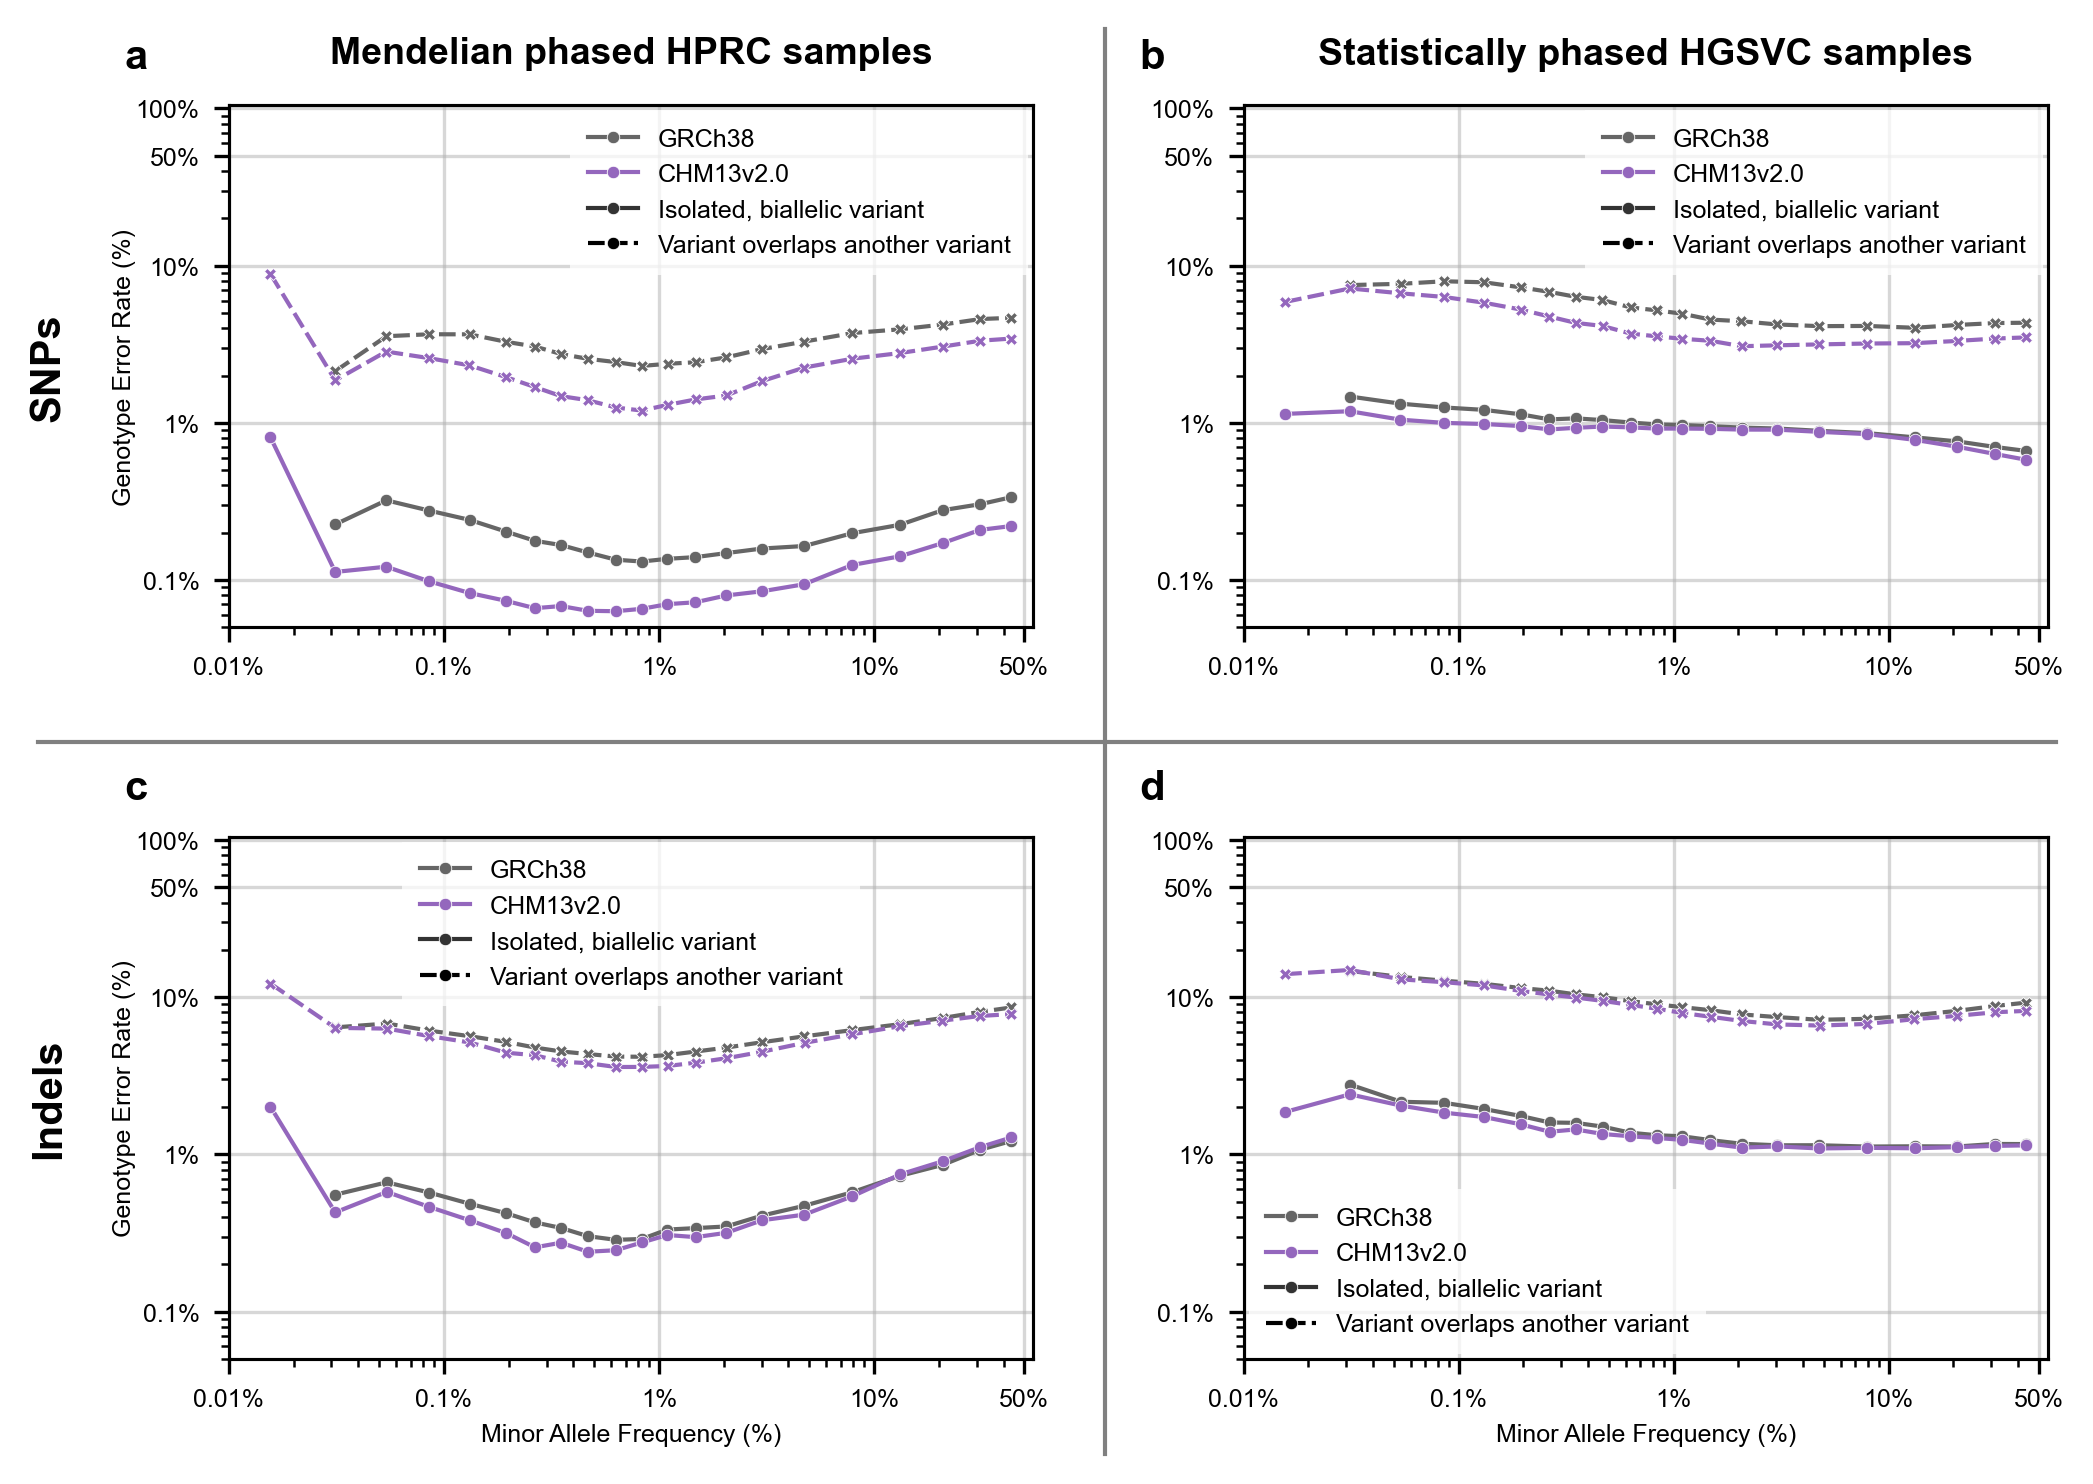

In [ ]:
region_order=['biallelic','multiallelic']

# Figure 2
fig, ((axA, axB),(axC, axD)) = plt.subplots(2,2, figsize=(two_col, 5))
fig.set_layout_engine(layout='constrained', h_pad=0.15, w_pad=0.15)
sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')
                                      & (binned_maf_data_regions.region.isin(region_order))],
             legend=True, ax=axA, **region_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')
                                      & (binned_maf_data_regions.region.isin(region_order))],
             legend=True, ax=axB, **region_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')
                                      & (binned_maf_data_regions.region.isin(region_order))],
             legend=True, ax=axC, **region_style)


sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')
                                      & (binned_maf_data_regions.region.isin(region_order))],
             legend=True, ax=axD, **region_style)


for i, ax in enumerate([axA, axB, axC, axD]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(5e-2, 105)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks+[100])
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (2,3):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2):
        ax.set_ylabel('Genotype Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)

axA.text(-.2,0.5, 'SNPs', fontsize=10, transform=axA.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axC.text(-.2,0.5, 'Indels', fontsize=10, transform=axC.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axA.set_title('Mendelian phased HPRC samples', fontsize=9, weight='bold', pad=10)
axB.set_title('Statistically phased HGSVC samples', fontsize=9, weight='bold', pad=10)

legend_locs = {0:'upper right',1:'upper right',2:'upper center',3:'lower left'}
for i, ax in enumerate([axA, axB, axC, axD]):
    if not axis_has_legend(ax):
        continue
    loc = legend_locs.get(i, 'upper right')
    handles, labels = ax.get_legend_handles_labels()
    for h_idx, handle in enumerate(handles):
        handle.set_marker('o')
        if h_idx >=5:
            handle.set_color('black')

    handles = handles[1:3] + handles[4:6]
    labels = labels[1:3] + labels[4:6]
    # print (handles)
    legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    legend.set_title(None)
    legend.get_frame().set(
        alpha=0.75, boxstyle='square', edgecolor='grey', linewidth=0)
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)

x_pos = 0.5275
y_pos = 0.5
perc_of_figure=0.95
fig.add_artist(mpl.lines.Line2D([(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], [y_pos, y_pos], color='grey', alpha=1, linewidth=1))
fig.add_artist(mpl.lines.Line2D([x_pos, x_pos], [(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], color='grey', alpha=1, linewidth=1))

add_letter_to_ax(axA, 'a')
add_letter_to_ax(axB, 'b')
add_letter_to_ax(axC, 'c')
add_letter_to_ax(axD, 'd')
# fig.suptitle('Genotyping Error Rates - Biallelic vs Multiallelic', fontsize=10, weight='bold', y=1.02)
plt.savefig(f'{supplemental_figures_folder}/tmp/supplemental_xxx_fig2butGT_BivsMulti.png', facecolor='white')
plt.savefig(f'{supplemental_figures_folder}/tmp/supplemental_xxx_fig2butGT_BivsMulti.svg', facecolor='white')

<Axes: xlabel='Minor Allele Frequency (%)'>

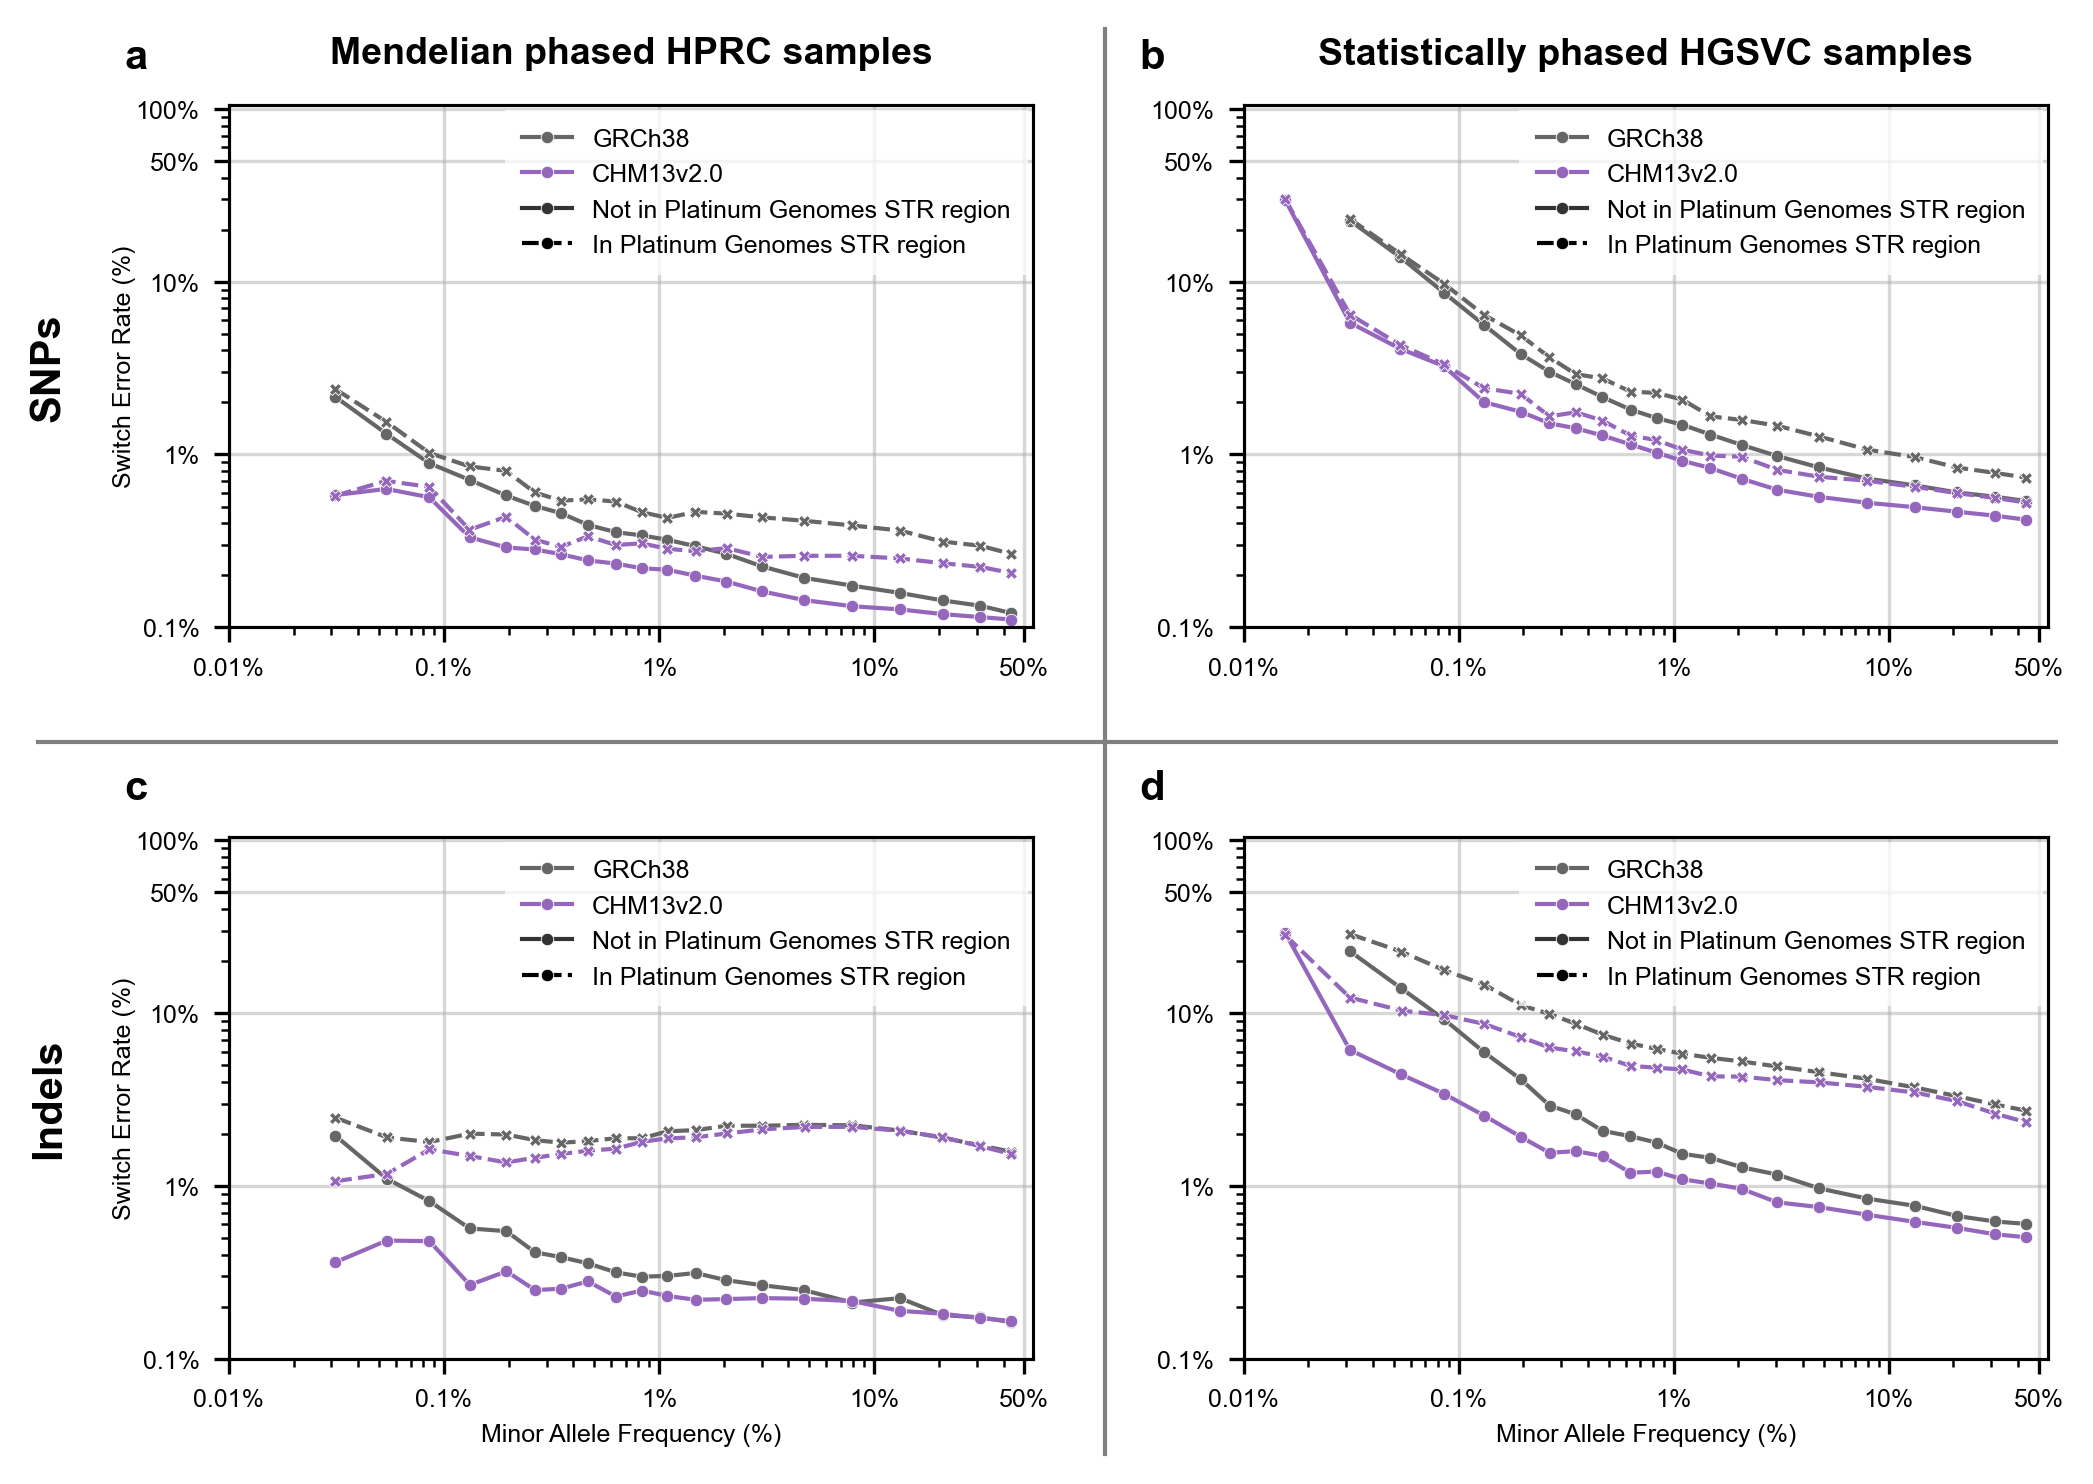

In [ ]:
region_order=['not_in_platinum_STRs','in_platinum_STRs']
# Figure 2
fig, ((axA, axB),(axC, axD)) = plt.subplots(2,2, figsize=(two_col, 5))
fig.set_layout_engine(layout='constrained', h_pad=0.15, w_pad=0.15)
sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
             legend=True, ax=axA, **region_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
             legend=True, ax=axB, **region_style)

sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
             legend=True, ax=axC, **region_style)


sns.lineplot(x='MAF',y='switch_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
             legend=True, ax=axD, **region_style)


for i, ax in enumerate([axA, axB, axC, axD]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-1, 105)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks+[100])
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (2,3):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2):
        ax.set_ylabel('Switch Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)

axA.text(-.2,0.5, 'SNPs', fontsize=10, transform=axA.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axC.text(-.2,0.5, 'Indels', fontsize=10, transform=axC.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axA.set_title('Mendelian phased HPRC samples', fontsize=9, weight='bold', pad=10)
axB.set_title('Statistically phased HGSVC samples', fontsize=9, weight='bold', pad=10)


legend_locs=dict()
for i, ax in enumerate([axA, axB, axC, axD]):
    if not axis_has_legend(ax):
        continue
    loc = legend_locs.get(i, 'best')
    handles, labels = ax.get_legend_handles_labels()
    for h_idx, handle in enumerate(handles):
        handle.set_marker('o')
        if h_idx >=5:
            handle.set_color('black')

    handles = handles[1:3] + handles[4:6]
    labels = labels[1:3] + labels[4:6]
    legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    legend.set_title(None)
    legend.get_frame().set(
        alpha=0.75, boxstyle='square', edgecolor='grey', linewidth=0)
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)

x_pos = 0.5275
y_pos = 0.5
perc_of_figure=0.95
fig.add_artist(mpl.lines.Line2D([(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], [y_pos, y_pos], color='grey', alpha=1, linewidth=1))
fig.add_artist(mpl.lines.Line2D([x_pos, x_pos], [(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], color='grey', alpha=1, linewidth=1))

# fig.suptitle('Phasing accuracy stratified by presence in Platinum repeat regions', fontsize=11, weight='bold', y=1.02)

add_letter_to_ax(axA, 'a')
add_letter_to_ax(axB, 'b')
add_letter_to_ax(axC, 'c')
add_letter_to_ax(axD, 'd')

# plt.savefig('figures/Figure 2.png', facecolor='white')
# plt.savefig('figures/Figure 2.svg', facecolor='white')

<Axes: xlabel='Minor Allele Frequency (%)'>

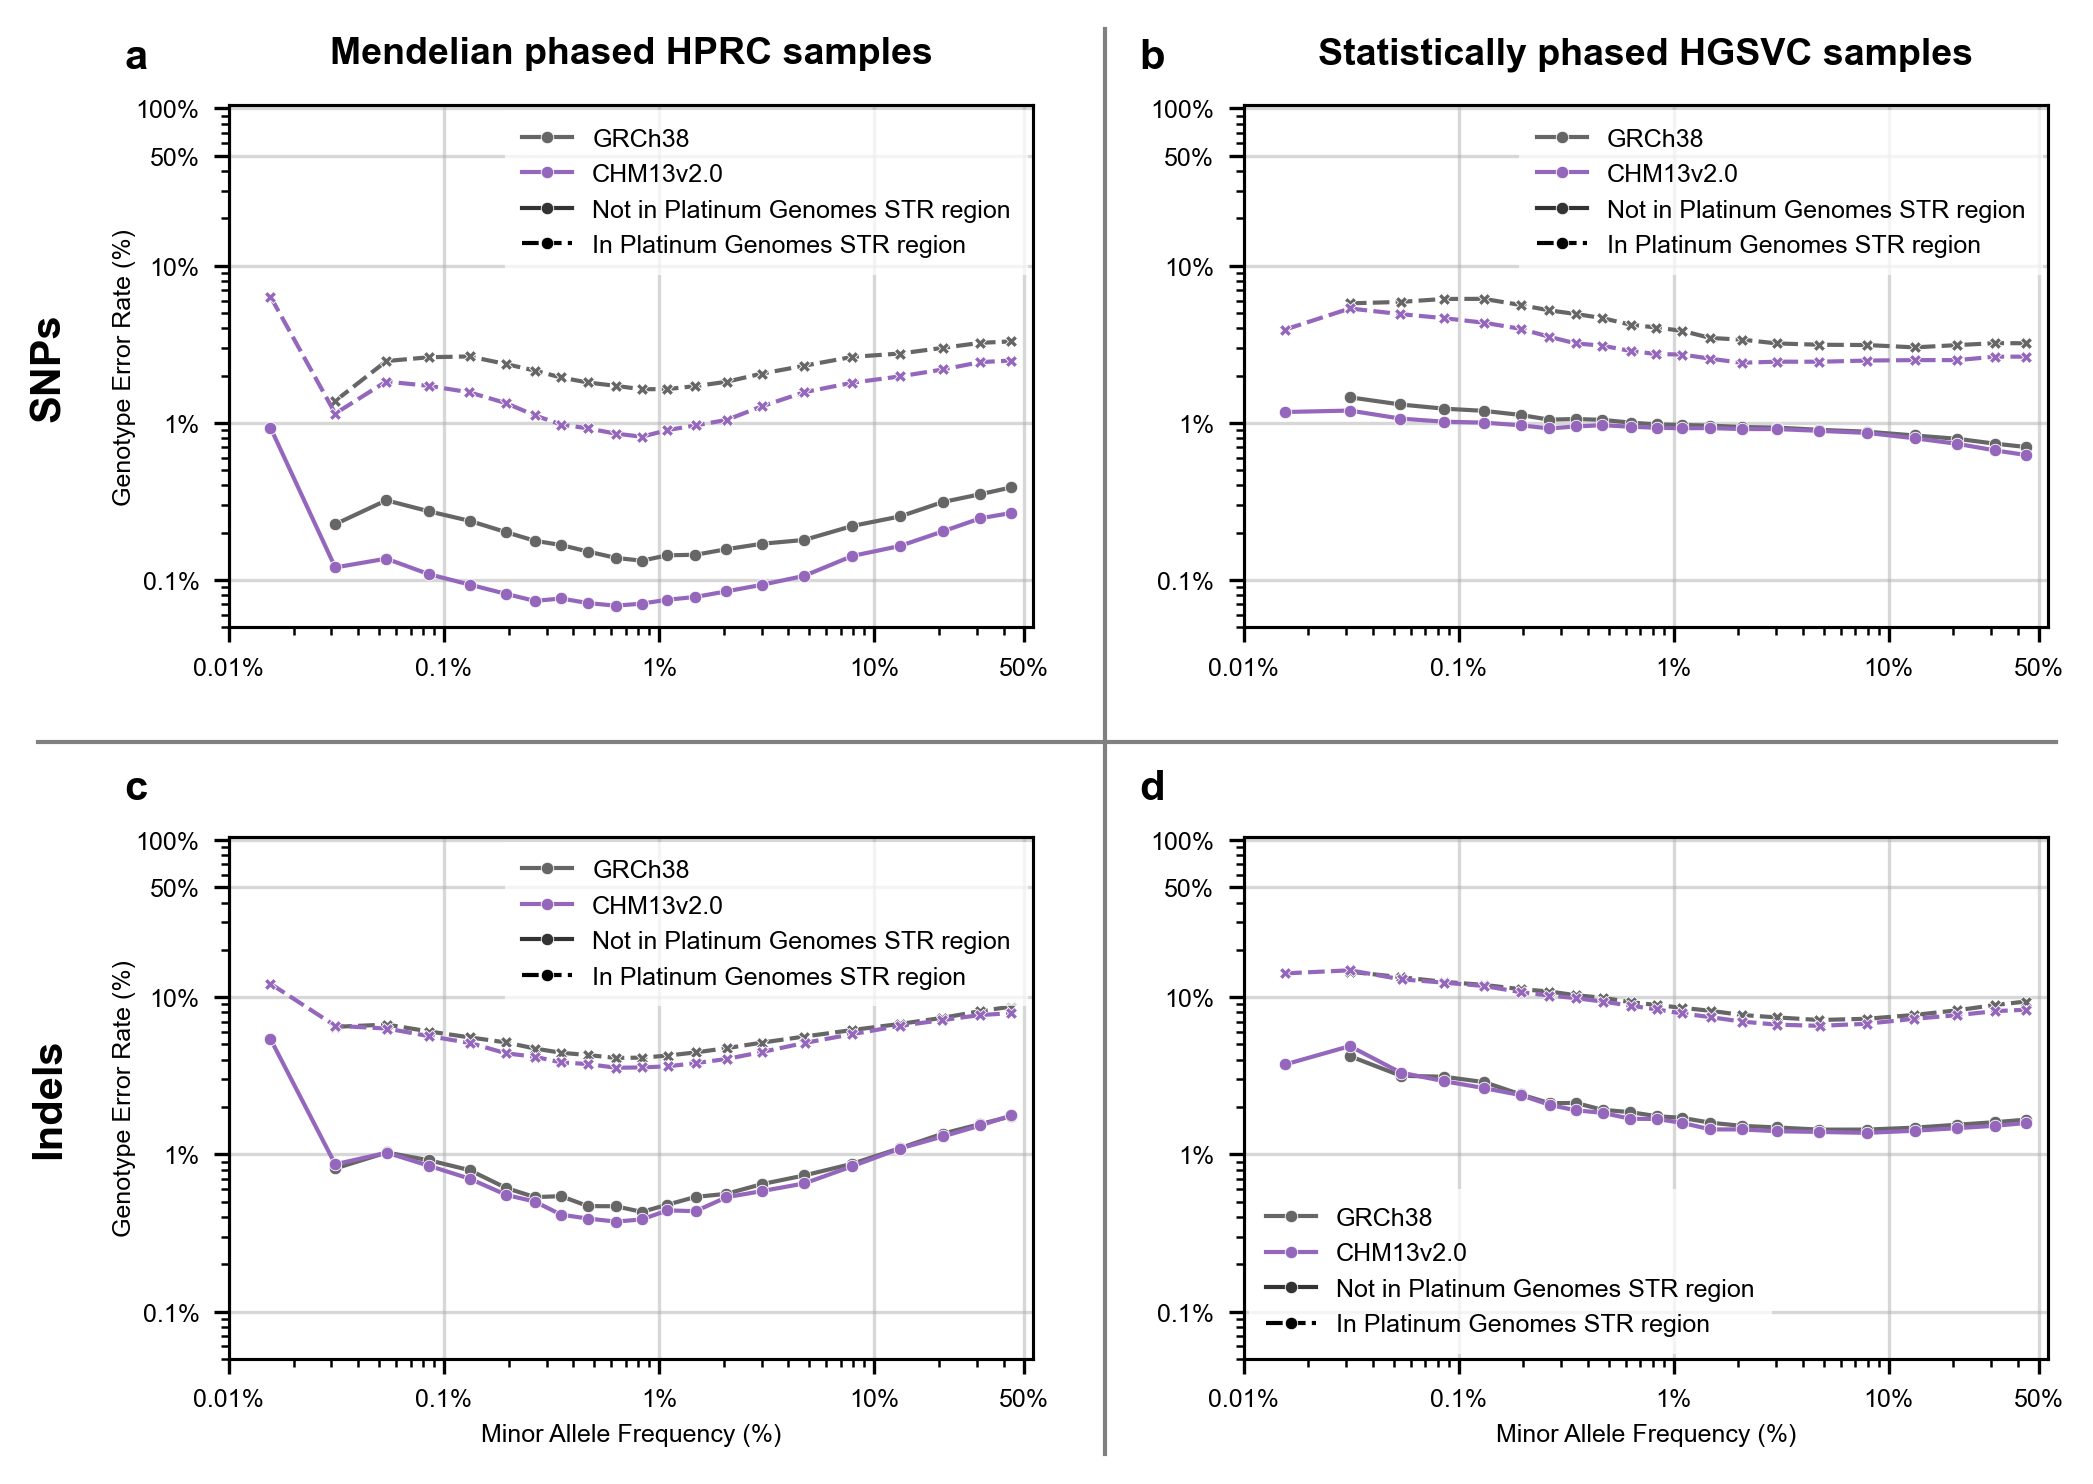

In [ ]:
region_order=['not_in_platinum_STRs','in_platinum_STRs']
# Figure 2
fig, ((axA, axB),(axC, axD)) = plt.subplots(2,2, figsize=(two_col, 5))
fig.set_layout_engine(layout='constrained', h_pad=0.15, w_pad=0.15)
sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axA, **region_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'SNP')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axB, **region_style)

sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HPRC_samples')
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axC, **region_style)


sns.lineplot(x='MAF',y='gt_error_rate', style='region', hue='genome', hue_order = genome_order, style_order = region_order,
             data=binned_maf_data_regions.loc[(binned_maf_data_regions.ground_truth_data_source == 'HGSVC_samples_nontrios_only') #trios only
                                      & (binned_maf_data_regions.method_of_phasing == 'phased_with_parents_and_pedigree')
                                      & (binned_maf_data_regions.type == 'Indel')],
                                    #   & (binned_maf_data_regions.syntenic != 'All')],
             legend=True, ax=axD, **region_style)


for i, ax in enumerate([axA, axB, axC, axD]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(5e-2, 105)
    ax.set_xlim(1e-2, 55)
    # ax.set_box_aspect(1)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticks(MAF_xticks)
    ax.set_yticks(SER_xticks+[100])
    ax.xaxis.set_major_formatter(perc_formatter)
    ax.yaxis.set_major_formatter(perc_formatter)
    if i in (2,3):
        ax.set_xlabel('Minor Allele Frequency (%)', labelpad=3)
    else:
        ax.set_xlabel(None)
    if i in (0,2):
        ax.set_ylabel('Genotype Error Rate (%)', labelpad=0)
    else:
        ax.set_ylabel(None)

axA.text(-.2,0.5, 'SNPs', fontsize=10, transform=axA.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axC.text(-.2,0.5, 'Indels', fontsize=10, transform=axC.transAxes, weight='bold', rotation='vertical', horizontalalignment='right', verticalalignment='center')
axA.set_title('Mendelian phased HPRC samples', fontsize=9, weight='bold', pad=10)
axB.set_title('Statistically phased HGSVC samples', fontsize=9, weight='bold', pad=10)


legend_locs=dict()
for i, ax in enumerate([axA, axB, axC, axD]):
    if not axis_has_legend(ax):
        continue
    loc = legend_locs.get(i, 'best')
    handles, labels = ax.get_legend_handles_labels()
    for h_idx, handle in enumerate(handles):
        handle.set_marker('o')
        if h_idx >=5:
            handle.set_color('black')

    handles = handles[1:3] + handles[4:6]
    labels = labels[1:3] + labels[4:6]
    legend = ax.legend(ncols=1, loc=loc, handles=handles, labels=labels)
    legend.set_title(None)
    legend.get_frame().set(
        alpha=0.75, boxstyle='square', edgecolor='grey', linewidth=0)
    for text in legend.get_texts():
        t = text.get_text()
        new_t = update_legend_values.get(t,t)
        text.set_text(new_t)

x_pos = 0.5275
y_pos = 0.5
perc_of_figure=0.95
fig.add_artist(mpl.lines.Line2D([(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], [y_pos, y_pos], color='grey', alpha=1, linewidth=1))
fig.add_artist(mpl.lines.Line2D([x_pos, x_pos], [(1-perc_of_figure)/2, 1 - (1-perc_of_figure)/2], color='grey', alpha=1, linewidth=1))

# fig.suptitle('Phasing accuracy stratified by presence in Platinum repeat regions', fontsize=11, weight='bold', y=1.02)

add_letter_to_ax(axA, 'a')
add_letter_to_ax(axB, 'b')
add_letter_to_ax(axC, 'c')
add_letter_to_ax(axD, 'd')

# plt.savefig('figures/Figure 2.png', facecolor='white')
# plt.savefig('figures/Figure 2.svg', facecolor='white')